<a href="https://colab.research.google.com/github/joel-ruetas/sentiment-analysis/blob/main/Multiclass_Sentiment_Analysis_on_Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Sentiment Analysis on Amazon Reviews

## Author
Joel Ruetas

## Abstract:
The abstract outlines the study's objective: using Amazon product reviews to categorize them into negative, neutral, or positive sentiments.

## Background:
The background section provides context about Amazon, describing it as a comprehensive online retailer and web service provider with a vast array of products. It emphasizes the extensive range of products available on Amazon, including over 12 million items, which expands to more than 350 million products when including Marketplace sellers. The section also highlights the impracticality of manually classifying the enormous volume of customer reviews, suggesting machine learning as a more efficient alternative.

## Dataset:
The dataset used in the study is titled "[Amazon Reviews for Sentiment Analysis](https://www.kaggle.com/datasets/tarkkaanko/amazon)" and is available on Kaggle.
*   12 columns
*   4,915 rows

### Column Descriptions:
- **index:** The row number.
- **reviewerName:** The name of the user who submitted the review.
- **overall:** The overall product rating.
- **reviewText:** A summary of the evaluation.
- **reviewTime:** The time at which the evaluation was submitted.
- **day_diff:** The number of days since the review was posted.
- **helpful_yes:** The count of users who found the review useful.
- **helpful_no:** The count of users who did not find the review useful.
- **total_vote:** The total number of votes the review received.
- **score_pos_neg_diff:** A score indicating the difference between positive and negative assessments.
- **score_average_rating:** The average rating score.
- **wilson_lower_bound:** The lower bound of the Wilson score confidence interval, which is a statistical measure used to sort products based on their positive and negative ratings.

## References:
- https://aws.amazon.com/what-is/sentiment-analysis/
- https://www.bigcommerce.com/blog/amazon-statistics/

## Import necessary libraries

In [ ]:
!pip install contractions
!pip install mlens
!pip install vaderSentiment
!pip install yellowbrick
!pip3 install ydata-profiling --upgrade

import contractions
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import six
import spacy
import sys
import time
import xgboost as xgb

from bs4 import BeautifulSoup
from collections import Counter
from mlxtend.classifier import EnsembleVoteClassifier
from numpy import nan
from scipy.stats import reciprocal, uniform
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import LinearSVC, SVC
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from ydata_profiling import ProfileReport
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix, PrecisionRecallCurve, ROCAUC
from yellowbrick.features import RadViz
from yellowbrick.model_selection import CVScores, LearningCurve, RFECV

nlp = spacy.load('en_core_web_sm')
sys.modules['sklearn.externals.six'] = six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-non

## Functions

In [ ]:
# Clean data
def cleanData(doc, stemming = False):
    doc = BeautifulSoup(doc).get_text() # remove HTML tags
    doc = contractions.fix(doc) # remove contractions
    doc = re.sub('[^A-Za-z0-9.]+', ' ', doc) # remove special characters
    doc = doc.lower() # convert to lower case
    doc = nlp(doc) # perform tokenization

    # process tokens
    tokens = [tokens.lower_ for tokens in doc] # lowercase form of the token text
    tokens = [tokens for tokens in doc if (tokens.is_stop == False)] # remove stop words
    tokens = [tokens for tokens in tokens if (tokens.is_punct == False)] # remove punctuation

    final_token = [token.lemma_ for token in tokens] # base form of the token, with no inflectional suffixes

    return " ".join(final_token)

In [ ]:
'''
Create a sentiment column based on the value found in the overall column:
1-2 = Negative
3   = Neutral
4-5 = Positive
'''
def get_sentiment(row):

    if row['overall'] == 1.0 or row['overall'] == 2.0:
        # Negative = 0
        val = 0
    elif row['overall'] == 3.0:
        # Neutral = 1
        val = 1
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        # Positive = 2
        val = 2
    else:
        val = -1
    return val

In [ ]:
def my_tokenizer(text):
    # If the input text is not None, split the text into tokens
    return text.split() if text != None else []
    # The split method divides the string into a list where each word is a list item.
    # If the input text is None (i.e., if there's no text), return an empty list.

In [ ]:
def display_wordcloud(title, counter):
    # A small wordcloud wrapper
    wc = WordCloud(width = 1200,
                   height = 800,
                   background_color = 'black',
                   max_words = 500)

    # Generate the word cloud from frequency data provided in 'counter'
    wc.generate_from_frequencies(counter)

    # Set up the plot
    fig = plt.figure(figsize = (8, 6)) # Create a figure with a specific size
    plt.imshow(wc, interpolation = 'bilinear') # Display the word cloud as an image
    plt.axis('off') # Turn off the axis
    plt.title(title, fontsize = 19) # Set the title of the plot
    plt.tight_layout(pad = 0) # Adjust the layout
    plt.show() # Display the plot

In [ ]:
# Calculates the overall proportions of different sentiment values in the dataset.
def overall_proportions(data):
    # data["sentiment"].value_counts() counts the occurrence of each unique value in the 'sentiment' column of the 'data' DataFrame.
    # This provides a series where the index represents unique sentiment values and the values represent their respective counts.

    # Dividing the counts by len(data) normalizes these counts to proportions.
    # len(data) gives the total number of entries in the DataFrame, and dividing by this number converts counts to a proportion of the total.

    return data["sentiment"].value_counts() / len(data)

In [ ]:
# Calculates the sentiment of a given text using VADER sentiment analysis.
def vader_sentiment(text):
    # analyzer.polarity_scores(text) computes the sentiment scores for the input text.
    # VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool.
    # It is specifically attuned to sentiments expressed in social media and works well on texts from other domains.

    # The 'polarity_scores' method returns a dictionary with keys 'neg', 'neu', 'pos', and 'compound'.
    # These represent the negative, neutral, positive, and composite sentiment scores respectively.

    # ['compound'] accesses the 'compound' score from the dictionary.
    # The compound score is a normalized, weighted composite score that takes into account the sum of all lexicon ratings.
    # It ranges from -1 (most negative) to 1 (most positive).
    return analyzer.polarity_scores(text)['compound']

In [ ]:
# Display the accuracy of a given machine learning model.
def display_accuracy(model):
  # Start measuring time for training the model.
  t0 = time.time()

  # Train the model using the training data.
  # X_train contains the features for training, and y_train contains the corresponding labels.
  model.fit(X_train, y_train)

  # Calculate and print the training time.
  # time.time() - t0 gives the time elapsed since t0, which is the training duration.
  print("Training time:", time.time() - t0)

  # Predict the labels for the test dataset.
  # X_test contains the features for testing.
  y_pred = model.predict(X_test)

  # Calculate the accuracy of the model.
  # accuracy_score compares the predicted labels (y_pred) with the actual labels (y_test).
  # It returns the proportion of correct predictions.
  score = accuracy_score(y_pred, y_test)

  # Print the test accuracy in percentage format.
  # '{:.2f}%' formats the score as a floating point number with 2 digits after the decimal point.
  print('Test accuracy : {:.2f}%'.format(score * 100))

In [ ]:
# Display a classification report for a given machine learning model.
def display_classification_report(model):
  # Create a ClassificationReport visualizer object.
  # This object will generate a classification report for the model, showing main classification metrics.
  # ClassificationReport is  part of a visualization library Yellowbrick.
  visualizer = ClassificationReport(model)

  # Evaluate the model on the test data.
  # X_test contains the features for testing, and y_test contains the corresponding labels.
  # The visualizer uses these to compute the performance metrics of the model.
  visualizer.score(X_test, y_test)


  # Set the size of the visualization.
  # This sets the dimensions of the figure that will display the classification report.
  visualizer.size = (1080, 720)

  # Render and display the figure.
  visualizer.show()

In [ ]:
# Create and display a confusion matrix for a given machine learning model.
def display_confusion_matrix(model):
  # Create a ConfusionMatrix visualizer object.
  # This object will create a confusion matrix, a table used to describe the performance of a classification model.
  # The 'model' parameter is the machine learning model for which the confusion matrix is generated.
  # 'classes = model.classes_' assigns the class labels used by the model to the visualizer.
  # The ConfusionMatrix class is part of a visualization library Yellowbrick.
  visualizer = ConfusionMatrix(
      model,
      classes = model.classes_
  )

  # Fit the training data to the visualizer.
  # This step is necessary for the visualizer to understand the structure of the data and the model.
  # X_train contains the features for training, and y_train contains the corresponding labels.
  visualizer.fit(X_train, y_train)

  # Evaluate the model on the test data.
  # X_test contains the features for testing, and y_test contains the corresponding labels.
  # The visualizer uses these to compute the confusion matrix for the model.
  visualizer.score(X_test, y_test)

  # Set the size of the visualization.
  # This sets the dimensions of the figure that will display the confusion matrix.
  visualizer.size = (1080, 720)

  # Render and display the figure.
  visualizer.show()

In [ ]:
# Create and display the ROC (Receiver Operating Characteristic) curve for a given machine learning model.
def display_roc_curve(model):
  # Create a ROCAUC visualizer object.
  # This object will generate a ROC curve, which is a graphical plot that illustrates the diagnostic ability of a binary classifier.
  # 'model' is the machine learning model for which the ROC curve is generated.
  # 'classes = model.classes_' sets the class labels used by the model to the visualizer.
  # ROCAUC is part of a visualization library Yellowbrick.
  visualizer = ROCAUC(
      model,
      classes = model.classes_
  )

  # Fit the training data to the visualizer.
  # This step allows the visualizer to understand the structure of the data and the model.
  # X_train contains the features for training, and y_train contains the corresponding labels.
  visualizer.fit(X_train, y_train)

  # Evaluate the model on the test data to generate the ROC curve.
  # X_test contains the features for testing, and y_test contains the corresponding labels.
  # The visualizer uses these to compute the ROC curve for the model.
  visualizer.score(X_test, y_test)

  # Set the size of the visualization.
  # This sets the dimensions of the figure that will display the ROC curve.
  visualizer.size = (1080, 720)

  # Render and display the figure.
  visualizer.show()

In [ ]:
# Create and display the precision-recall curve for a given machine learning model.
def display_precision_recall_curve(model):
  # Create a PrecisionRecallCurve visualizer object.
  # This visualizer will generate a precision-recall curve, which is useful for showing the trade-off between precision and recall for different thresholds.
  # 'model' is the machine learning model for which the curve is generated.
  # 'per_class = True' indicates that the precision-recall curve should be generated for each class individually.
  # 'cmap = 'Set1'' sets the colormap for different classes in the plot.
  # PrecisionRecallCurve is a class from a visualization library Yellowbrick.
  visualizer = PrecisionRecallCurve(
      model,
      per_class = True,
      cmap = 'Set1'
  )

  # Fit the training data to the visualizer.
  # This step allows the visualizer to understand the structure of the data and the model.
  # X_train contains the features for training, and y_train contains the corresponding labels.
  visualizer.fit(X_train, y_train)

  # Evaluate the model on the test data to generate the ROC curve.
  # X_test contains the features for testing, and y_test contains the corresponding labels.
  # The visualizer uses these to compute the ROC curve for the model.
  visualizer.score(X_test, y_test)

  # Set the size of the visualization.
  # This sets the dimensions of the figure that will display the precision-recall curve.
  visualizer.size = (1080, 720)

  # Render and display the figure.
  visualizer.show()

In [ ]:
# Display the learning curve of a given machine learning model.
def display_learning_curve(model):
  # Create a cross-validation strategy.
  # StratifiedKFold is a cross-validator that provides train/test indices to split data in train/test sets.
  # 'n_splits = 12' means the dataset is divided into 12 folds, each fold used once as a validation while the 11 remaining folds form the training set.
  cv = StratifiedKFold(n_splits = 12)

  # Define the training set sizes for which the learning curves should be calculated.
  # np.linspace(0.3, 1.0, 10) creates 10 evenly spaced numbers between 0.3 and 1.0.
  # These numbers represent the proportion of the training dataset used to generate the learning curve.
  sizes = np.linspace(0.3, 1.0, 10)

  # Create a LearningCurve visualizer.
  # This visualizer plots the test and training learning curve by varying the size of the training set.
  # 'model' is the machine learning model, 'cv' is the cross-validation strategy defined earlier,
  # 'scoring = 'f1_weighted'' specifies the scoring metric to use, 'f1_weighted' provides a weighted average of F1 scores,
  # 'train_sizes' are the training sizes, and 'n_jobs = 4' allows parallel processing by using 4 CPU cores.
  visualizer = LearningCurve(
      model,
      cv = cv,
      scoring = 'f1_weighted',
      train_sizes = sizes,
      n_jobs = 4
  )

  # Fit the training data to the visualizer.
  # X_train contains the features for training, and y_train contains the corresponding labels.
  # The visualizer uses these to compute the learning curve.
  visualizer.fit(X_train, y_train)

  # Set the size of the visualization.
  # This sets the dimensions of the figure that will display the learning curve.
  visualizer.size = (1080, 720)

  # Render and display the figure.
  visualizer.show()

## Constants

In [ ]:
random_state = 42

np.random.seed(random_state)

## Get Data

In [ ]:
# Read the CSV file
df = pd.read_csv('amazon_reviews.csv')

## Exploratory Data Analysis

### Inspect the Dataset

In [ ]:
# View the first 5 rows
df.head()

Unnamed: 0  reviewerName  overall  \
0           0           NaN      4.0   
1           1          0mie      5.0   
2           2           1K3      4.0   
3           3           1m2      5.0   
4           4  2&amp;1/2Men      5.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   
3  This think has worked out great.Had a diff. br...  2013-11-21       382   
4  Bought it with Retail Packaging, arrived legit...  2013-07-13       513   

   helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0            0           0           0                   0   
1            0           0           0                   0   
2            0           0           0                   0   
3            0           0           0                   0   
4            0           0           0                   0   

   score_average_rating  wilson_lower_bound  
0                   0.0                 0.0  
1                   0.0                 0.0  
2                   0.0                 0.0  
3                   0.0                 0.0  
4                   0.0                 0.0

In [ ]:
# Display a concise summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [ ]:
# Check if Dataset has any nulls
df.isnull().any().any()

True

In [ ]:
# Display count of nulls in every column
df.isna().sum()

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

In [ ]:
# Display the distribution of the numerical features
df.describe()

Unnamed: 0      overall     day_diff  helpful_yes   helpful_no  \
count  4915.000000  4915.000000  4915.000000  4915.000000  4915.000000   
mean   2457.000000     4.587589   437.367040     1.311089     0.210376   
std    1418.982617     0.996845   209.439871    41.619161     4.023296   
min       0.000000     1.000000     1.000000     0.000000     0.000000   
25%    1228.500000     5.000000   281.000000     0.000000     0.000000   
50%    2457.000000     5.000000   431.000000     0.000000     0.000000   
75%    3685.500000     5.000000   601.000000     0.000000     0.000000   
max    4914.000000     5.000000  1064.000000  1952.000000   183.000000   

        total_vote  score_pos_neg_diff  score_average_rating  \
count  4915.000000         4915.000000           4915.000000   
mean      1.521465            1.100712              0.075468   
std      44.123095           39.367949              0.256062   
min       0.000000         -130.000000              0.000000   
25%       0.000000            0.000000              0.000000   
50%       0.000000            0.000000              0.000000   
75%       0.000000            0.000000              0.000000   
max    2020.000000         1884.000000              1.000000   

       wilson_lower_bound  
count         4915.000000  
mean             0.020053  
std              0.077187  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              0.957544

### Histogram

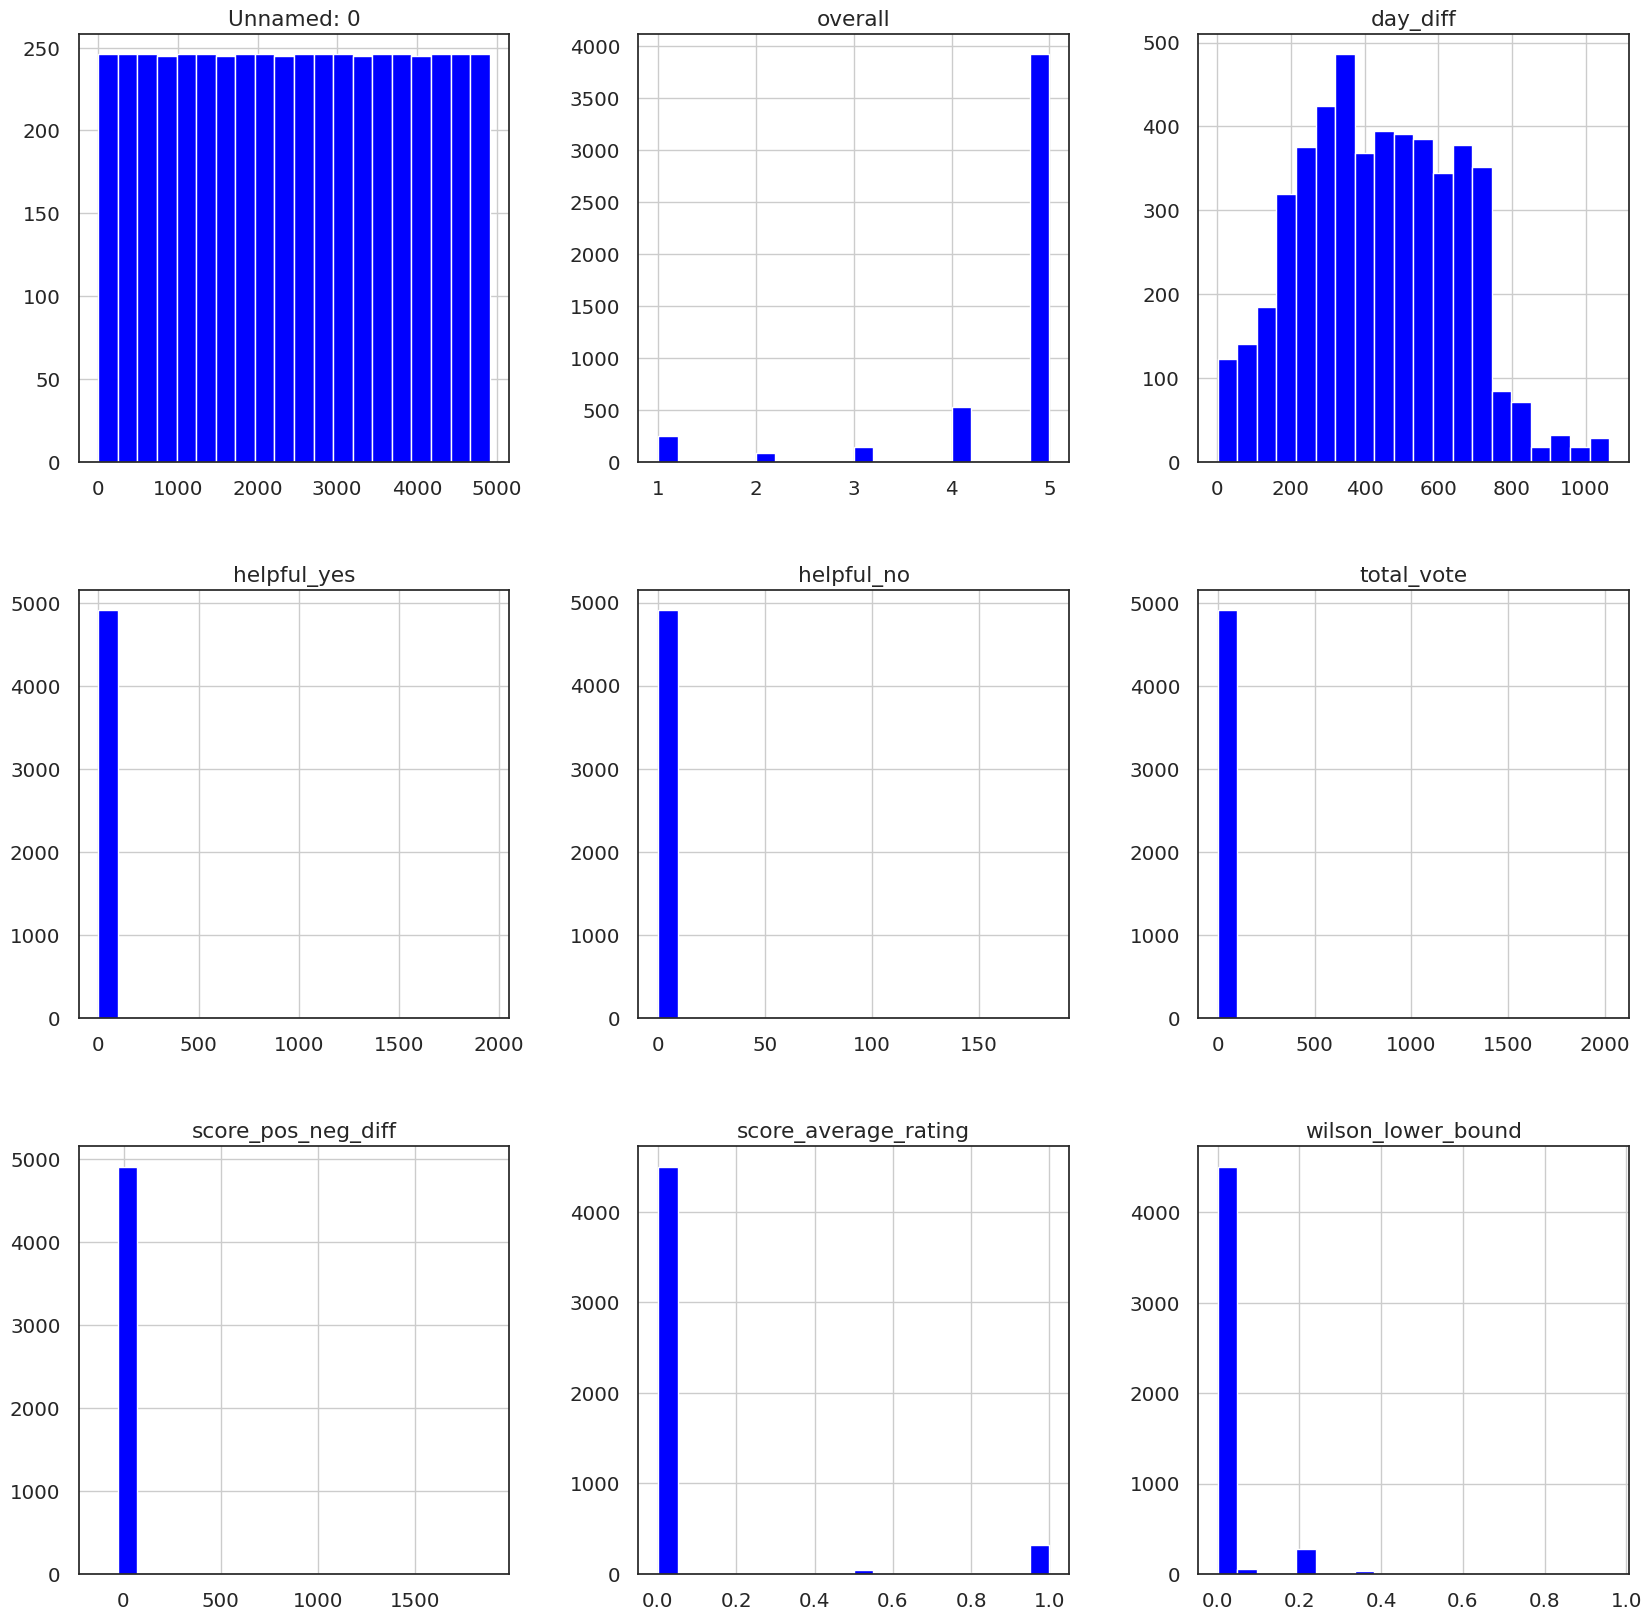

In [ ]:
# Set the aesthetic style and scaling of plots using Seaborn
sns.set(style = 'white', font_scale = 1.3, rc = {'figure.figsize':(20, 20)})
# style = 'white' sets a white background style for the plots
# font_scale = 1.3 increases the size of the font by a factor of 1.3
# rc={'figure.figsize':(20, 20)} sets the default figure size to 20x20 inches

# Create histograms for each numerical column.
ax = df.hist(bins = 20, color = 'blue')
# bins = 20 specifies that each histogram should have 20 bins
# color='blue' sets the color of the histograms to blue

*   The features have different ranges. We will handle this later.
*   Many histograms are skewed right. We will make these more Gaussian like later.

### Correlations

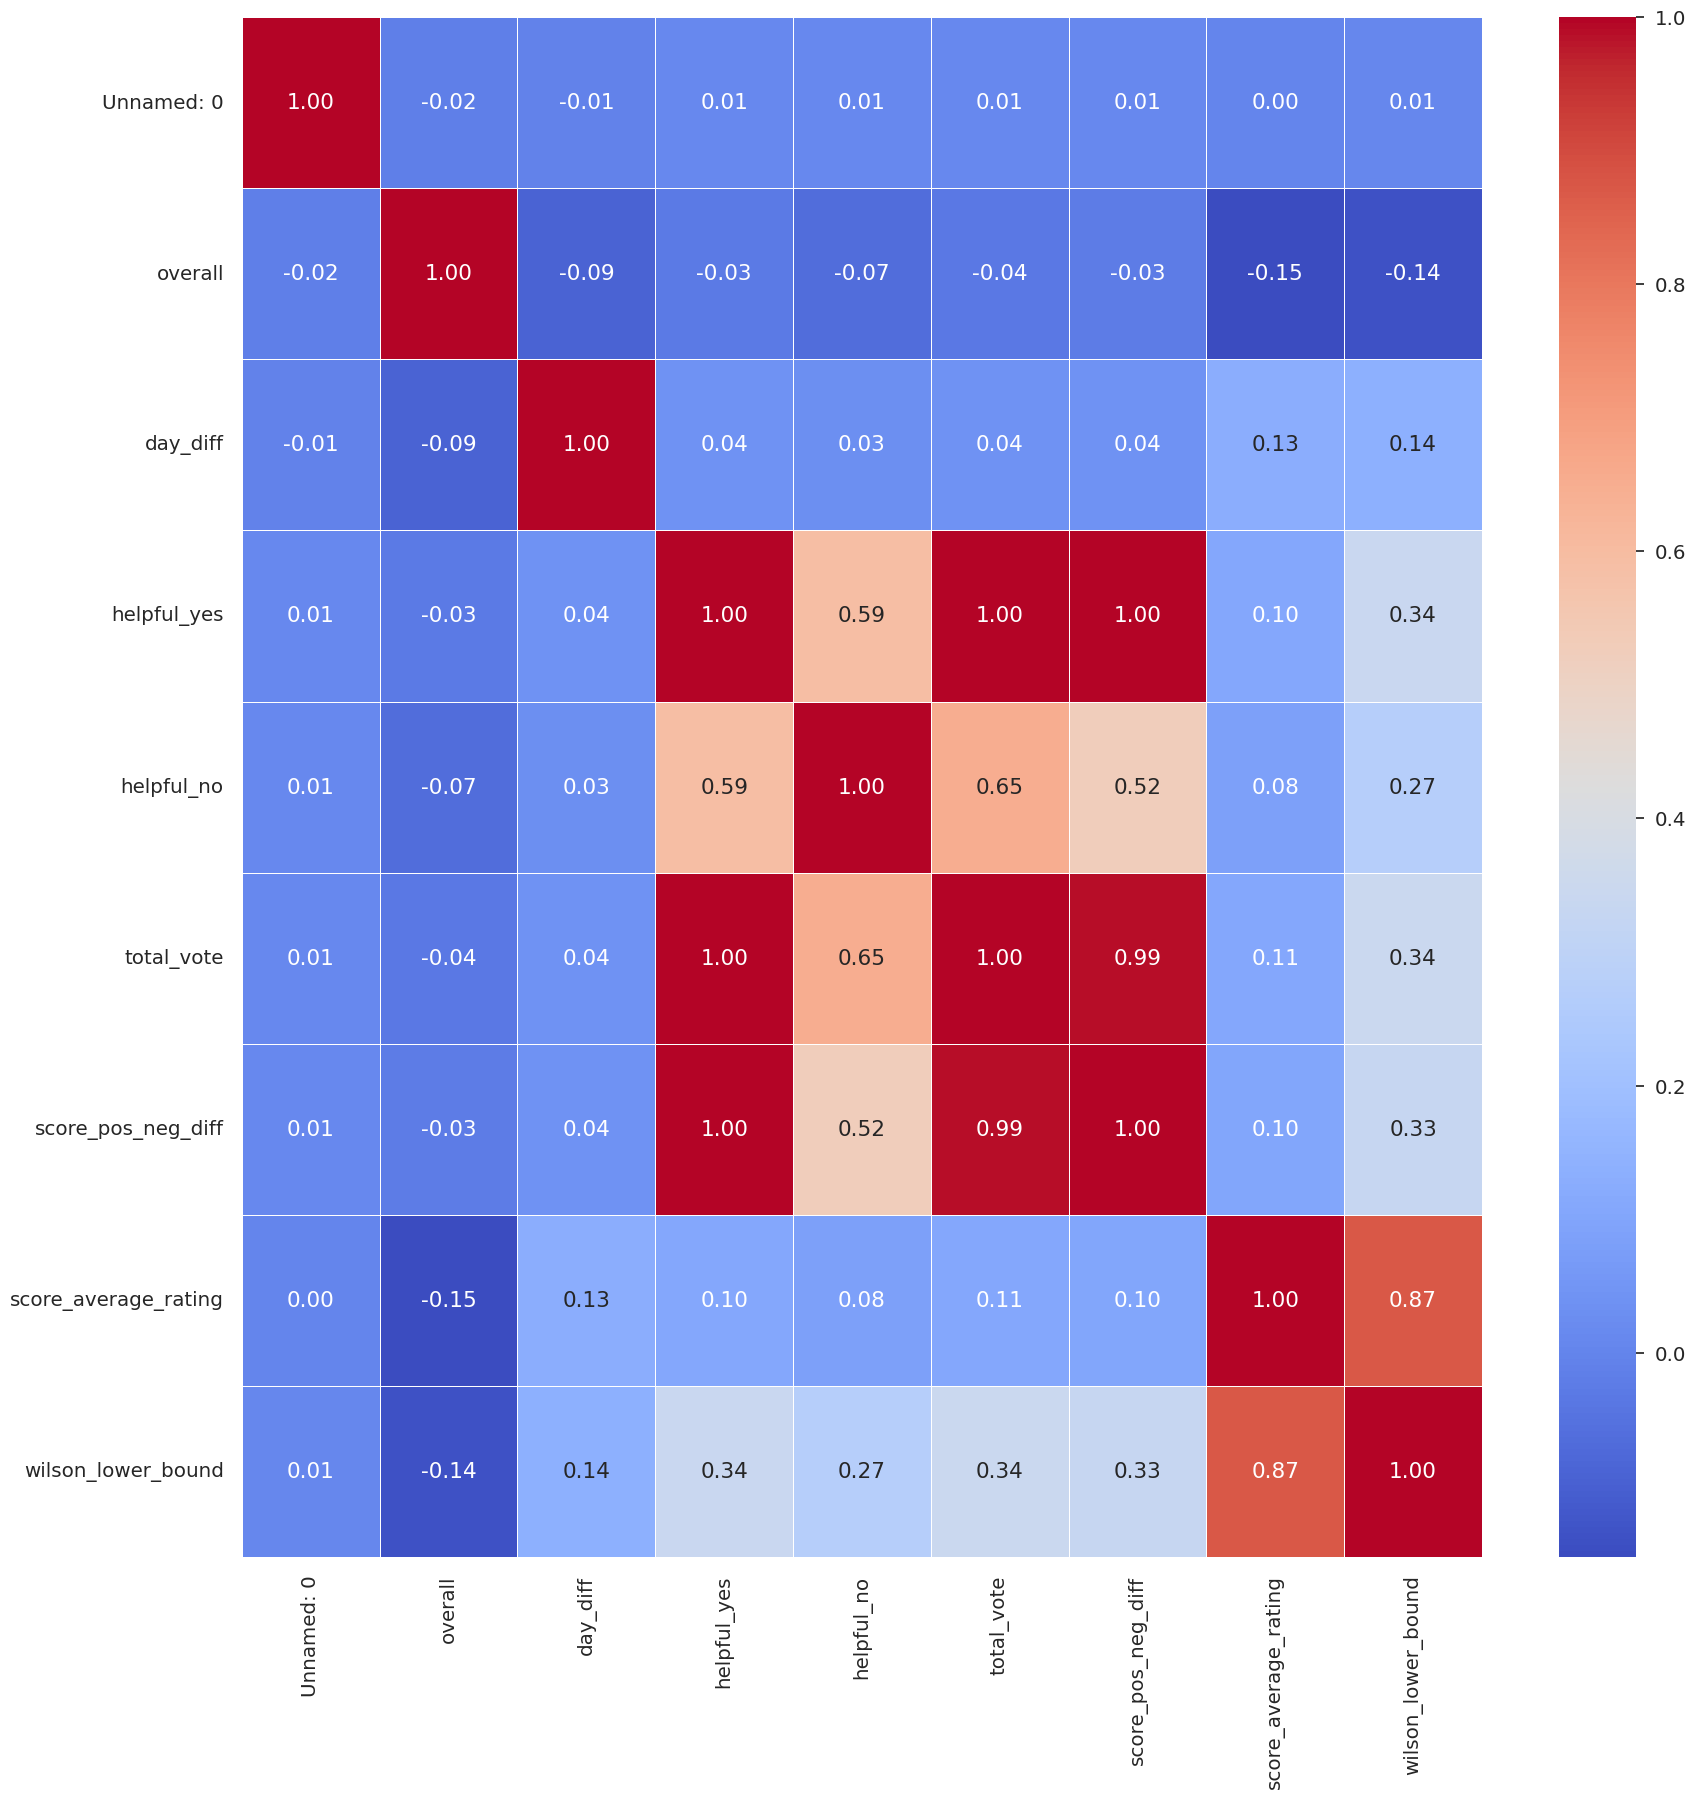

In [ ]:
# Create a heatmap to visualize the correlation matrix of the DataFrame 'df'
sns.heatmap(
    df.corr(numeric_only = True), # Calculate the correlation matrix, considering only numeric columns
    annot = True, # Annotate the heatmap with the correlation coefficients
    fmt = '.2f', # Format the annotations to two decimal places
    linewidths = 0.7, # Set the width of the lines that will divide each cell
    cmap = 'coolwarm' # Use the 'coolwarm' colormap for the heatmap
)
# The heatmap will show correlations between numerical columns, with colors indicating the strength and nature of the correlation

plt.show() # Display the heatmap

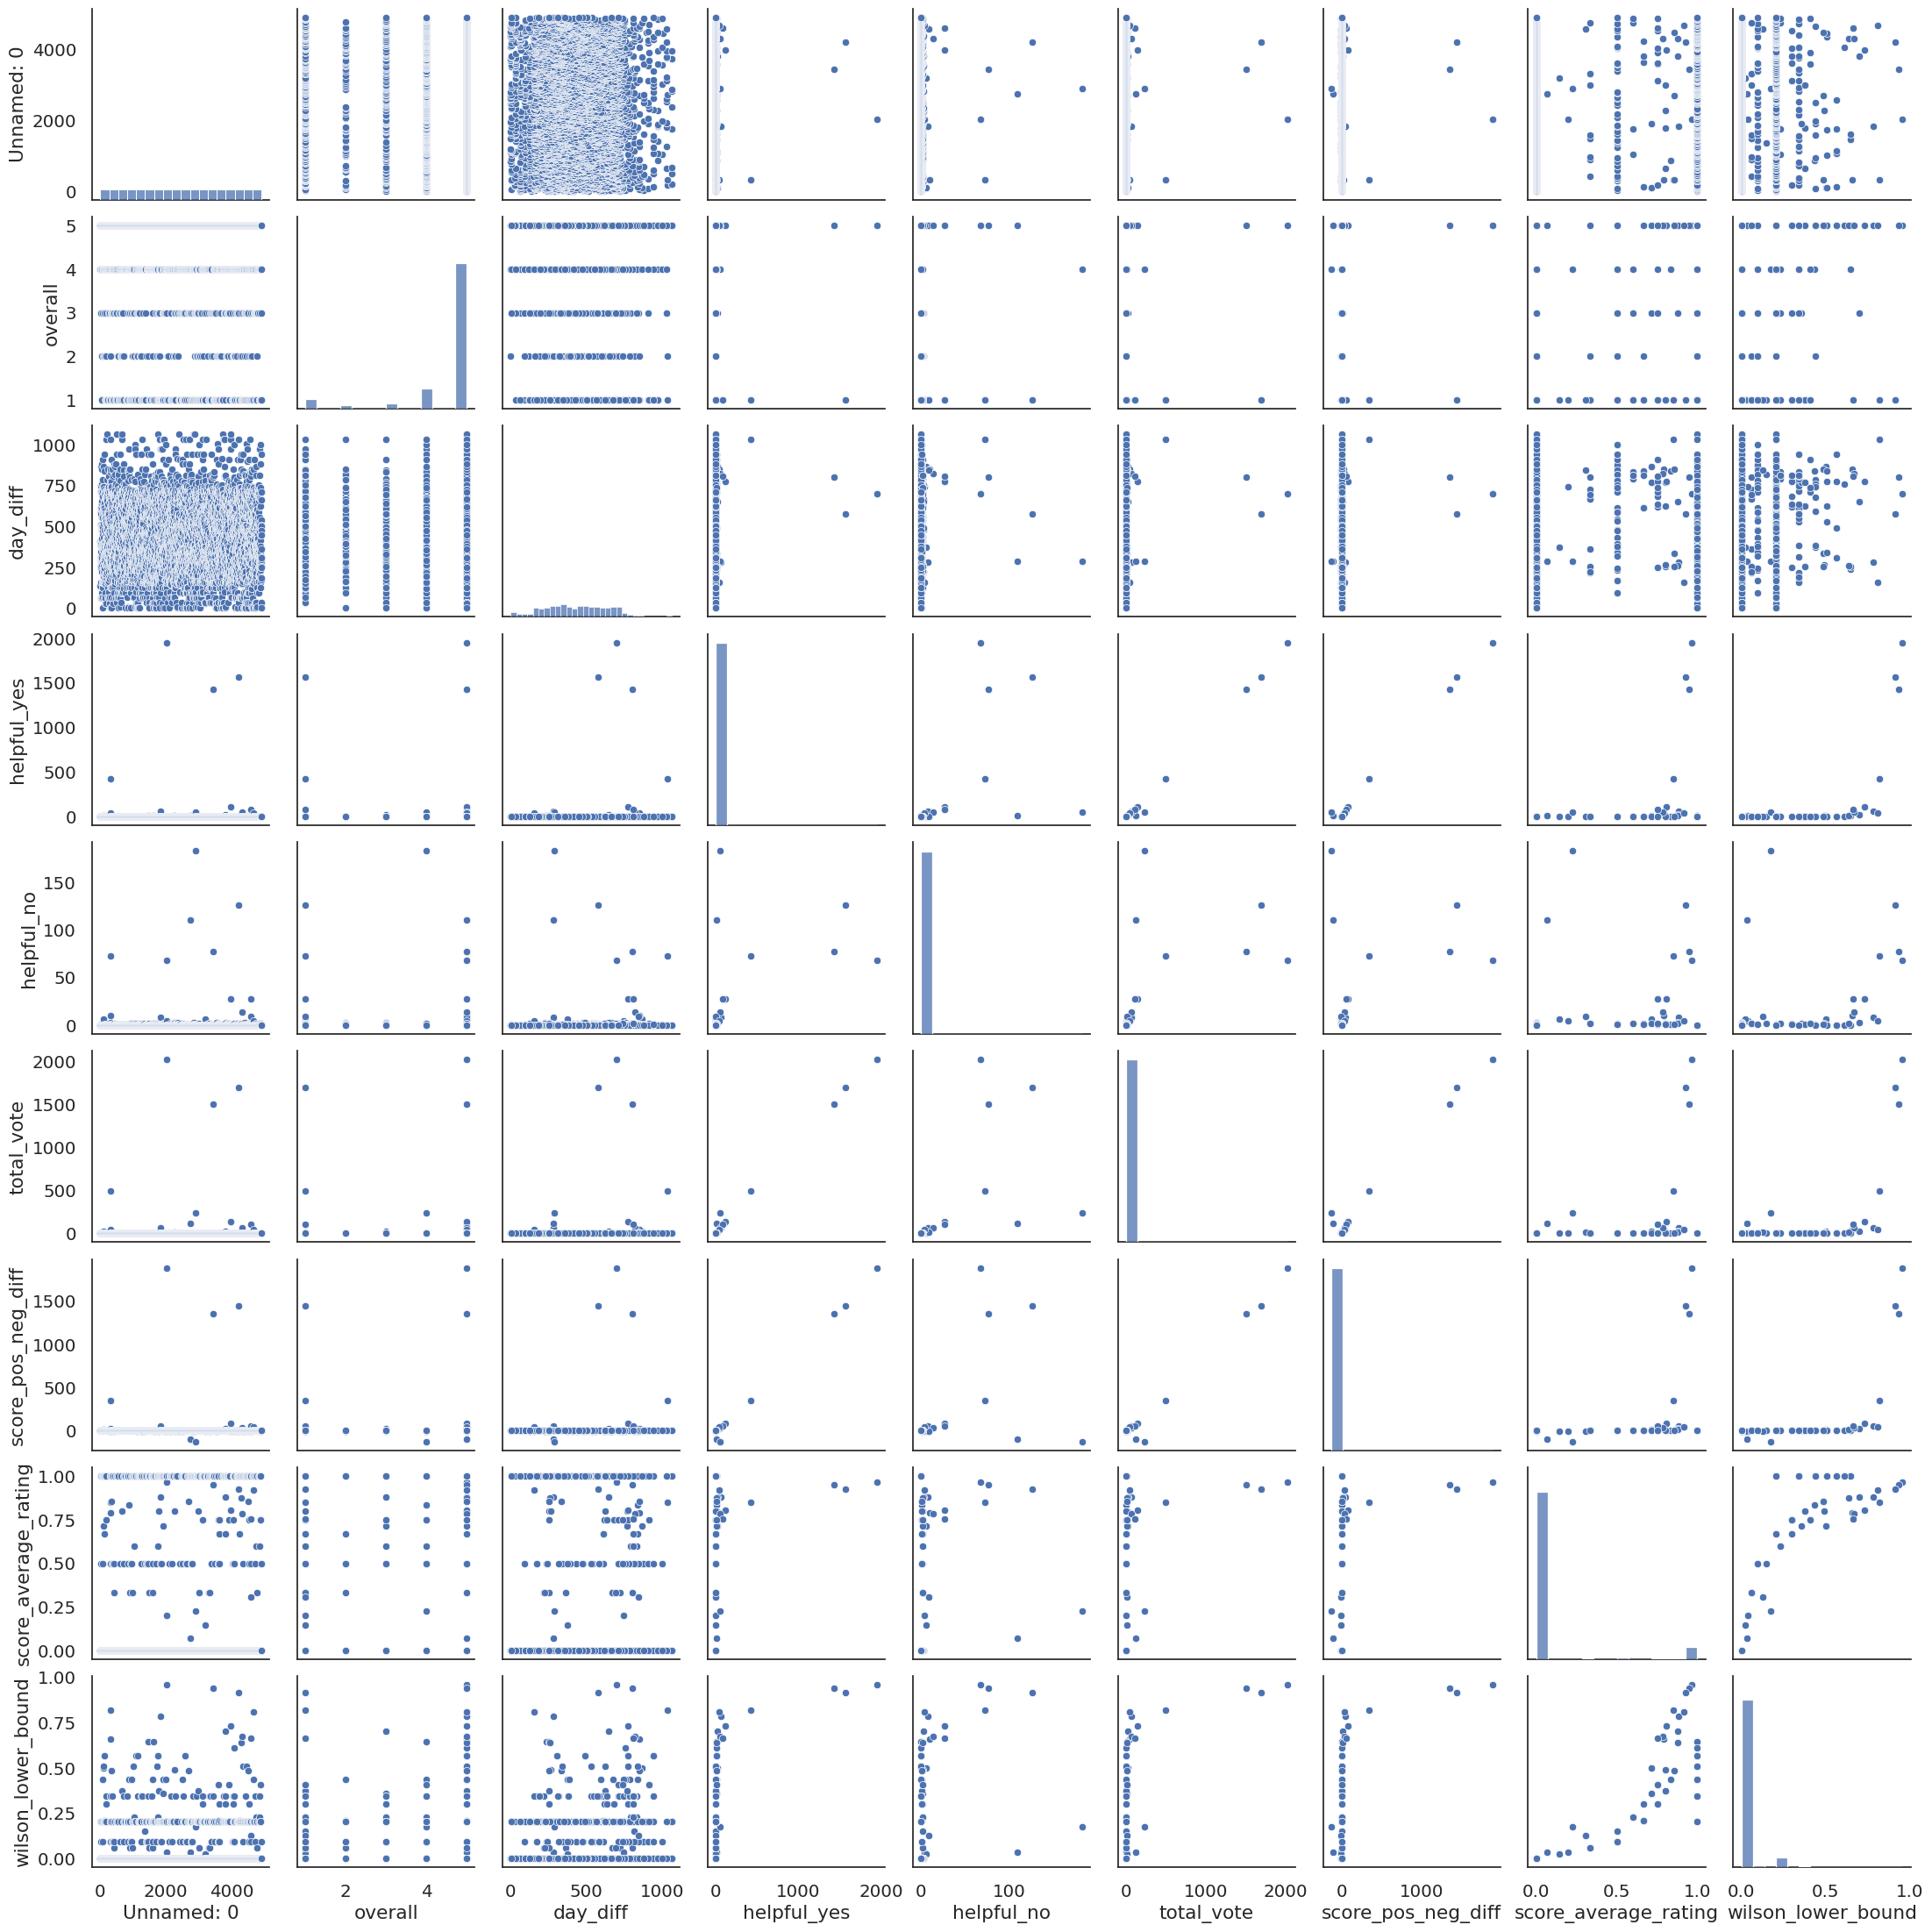

In [ ]:
# Create a default pair plot using Seaborn
sns.pairplot(df)
# sns.pairplot() creates a grid of Axes
# will be shared across the y-axes across a single row and the x-axes across a single column.
# The diagonal Axes are treated differently, drawing a plot to show the univariate distribution
# of the data for the variable in that column.

plt.show() # Display the pair plot

### Exploratory analysis report

The code below automatically creates an exploratory data analysis report. The report is output as an html file in the local files (see the files pane on the left.

For the final report/project I want to highlight specific aspects from the EDA document that justify our decisions below and code these explicitly. For example, if we use a parametric classifier that needs independent (non-correlated) predictors, I will show the correlation matrix in the notebook that gets published and comment on how much/little the predictors are correlated and how we are dealing with them.

In [ ]:
# Generate a profile report
pr = ProfileReport(df)

# Export the report to an HTML file named "EDA.html"
pr.to_file(output_file = 'EDA.html')
# The to_file() method is used to save the report.
# The report is saved as "EDA.html" in the current working directory.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Dataset has:

*   12 variables (8 numeric predictors and 4 categorical target/label)
*   4,915 observations
*   2 missing cells

#### Frequency of Overall

*   *5* = 79.8%
*   *4* = 10.7%
*   *3* = 2.9%
*   *2* = 1.6%
*   *1* = 5.0%

#### Correlations:

*   *helpful_yes* is highly correlated with *total_vote* + *score_pos_neg_diff* + *score_average_rating* + *wilson_lower_bound*
*   *helpful_no* is highly correlated with *total_vote*
*   *total_vote* is highly correlated with *helpful_yes* + *helpful_no* + *score_average_rating* + *wilson_lower_bound*
*   *score_pos_neg_diff* is highly correlated with *helpful_yes* + *score_average_rating* + *wilson_lower_bound*
*   *score_average_rating* is highly correlated with *helpful_yes* + *total_vote*  + *score_pos_neg_diff* + *wilson_lower_bound*
*   *wilson_lower_bound* is highly correlated with *helpful_yes* + *total_vote*  + *score_pos_neg_diff* + *score_average_rating*

for now leaving, but revisit for fine tuning if I am getting poor performance

#### Duplicate rows:

there are no number of duplicate rows.

#### Missing Values:

*   *reviewName* has 1 missing value.
*   *reviewerText* has 1 missing value.

### Imbalanced dataset

I also need to take into consideration the sampling method because we have imbalanced classes

*   under/over sample
*   stratified sampling
*   etc

The numpy random seed is a numerical value that generates a new set or repeats pseudo-random numbers. The value in the numpy random seed saves the state of randomness. If I call the seed function using value 1 multiple times, the computer displays the same random numbers.

## Data Preparation

### Data Cleaning

Here I make our data cleaning decisions.

*   Do outlier/anomaly analysis here. Since the dataset has lower number of observations, opt for solutions that retain as much data as possible (e.g. capping the data as opposed to removing rows).
*   Remove rows with missing data.
*   Make decisions about transformations etc here.

### Outlier analysis
Two options:
1.   When lots of observations in dataset and only a few rows with outlier values (for any column), just remove rows containing outliers.
2.   When fewer observations and more rows containing outlier values, cap the values at the IQR (interquartile range).

Unnamed: 0


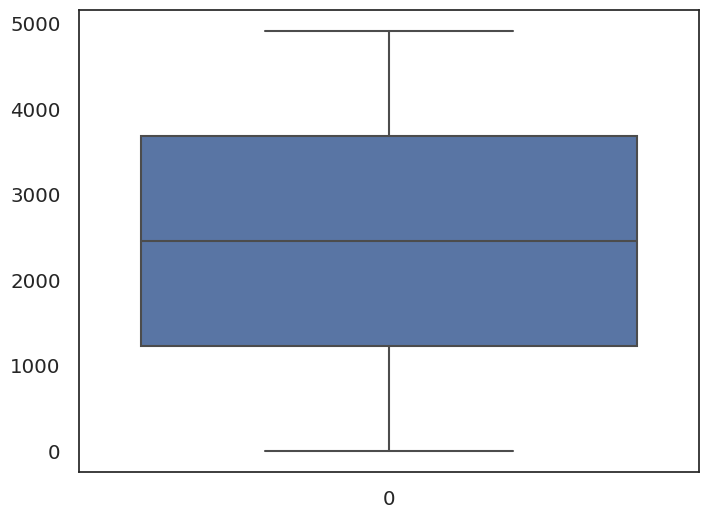

overall


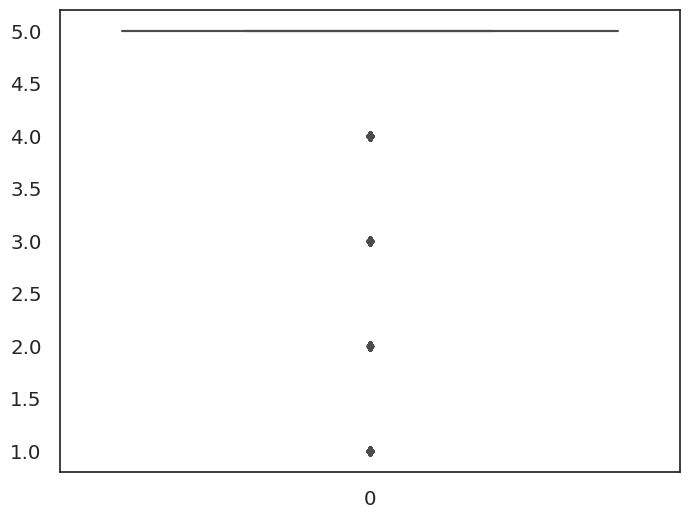

day_diff


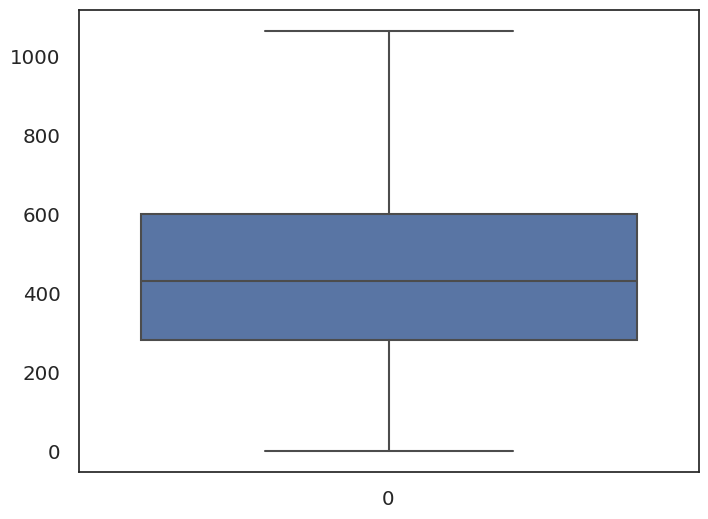

helpful_yes


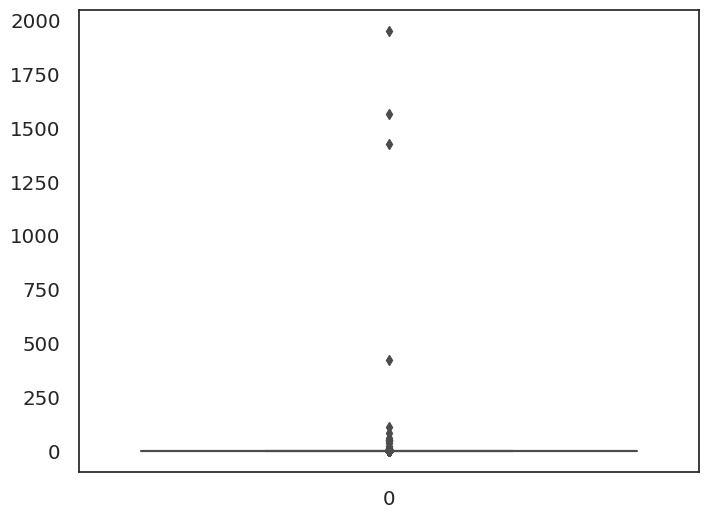

helpful_no


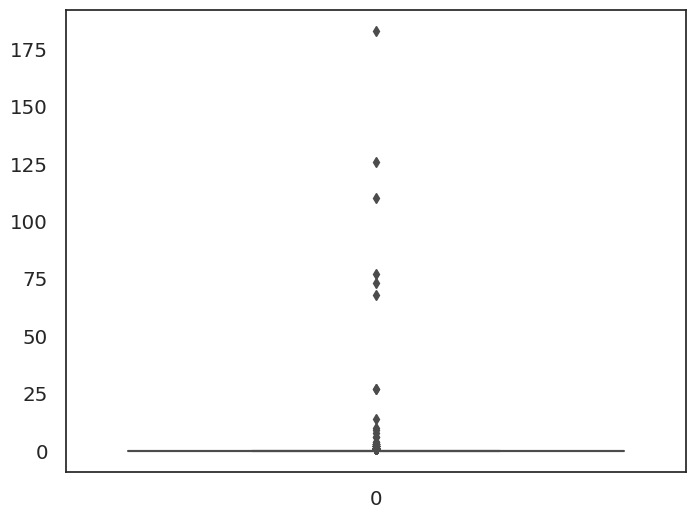

total_vote


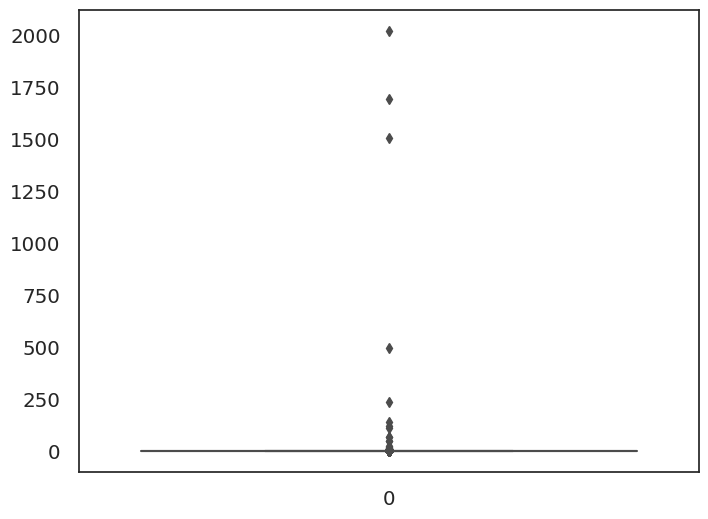

score_pos_neg_diff


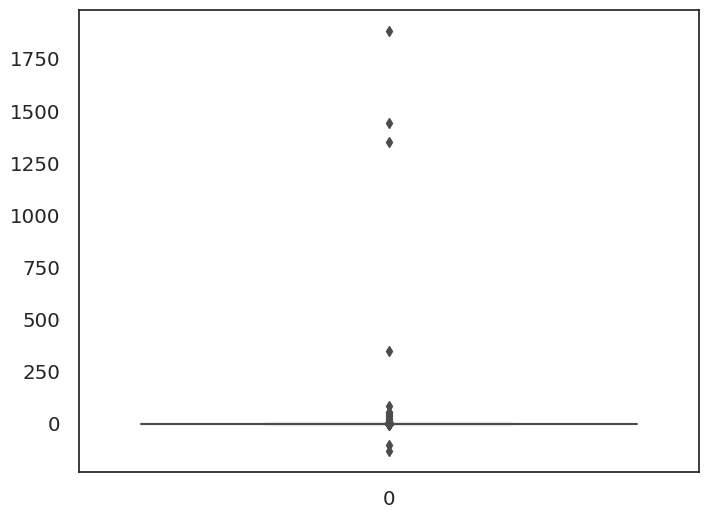

score_average_rating


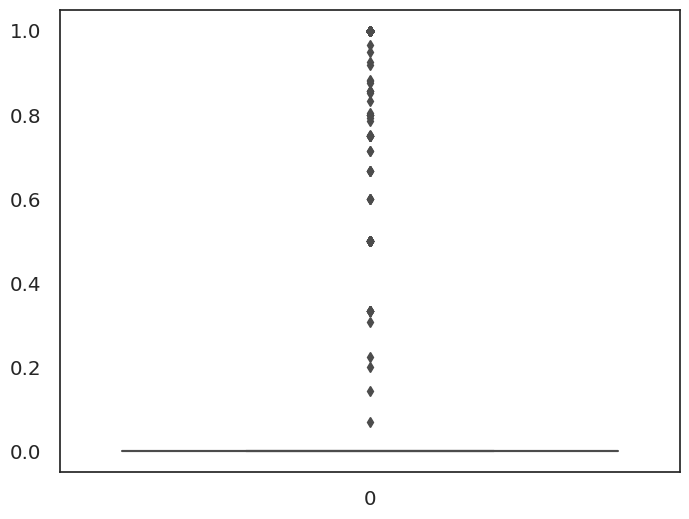

In [ ]:
# Outlier analysis

# First, we define the data types that are considered numeric.
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# We then extract the column names of the dataframe 'reviews'
# that have the specified numeric data types and store them in 'cols'.
cols = list(df.select_dtypes(include = numerics))

# Now, we iterate through each numeric column, except the last one.
# The '-1' in 'cols[0:-1]' ensures the last column is excluded.
for col in cols[0:-1]:
  print(col) # Printing the column name for reference.

  # Create a new figure for the boxplot. This ensures each boxplot is
  # displayed in a separate figure.
  plt.figure(figsize = (8, 6))

  # Generating a boxplot for the current column.
  # Boxplots are useful for visualizing outliers in the data.
  sns.boxplot(df[col])

  # Display the plot.
  plt.show()

The outliers may be meaningful to my investigation, so it doesn't make sense to remove or cap.

https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

For now, I'm not doing anything.

### Drop unnecessary columns
Remove 1 columns:

*   *Unnamed: 0*: This just the index or row number

In [ ]:
df = df.drop(['Unnamed: 0'], axis = 1)

### Remove rows with missing data

There are only 1 missing value. I just remove the row with the missing value. I ignore reviewerName because I consider it irrelevant and are going to drop the entire column.

In [ ]:
# Check if Dataset has any nulls
df.isnull().any().any()

True

In [ ]:
# Display count of nulls in every column
df.isna().sum()

reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

In [ ]:
# Before removal
df.shape

(4915, 11)

In [ ]:
# Drop rows with any empty cells in column reviewerName
df.dropna(
    axis = 0,
    how = 'any',
    subset = ['reviewerName'],
    inplace = True
)

In [ ]:
# Drop rows with any empty cells in column reviewText
df.dropna(
    axis = 0,
    how = 'any',
    subset = ['reviewText'],
    inplace = True
)

In [ ]:
# After removal
df.shape

(4913, 11)

The number of rows has decreased from 4,915 to 4,913 therefore 2 rows were succesfully deleted.

In [ ]:
# Check if Dataset has any nulls
df.isnull().any().any()

False

### Clean 'reviews'

*   remove HTML tags
*   remove contractions
*   remove special characters
*   convert to lower case
*   perform tokenization
*   remove stop words
*   remove punctuation
*   perform Lemmatization

In [ ]:
# Clean reviewText
df['reviewText_clean'] = df["reviewText"].map(lambda x: cleanData(x))

<ipython-input-2-f8d0a0197e7a>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  doc = BeautifulSoup(doc).get_text() # remove HTML tags


In [ ]:
# View the first 5 rows
df.head()

reviewerName  overall                                         reviewText  \
1          0mie      5.0  Purchased this for my device, it worked as adv...   
2           1K3      4.0  it works as expected. I should have sprung for...   
3           1m2      5.0  This think has worked out great.Had a diff. br...   
4  2&amp;1/2Men      5.0  Bought it with Retail Packaging, arrived legit...   
5       2Cents!      5.0  It's mini storage.  It doesn't do anything els...   

   reviewTime  day_diff  helpful_yes  helpful_no  total_vote  \
1  2013-10-25       409            0           0           0   
2  2012-12-23       715            0           0           0   
3  2013-11-21       382            0           0           0   
4  2013-07-13       513            0           0           0   
5  2013-04-29       588            0           0           0   

   score_pos_neg_diff  score_average_rating  wilson_lower_bound  \
1                   0                   0.0                 0.0   
2                   0                   0.0                 0.0   
3                   0                   0.0                 0.0   
4                   0                   0.0                 0.0   
5                   0                   0.0                 0.0   

                                    reviewText_clean  
1  purchase device work advertised phone memory d...  
2  work expect spring high capacity think bit che...  
3  think work great.had different bran 64 gb card...  
4  buy retail packaging arrive legit orange envel...  
5  mini storage suppose purchase add additional s...

### Feature Engineering

#### Create 'sentiment' column

In [ ]:
# Applying the function in our new column
df['sentiment'] = df.apply(get_sentiment, axis = 1)

In [ ]:
# View the first 5 rows
df.head()

reviewerName  overall                                         reviewText  \
1          0mie      5.0  Purchased this for my device, it worked as adv...   
2           1K3      4.0  it works as expected. I should have sprung for...   
3           1m2      5.0  This think has worked out great.Had a diff. br...   
4  2&amp;1/2Men      5.0  Bought it with Retail Packaging, arrived legit...   
5       2Cents!      5.0  It's mini storage.  It doesn't do anything els...   

   reviewTime  day_diff  helpful_yes  helpful_no  total_vote  \
1  2013-10-25       409            0           0           0   
2  2012-12-23       715            0           0           0   
3  2013-11-21       382            0           0           0   
4  2013-07-13       513            0           0           0   
5  2013-04-29       588            0           0           0   

   score_pos_neg_diff  score_average_rating  wilson_lower_bound  \
1                   0                   0.0                 0.0   
2                   0                   0.0                 0.0   
3                   0                   0.0                 0.0   
4                   0                   0.0                 0.0   
5                   0                   0.0                 0.0   

                                    reviewText_clean  sentiment  
1  purchase device work advertised phone memory d...          2  
2  work expect spring high capacity think bit che...          2  
3  think work great.had different bran 64 gb card...          2  
4  buy retail packaging arrive legit orange envel...          2  
5  mini storage suppose purchase add additional s...          2

In [ ]:
# Count the frequency of each unique value in the 'sentiment' column.
df['sentiment'].value_counts()
df['sentiment'].value_counts()

2    4447
0     324
1     142
Name: sentiment, dtype: int64

I now have the following counts:

*   Negative: 324
*   Neutral: 142
*   Positive: 4,447

<Axes: xlabel='sentiment', ylabel='count'>

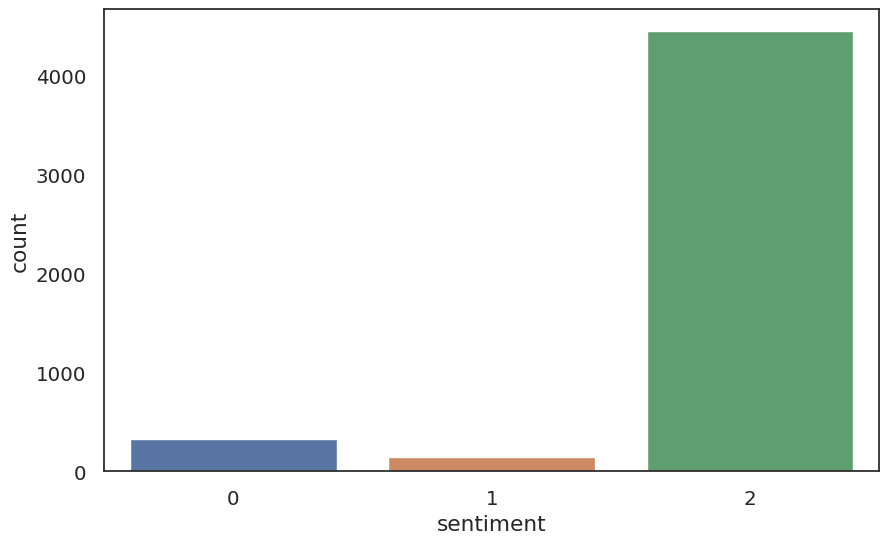

In [ ]:
# Define the order of categories for sentiment.
sentiment_order = [0, 1, 2]

# Set the size of the plot using plt.figure and the figsize attribute.
# For example, setting the width to 10 inches and height to 6 inches.
plt.figure(figsize = (10, 6))

# Create a count plot for the 'sentiment' column in the dataframe.
# A count plot is used to show the counts of observations in each categorical bin using bars.
# The 'x' parameter specifies the column in the DataFrame for which the count plot is to be drawn.
# The 'data' parameter is set to the DataFrame 'reviews' which contains the relevant data.
# The 'order' parameter is set to the 'sentiment_order' list defined above.
# This ensures that the sentiments are displayed in the specified order (0, 1, 2) on the x-axis.
sns.countplot(x = 'sentiment', data = df, order = sentiment_order)

#### Creating 'year', 'month' and 'day' columns

I parse out  the year, month and day out of reviewTime string.

In [ ]:
# Dataset before parsing out date into separate columns
df.head()

reviewerName  overall                                         reviewText  \
1          0mie      5.0  Purchased this for my device, it worked as adv...   
2           1K3      4.0  it works as expected. I should have sprung for...   
3           1m2      5.0  This think has worked out great.Had a diff. br...   
4  2&amp;1/2Men      5.0  Bought it with Retail Packaging, arrived legit...   
5       2Cents!      5.0  It's mini storage.  It doesn't do anything els...   

   reviewTime  day_diff  helpful_yes  helpful_no  total_vote  \
1  2013-10-25       409            0           0           0   
2  2012-12-23       715            0           0           0   
3  2013-11-21       382            0           0           0   
4  2013-07-13       513            0           0           0   
5  2013-04-29       588            0           0           0   

   score_pos_neg_diff  score_average_rating  wilson_lower_bound  \
1                   0                   0.0                 0.0   
2                   0                   0.0                 0.0   
3                   0                   0.0                 0.0   
4                   0                   0.0                 0.0   
5                   0                   0.0                 0.0   

                                    reviewText_clean  sentiment  
1  purchase device work advertised phone memory d...          2  
2  work expect spring high capacity think bit che...          2  
3  think work great.had different bran 64 gb card...          2  
4  buy retail packaging arrive legit orange envel...          2  
5  mini storage suppose purchase add additional s...          2

In [ ]:
# new data frame which has date and year
new = df['reviewTime'].str.split('-', expand = True)

# Convert the split strings to integers
new[0] = new[0].astype(int)  # Convert year
new[1] = new[1].astype(int)  # Convert month
new[2] = new[2].astype(int)  # Convert day

# Making separate year, month, and day columns from new data frame
df["reviewTime_year"] = new[0]
df["reviewTime_month"] = new[1]
df["reviewTime_day"] = new[2]

In [ ]:
# Dataset after parsing out date into separate columns
df = df.drop(['reviewTime'], axis = 1)
df.head()

reviewerName  overall                                         reviewText  \
1          0mie      5.0  Purchased this for my device, it worked as adv...   
2           1K3      4.0  it works as expected. I should have sprung for...   
3           1m2      5.0  This think has worked out great.Had a diff. br...   
4  2&amp;1/2Men      5.0  Bought it with Retail Packaging, arrived legit...   
5       2Cents!      5.0  It's mini storage.  It doesn't do anything els...   

   day_diff  helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
1       409            0           0           0                   0   
2       715            0           0           0                   0   
3       382            0           0           0                   0   
4       513            0           0           0                   0   
5       588            0           0           0                   0   

   score_average_rating  wilson_lower_bound  \
1                   0.0                 0.0   
2                   0.0                 0.0   
3                   0.0                 0.0   
4                   0.0                 0.0   
5                   0.0                 0.0   

                                    reviewText_clean  sentiment  \
1  purchase device work advertised phone memory d...          2   
2  work expect spring high capacity think bit che...          2   
3  think work great.had different bran 64 gb card...          2   
4  buy retail packaging arrive legit orange envel...          2   
5  mini storage suppose purchase add additional s...          2   

   reviewTime_year  reviewTime_month  reviewTime_day  
1             2013                10              25  
2             2012                12              23  
3             2013                11              21  
4             2013                 7              13  
5             2013                 4              29

#### Creating 'polarity' column

I used Textblob for for figuring out the rate of sentiment. The sentiment function of textblob returns two properties, polarity, and subjectivity. Polarity is float which lies in the range of [-1, 1] where 1 means positive statement and -1 means a negative statement.

In [ ]:
df['polarity'] = df['reviewText'].map(lambda text: TextBlob(text).sentiment.polarity)

#### Creating 'vader_polarity' column

VADER (Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

In [ ]:
# Create function to use Vader to detect sentiment
analyzer = SentimentIntensityAnalyzer()

df['vader_polarity'] = df['reviewText'].map(lambda text: vader_sentiment(text))

#### Creating 'review_len' column

The length of the review which includes each letters and spaces

In [ ]:
df['review_len'] = df['reviewText'].astype(str).apply(len)

  #### Creating 'word_count' column
  
  This measures how many words are there in review

In [ ]:
df.head()

reviewerName  overall                                         reviewText  \
1          0mie      5.0  Purchased this for my device, it worked as adv...   
2           1K3      4.0  it works as expected. I should have sprung for...   
3           1m2      5.0  This think has worked out great.Had a diff. br...   
4  2&amp;1/2Men      5.0  Bought it with Retail Packaging, arrived legit...   
5       2Cents!      5.0  It's mini storage.  It doesn't do anything els...   

   day_diff  helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
1       409            0           0           0                   0   
2       715            0           0           0                   0   
3       382            0           0           0                   0   
4       513            0           0           0                   0   
5       588            0           0           0                   0   

   score_average_rating  wilson_lower_bound  \
1                   0.0                 0.0   
2                   0.0                 0.0   
3                   0.0                 0.0   
4                   0.0                 0.0   
5                   0.0                 0.0   

                                    reviewText_clean  sentiment  \
1  purchase device work advertised phone memory d...          2   
2  work expect spring high capacity think bit che...          2   
3  think work great.had different bran 64 gb card...          2   
4  buy retail packaging arrive legit orange envel...          2   
5  mini storage suppose purchase add additional s...          2   

   reviewTime_year  reviewTime_month  reviewTime_day  polarity  \
1             2013                10              25  0.200000   
2             2012                12              23  0.129167   
3             2013                11              21  0.000000   
4             2013                 7              13  0.386667   
5             2013                 4              29 -0.025000   

   vader_polarity  review_len  
1         -0.2960         158  
2         -0.3089         166  
3          0.7081         340  
4          0.7087         290  
5          0.0000         282

### Feature Reduction

#### Drop overall

In [ ]:
df = df.drop(["overall"], axis = 1)

#### Drop reviewText

In [ ]:
df = df.drop(["reviewText"], axis = 1)

#### Drop features with high correlation ( > 0.95)

**helpful_yes** is highly correlated with:

*   **score_pos_neg_diff**: correlation=1.0
*   **total_vote**: correlation=1.0

We can drop both score_pos_neg_diff and total_vote.

In [ ]:
df = df.drop(['score_pos_neg_diff'], axis = 1)

In [ ]:
df = df.drop(["total_vote"], axis = 1)

#### Drop ReviewerName

**ReviewerName** doesn't appear to be significant so it can be dropped.

In [ ]:
df.groupby('reviewerName').size().sort_values(ascending = False).head(10)

reviewerName
Amazon Customer    121
David               10
Michael              9
Chris                8
John                 7
Mike                 7
Jim                  6
Mark                 6
Brandon              6
Eric                 6
dtype: int64

In [ ]:
df = df.drop(['reviewerName'], axis = 1)

### Insights

#### Length of Review by Sentiment

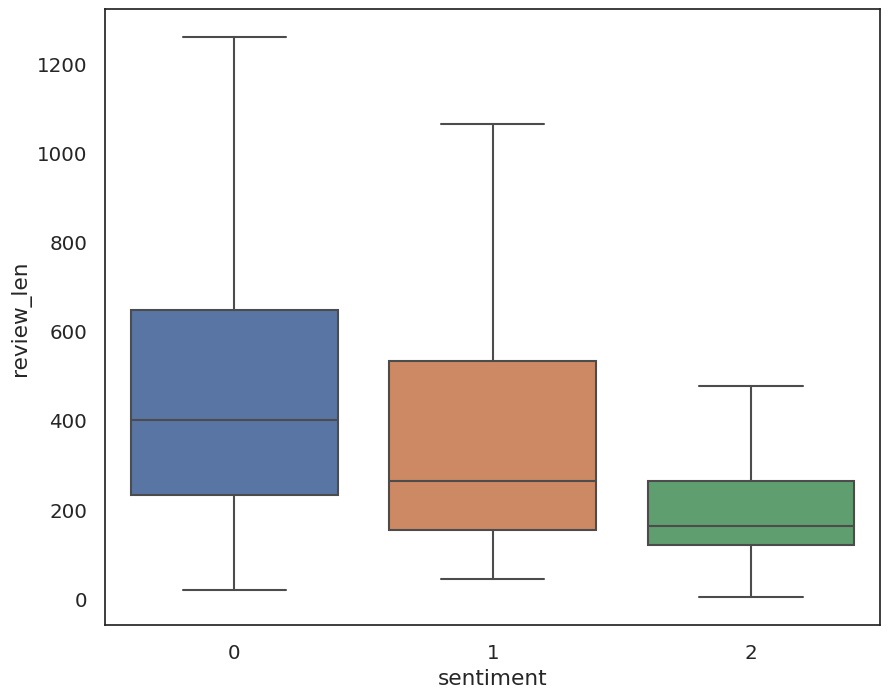

In [ ]:
# Set the size of the plot using plt.figure and the figsize attribute.
# For example, setting the width to 10 inches and height to 8 inches.
plt.figure(figsize = (10, 8))

# Create a boxplot comparing 'sentiment' and 'review_len'.
# The 'showfliers = False' parameter hides outliers for a cleaner plot.
sns.boxplot(x = 'sentiment', y = 'review_len', data = df, showfliers = False)

# Display the plot.
plt.show()

The length of a review is longer for negative reviews.

#### Polarity by Sentiment

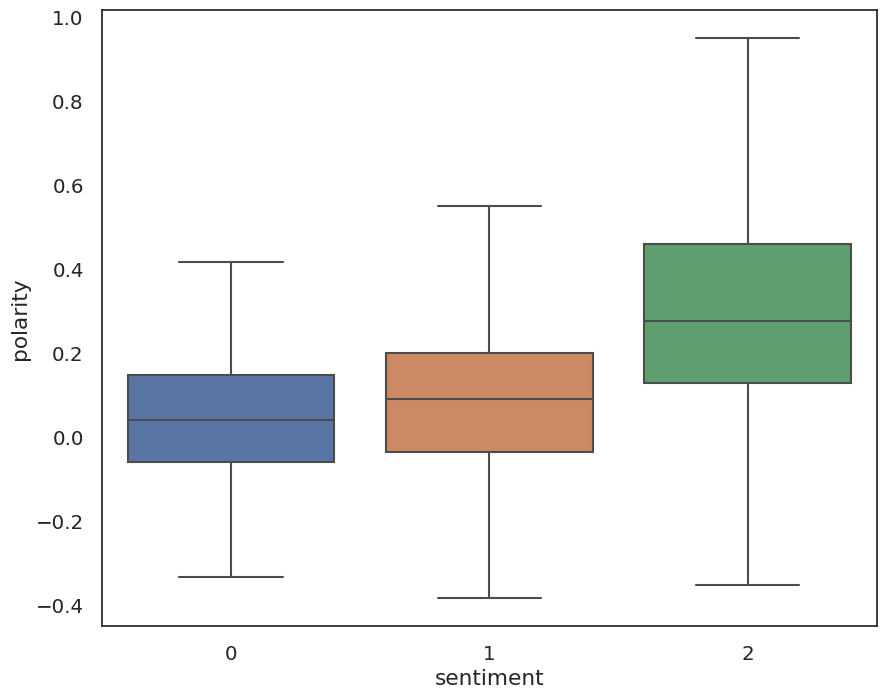

In [ ]:
# Set the size of the plot using plt.figure and the figsize attribute.
# For example, setting the width to 10 inches and height to 8 inches.
plt.figure(figsize = (10, 8))

# Create a boxplot comparing 'sentiment' and 'polarity'.
# The 'showfliers = False' parameter hides outliers for a cleaner plot.
sns.boxplot(x = 'sentiment', y = 'polarity', data = df, showfliers = False)
plt.show()

The polarity for positive reviews is higher for positive reviews.

#### Polarity by Vader Sentiment

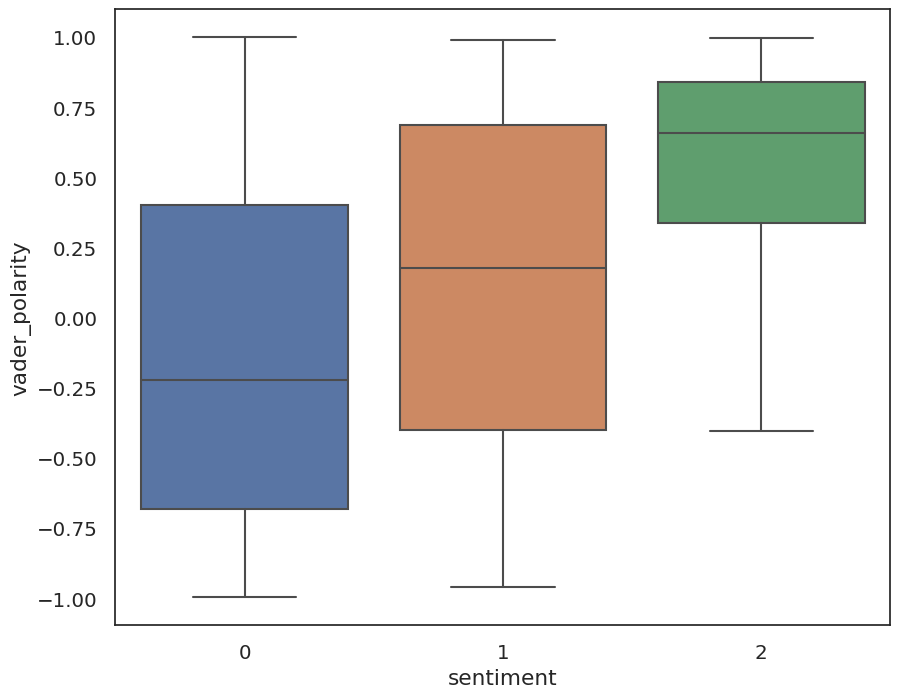

In [ ]:
# Set the size of the plot using plt.figure and the figsize attribute.
# For example, setting the width to 10 inches and height to 8 inches.
plt.figure(figsize = (10, 8))

# Create a boxplot comparing 'sentiment' and 'vader_polarity'.
# The 'showfliers = False' parameter hides outliers for a cleaner plot.
sns.boxplot(x = 'sentiment',y = 'vader_polarity', data = df, showfliers = False)
plt.show()

The vader polarity for positive reviews is higher for positive reviews.

<Figure size 1000x800 with 0 Axes>

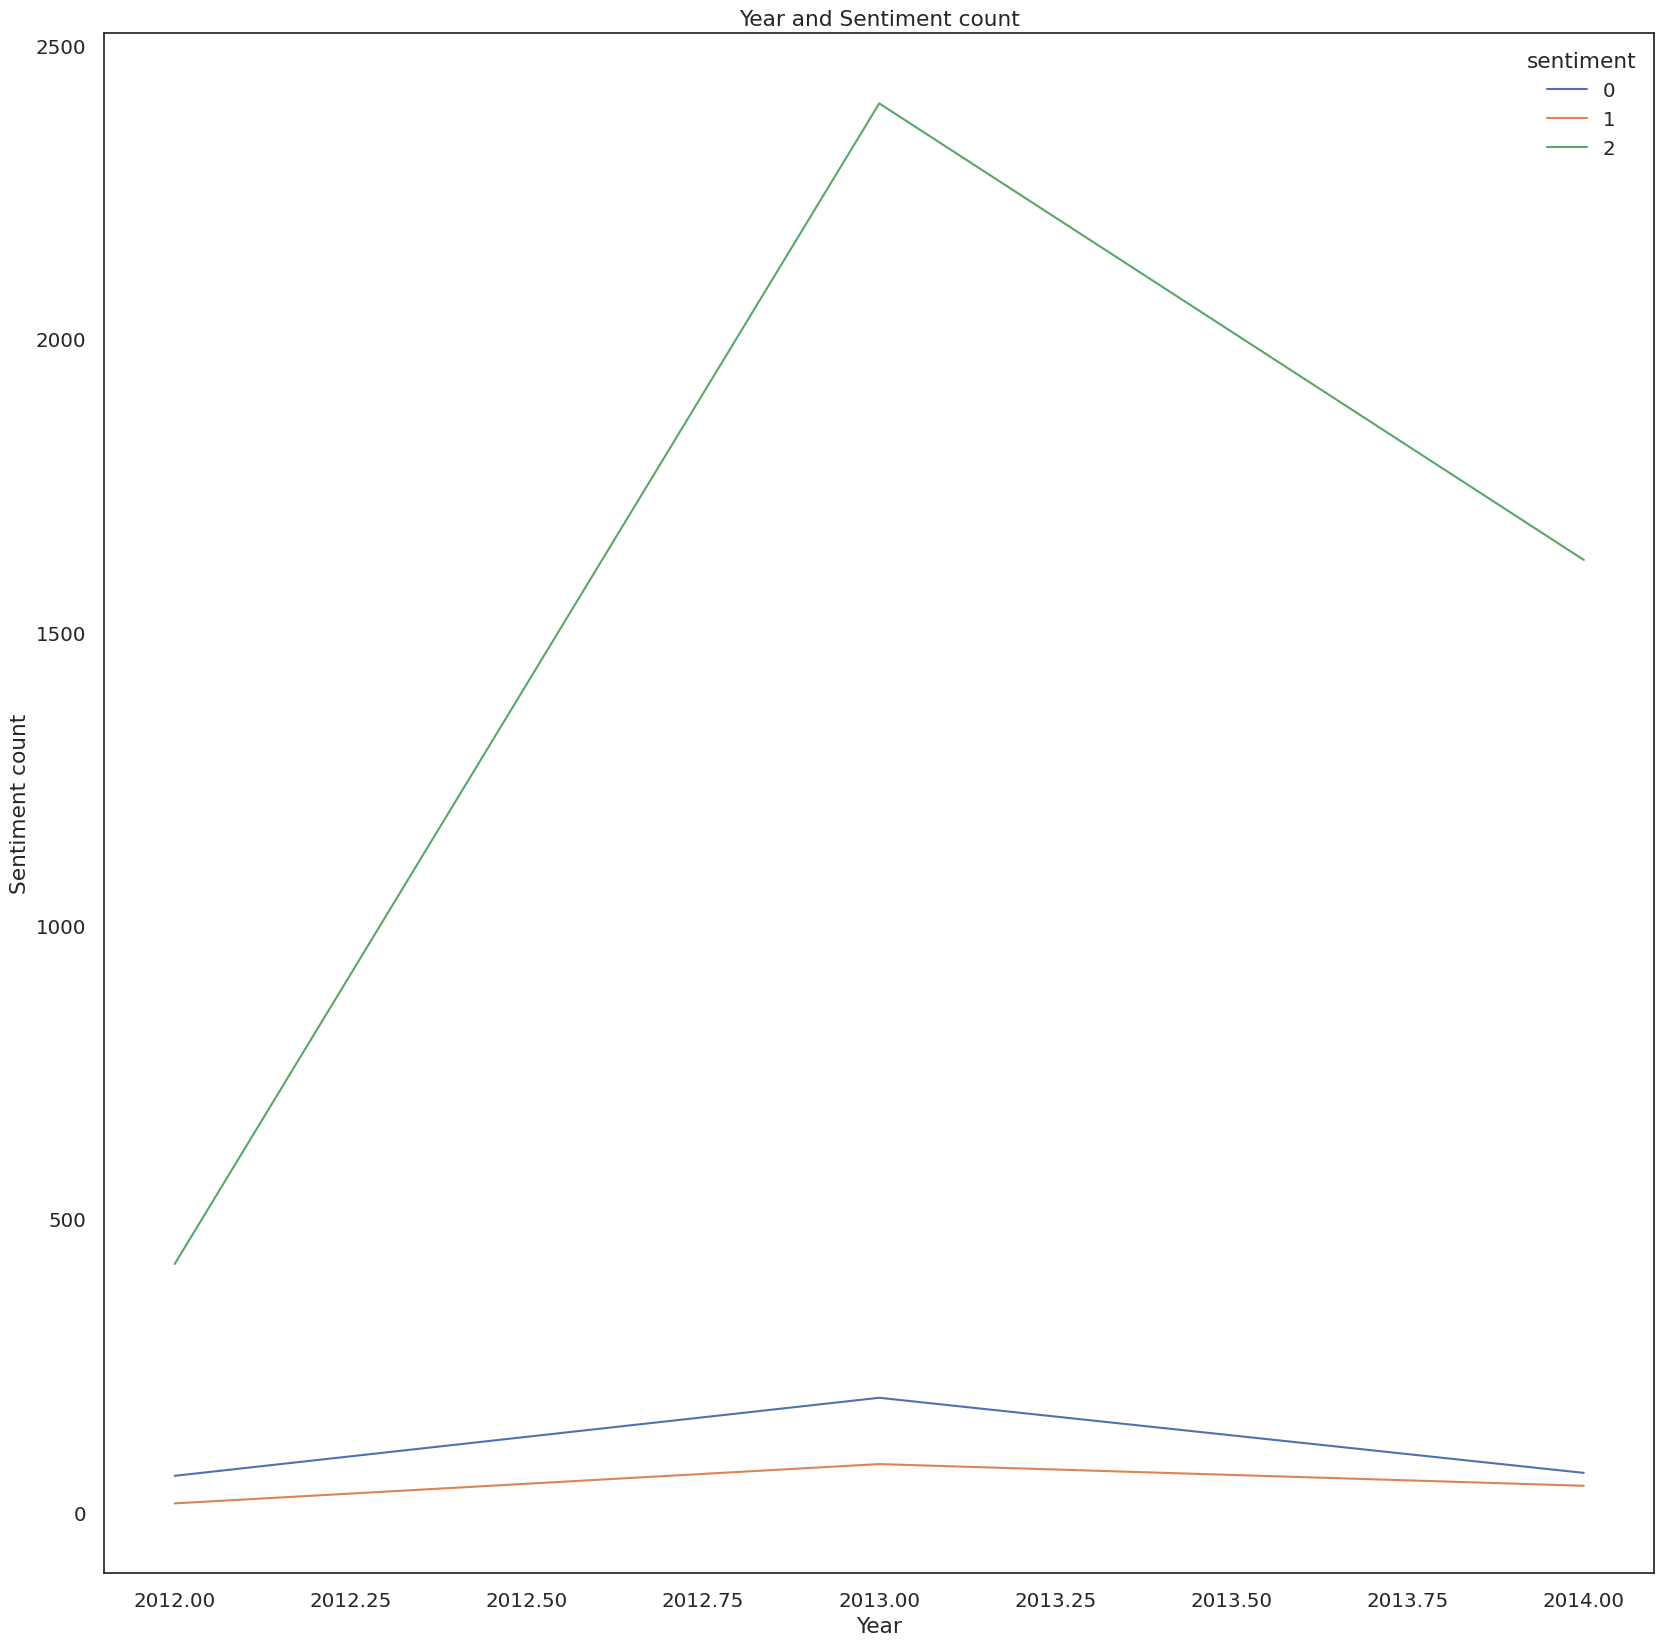

In [ ]:
# Grouping data in 'reviews' DataFrame by 'year' and 'sentiment'.
# The 'count()' function is applied to count the occurrences of each sentiment per year.
# 'unstack()' is used to reshape the data so that each sentiment becomes a column.
# This is helpful for creating a plot that compares sentiments across years.
grouped_data = df.groupby(['reviewTime_year', 'sentiment'])['sentiment'].count().unstack()

# Set the size of the plot using plt.figure and the figsize attribute.
# For example, setting the width to 10 inches and height to 8 inches.
plt.figure(figsize = (10, 8))

# Plotting the data. Each sentiment will have its own line in the plot.
grouped_data.plot(legend = True)

# Setting the title of the plot.
plt.title('Year and Sentiment count')

# Labeling the x-axis as 'Year'.
plt.xlabel('Year')

# Labeling the y-axis as 'Sentiment count'.
plt.ylabel('Sentiment count')

# Display the plot.
plt.show()

*   There was a large rise in positive reviews from 2012 to 2013 followed by a large drop from 2013 to 2014.
*   There are significantly more positive reviews compared to negative and neutral reviews.

### Word Frequencies

#### Negative Reviews

In [ ]:
# Create a data frame slice for negative sentiments
negative_reviews = df[df['sentiment'] == 0]

In [ ]:
negative_reviews.head()

day_diff  helpful_yes  helpful_no  score_average_rating  \
32        640            0           0                   0.0   
38        657            0           0                   0.0   
43        506            0           1                   0.0   
49        311            0           0                   0.0   
108       258            0           0                   0.0   

     wilson_lower_bound                                   reviewText_clean  \
32                  0.0  buy 2 sandisk 32 gb microsd galaxy note galaxy...   
38                  0.0  bougth micro sd card truble get kingston tell ...   
43                  0.0  order galaxy s3 last month break accessible di...   
49                  0.0  month phone decide quit mount lose picture pet...   
108                 0.0  work actual r w speed 18 8 mb s class 10 marke...   

     sentiment  reviewTime_year  reviewTime_month  reviewTime_day  polarity  \
32           0             2013                 3               8  0.250000   
38           0             2013                 2              19  0.242433   
43           0             2013                 7              20  0.082341   
49           0             2014                 1              31  0.090606   
108          0             2014                 3              25 -0.020833   

     vader_polarity  review_len  
32           0.5255         333  
38           0.9408         991  
43          -0.7208         482  
49          -0.1531         307  
108          0.4436         464

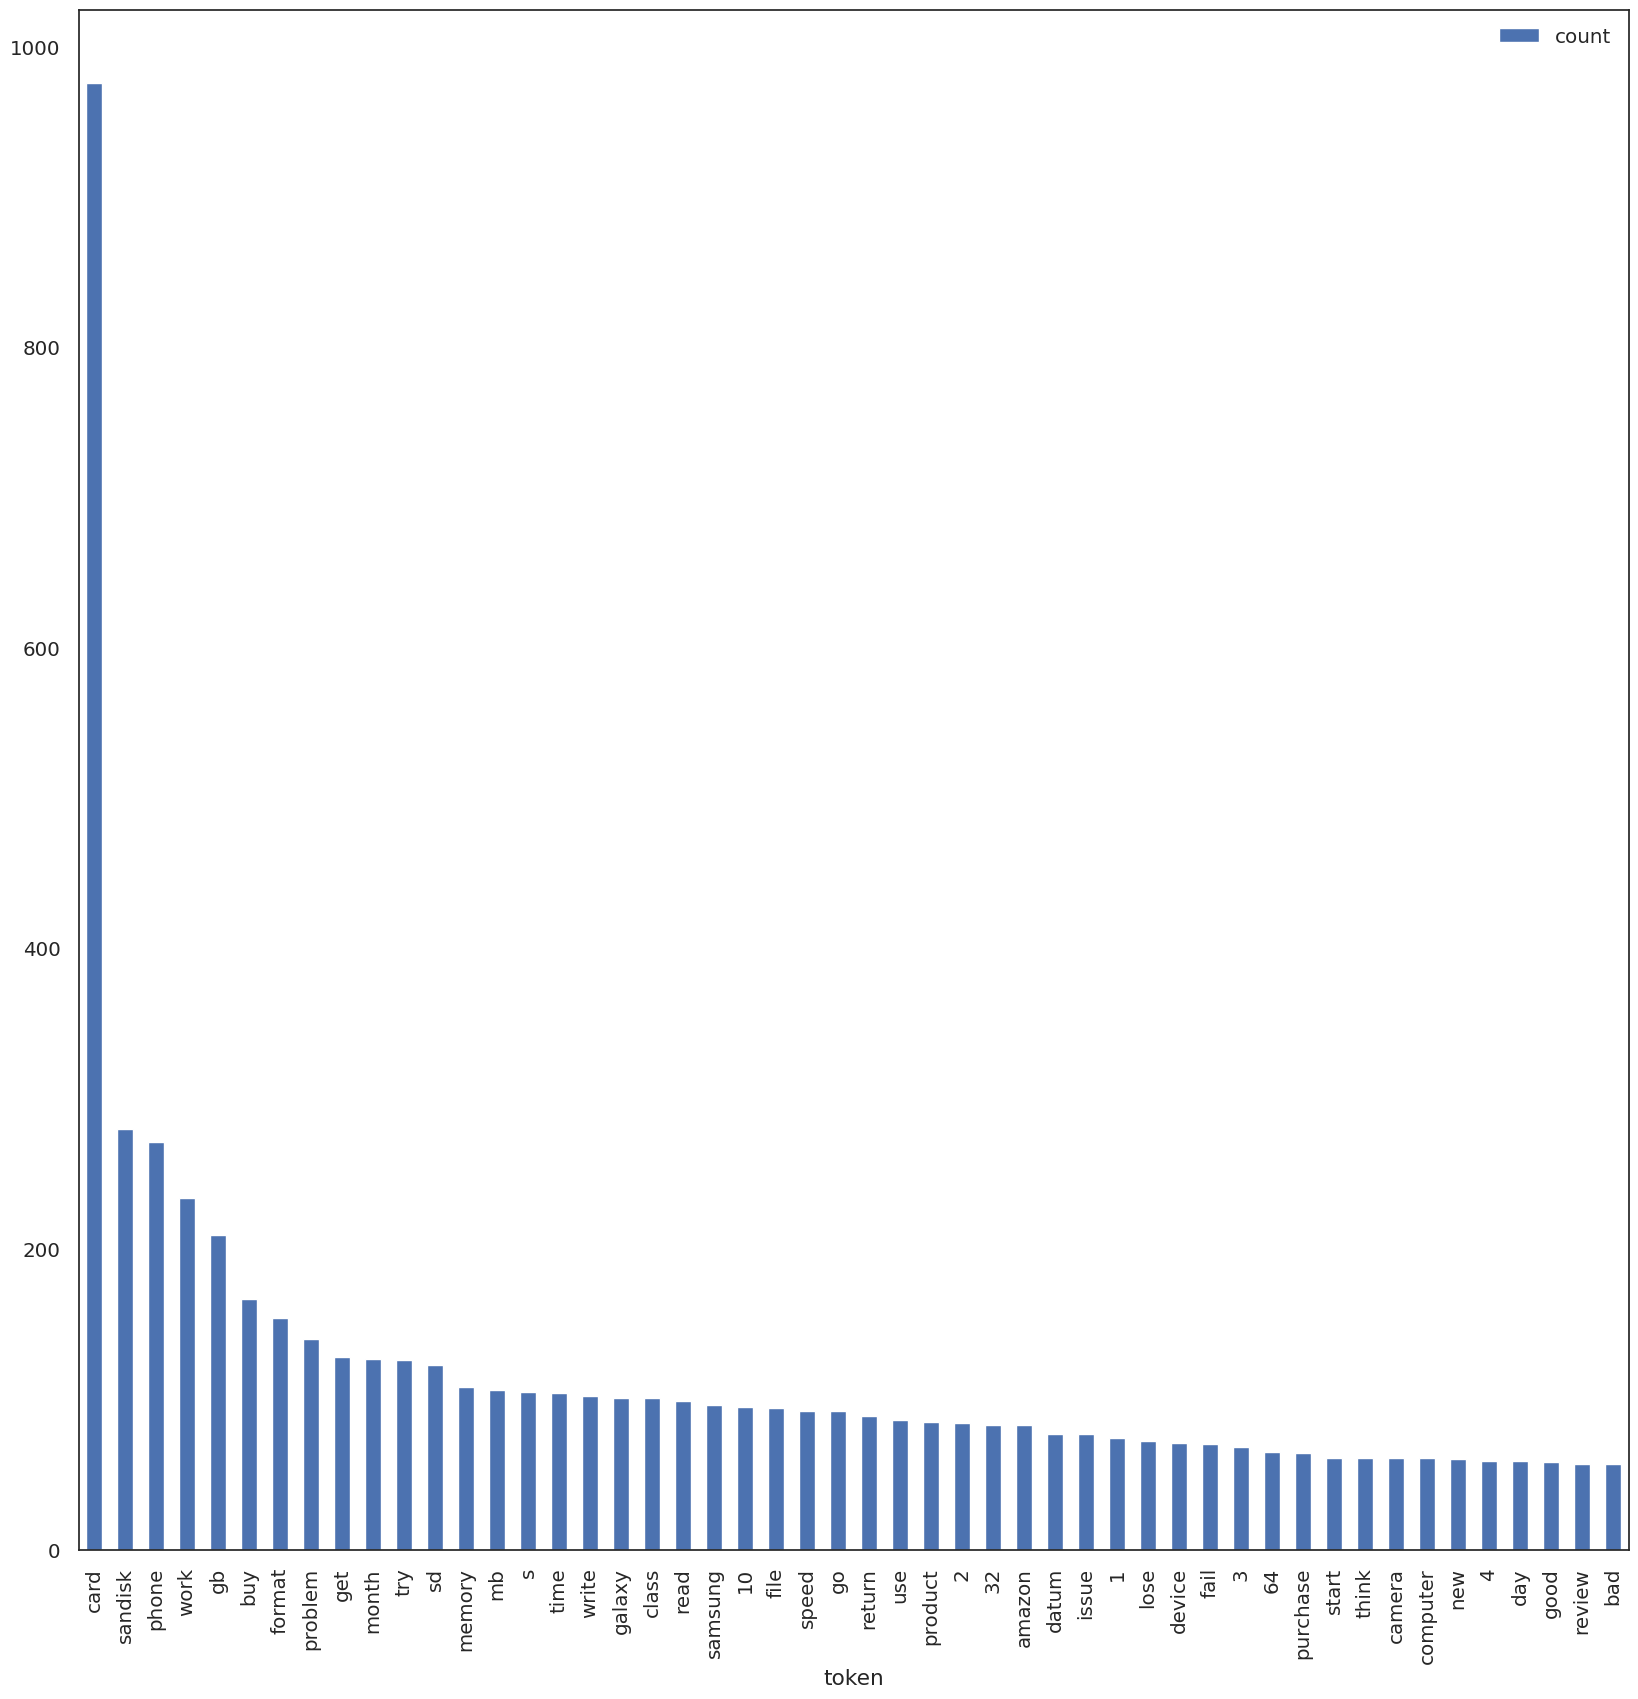

In [ ]:
# transform list of documents into a single list of tokens
negative_reviews_tokens = negative_reviews.reviewText_clean.map(my_tokenizer).sum()

negative_counter = Counter(negative_reviews_tokens)

# convert list into data frame
negative_frequency = pd.DataFrame.from_records(negative_counter.most_common(50),
                                               columns = ['token', 'count'])

# Create a bar plot.
negative_frequency.plot(kind = 'bar', x = 'token', y = 'count')

# Display the plot.
plt.show()

#### Neutral Reviews

In [ ]:
# create a data frame slice for neutral sentiments
neutral_reviews = df[df['sentiment'] == 1]

In [ ]:
neutral_reviews.head()

day_diff  helpful_yes  helpful_no  score_average_rating  \
11        383            0           0                   0.0   
64        455            1           0                   1.0   
112       247            0           0                   0.0   
122       281            0           0                   0.0   
163       195            0           0                   0.0   

     wilson_lower_bound                                   reviewText_clean  \
11             0.000000  work file write bit slow expect usb3 reader.al...   
64             0.206549  card advertise uhs1 actually uhs50.this mean s...   
112            0.000000  job fairly cheap worth return exchange defecti...   
122            0.000000  feel fast phone guess need remove run r w test ok   
163            0.000000  work great galaxy s4 work unknown reason 4 mon...   

     sentiment  reviewTime_year  reviewTime_month  reviewTime_day  polarity  \
11           1             2013                11              20 -0.050000   
64           1             2013                 9               9 -0.275000   
112          1             2014                 4               5  0.289583   
122          1             2014                 3               2  0.380000   
163          1             2014                 5              27  0.233333   

     vader_polarity  review_len  
11           0.0000         255  
64          -0.6956         164  
112          0.8519         283  
122          0.0000         121  
163          0.6249         184

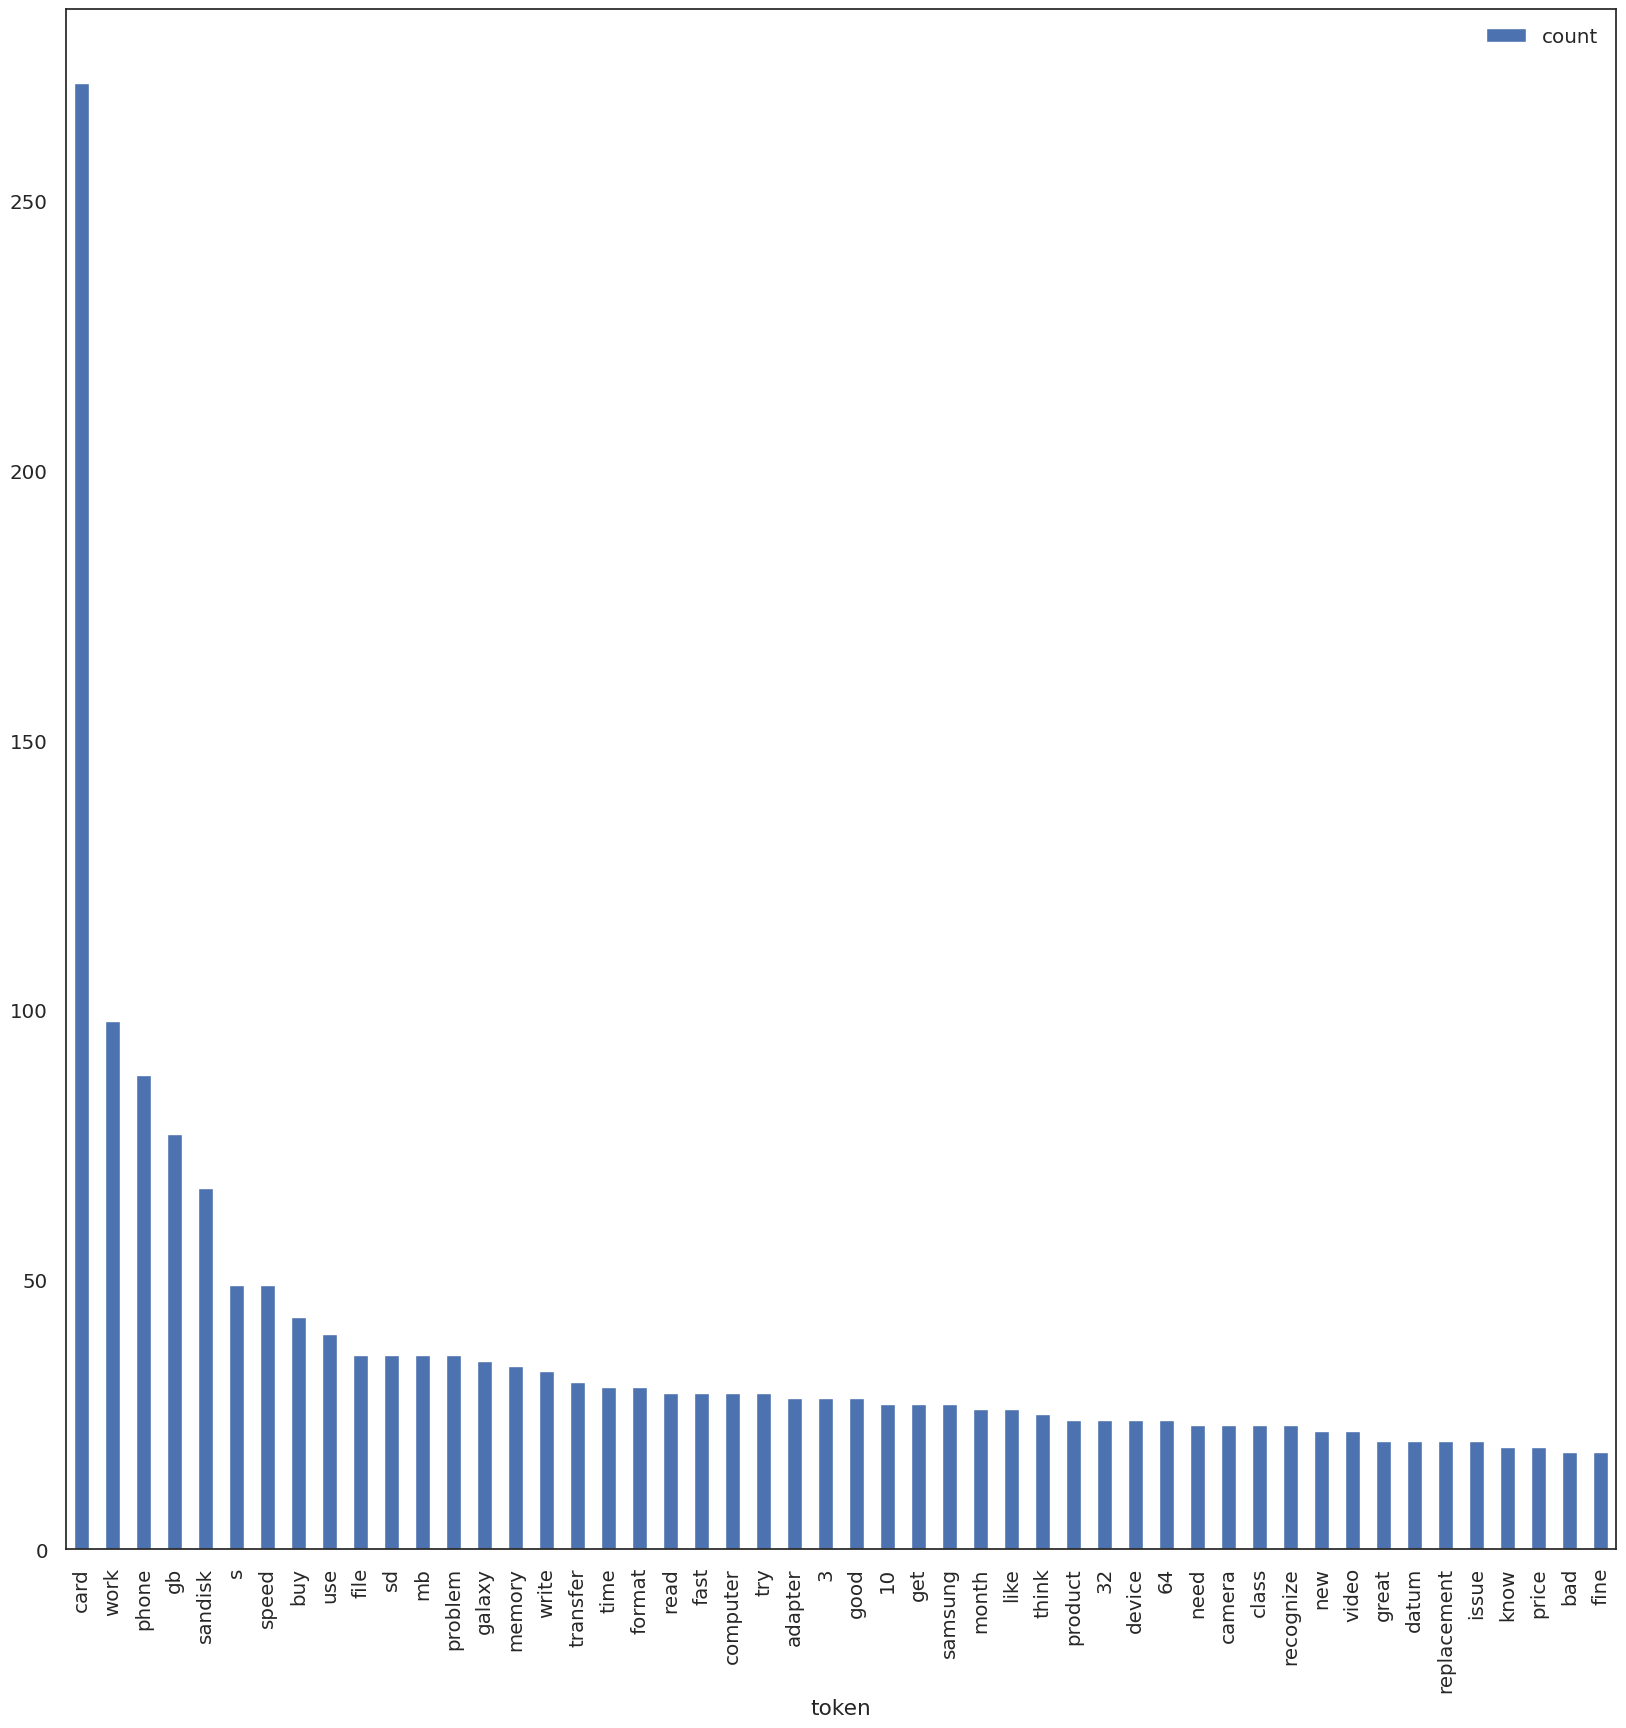

In [ ]:
# transform list of documents into a single list of tokens
neutral_reviews_tokens = neutral_reviews.reviewText_clean.map(my_tokenizer).sum()

neutral_counter = Counter(neutral_reviews_tokens)

# convert list into data frame
neutral_frequency = pd.DataFrame.from_records(neutral_counter.most_common(50),
                                              columns = ['token', 'count'])

# Create a bar plot.
neutral_frequency.plot(kind = 'bar', x = 'token', y = 'count')

# Display the plot.
plt.show()

#### Positive Reviews

In [ ]:
# create a data frame slice for positive sentiments
positive_reviews = df[df['sentiment'] == 2]

In [ ]:
positive_reviews.head()

day_diff  helpful_yes  helpful_no  score_average_rating  \
1       409            0           0                   0.0   
2       715            0           0                   0.0   
3       382            0           0                   0.0   
4       513            0           0                   0.0   
5       588            0           0                   0.0   

   wilson_lower_bound                                   reviewText_clean  \
1                 0.0  purchase device work advertised phone memory d...   
2                 0.0  work expect spring high capacity think bit che...   
3                 0.0  think work great.had different bran 64 gb card...   
4                 0.0  buy retail packaging arrive legit orange envel...   
5                 0.0  mini storage suppose purchase add additional s...   

   sentiment  reviewTime_year  reviewTime_month  reviewTime_day  polarity  \
1          2             2013                10              25  0.200000   
2          2             2012                12              23  0.129167   
3          2             2013                11              21  0.000000   
4          2             2013                 7              13  0.386667   
5          2             2013                 4              29 -0.025000   

   vader_polarity  review_len  
1         -0.2960         158  
2         -0.3089         166  
3          0.7081         340  
4          0.7087         290  
5          0.0000         282

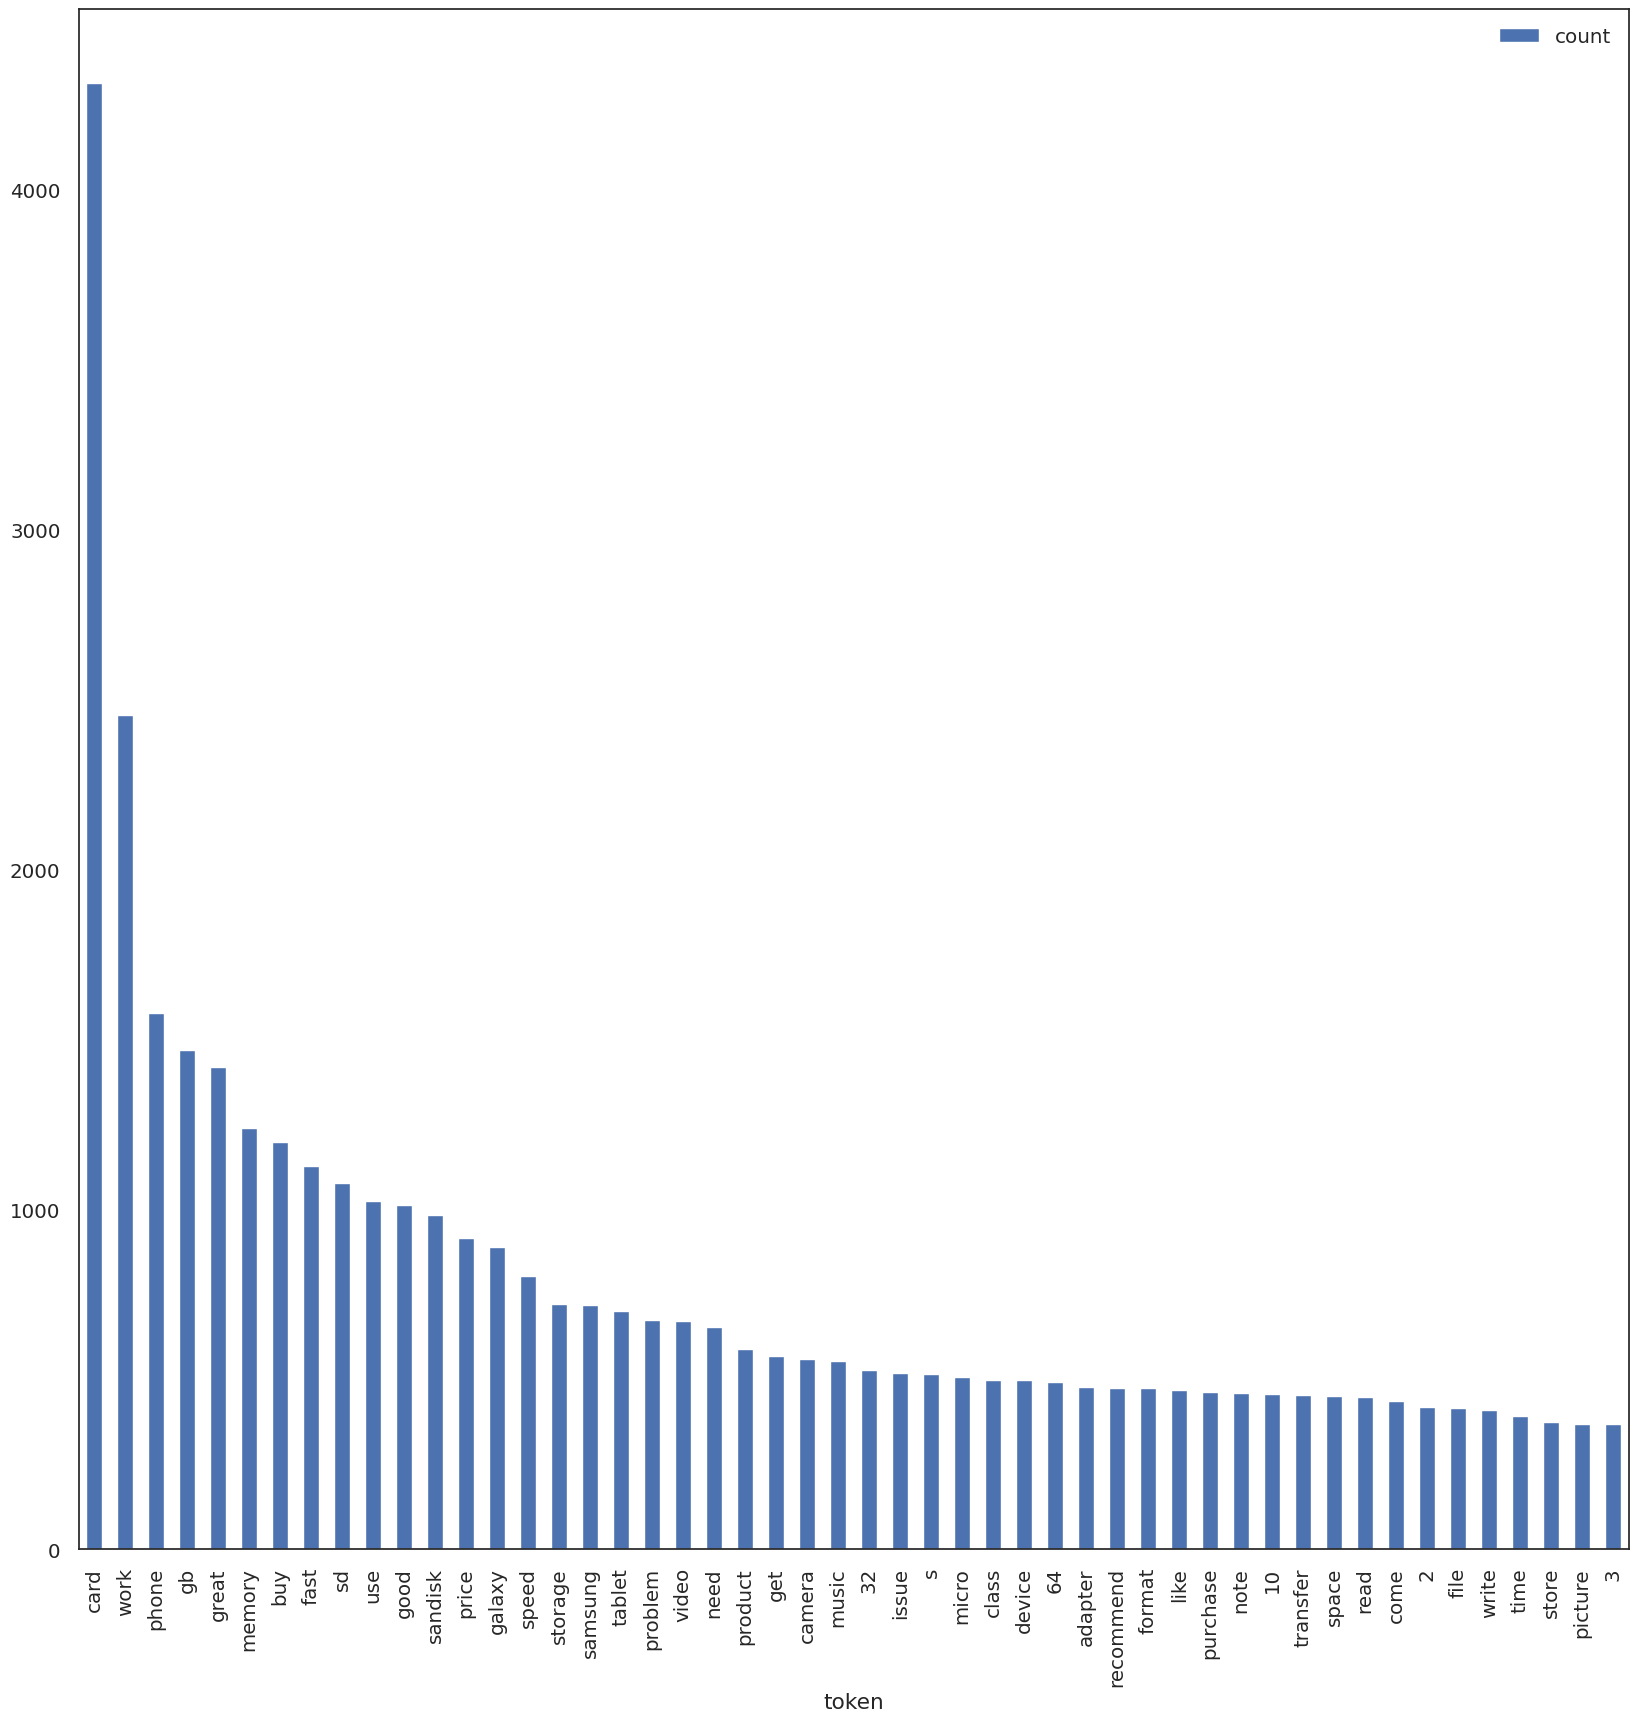

In [ ]:
# transform list of documents into a single list of tokens
positive_reviews_tokens = positive_reviews.reviewText_clean.map(my_tokenizer).sum()

positive_counter = Counter(positive_reviews_tokens)

# convert list into data frame
positive_frequency = pd.DataFrame.from_records(positive_counter.most_common(50),
                                    columns = ['token', 'count'])

# Create a bar plot.
positive_frequency.plot(kind = 'bar', x = 'token', y = 'count')

# Display the plot.
plt.show()

### WordClouds

#### Negative Reviews

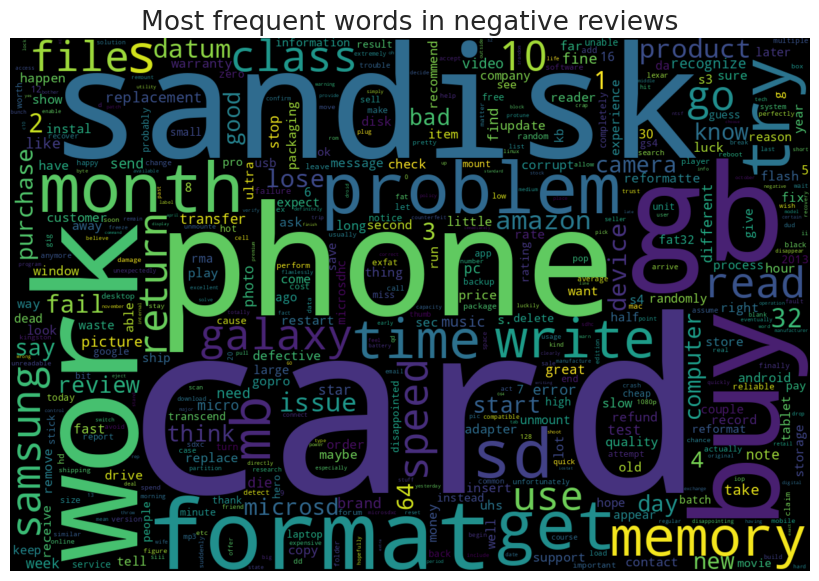

In [ ]:
title = 'Most frequent words in negative reviews'
display_wordcloud(title, negative_counter)

#### Neutral Reviews

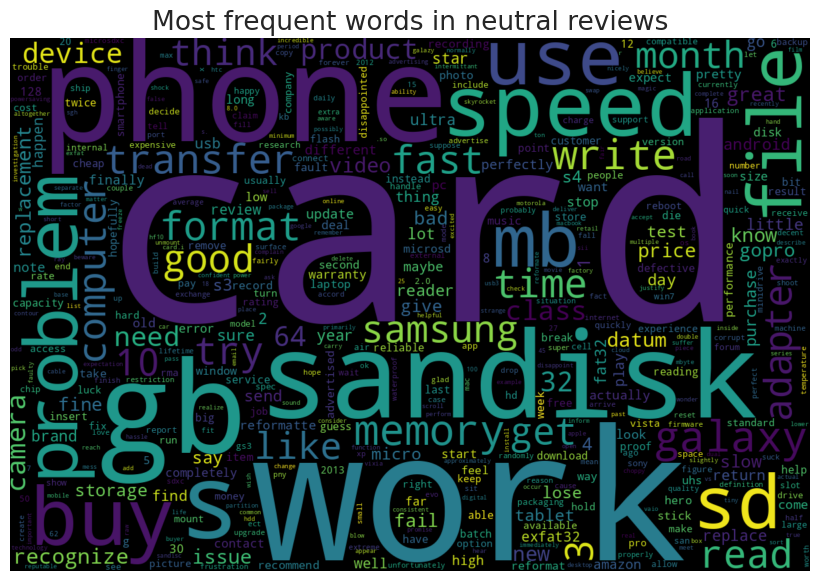

In [ ]:
title = 'Most frequent words in neutral reviews'
display_wordcloud(title, neutral_counter)

#### Positive Reviews

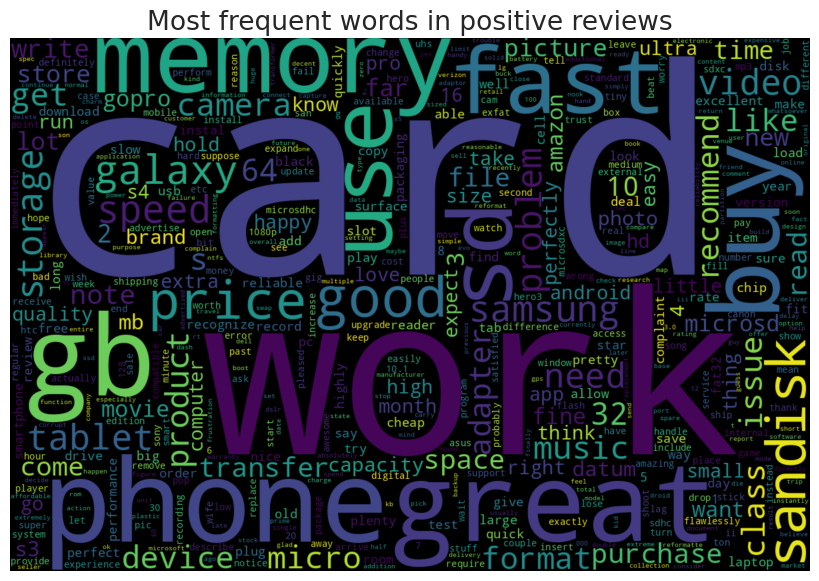

In [ ]:
title = 'Most frequent words in positive reviews'
display_wordcloud(title, positive_counter)

## Bag of Words

I will use a Bag of Words Model (BoW) which is basically, the total occurence of words within a document. I will take ngram_range as (2,3) which signifies unigrams, bigrams and trigrams.

In [ ]:
# I will take ngram_range as (1,2) which signifies unigrams and bigrams.
vectorizer = CountVectorizer(
    min_df = 0.015,
    max_df = 0.8,
    ngram_range = (1,2)
).fit(df['reviewText_clean'])

In [ ]:
# Fit the vectorizer to the text data and transform the data
X = vectorizer.fit_transform(df['reviewText_clean'])

In [ ]:
words = pd.DataFrame(data = X.toarray(), columns = vectorizer.get_feature_names_out())

In [ ]:
# Reset the index of the two DataFrames
df.reset_index(drop = True, inplace = True)
words.reset_index(drop = True, inplace = True)

In [ ]:
# Concatenate the 2 `DataFrame` to generate the dataset
df_concat = pd.concat([df, words], axis = 1)

print(f"The reviews data frame contains {df.shape[0]} row(s) and {df.shape[1]} column(s).")
print(f"The word vector contains {words.shape[0]} row(s) and {words.shape[1]} column(s).")
print(f"The resulting dataframe contains {df_concat.shape[0]} row(s) and {df_concat.shape[1]} column(s).")

The reviews data frame contains 4913 row(s) and 13 column(s).
The word vector contains 4913 row(s) and 282 column(s).
The resulting dataframe contains 4913 row(s) and 295 column(s).


In [ ]:
df_concat.head()

day_diff  helpful_yes  helpful_no  score_average_rating  \
0       409            0           0                   0.0   
1       715            0           0                   0.0   
2       382            0           0                   0.0   
3       513            0           0                   0.0   
4       588            0           0                   0.0   

   wilson_lower_bound                                   reviewText_clean  \
0                 0.0  purchase device work advertised phone memory d...   
1                 0.0  work expect spring high capacity think bit che...   
2                 0.0  think work great.had different bran 64 gb card...   
3                 0.0  buy retail packaging arrive legit orange envel...   
4                 0.0  mini storage suppose purchase add additional s...   

   sentiment  reviewTime_year  reviewTime_month  reviewTime_day  ...  \
0          2             2013                10              25  ...   
1          2             2012                12              23  ...   
2          2             2013                11              21  ...   
3          2             2013                 7              13  ...   
4          2             2013                 4              29  ...   

   work flawlessly  work great  work like  work perfectly  worry  worth  \
0                0           0          0               0      0      0   
1                0           0          0               0      0      0   
2                0           1          0               0      0      0   
3                0           0          0               0      0      0   
4                0           0          0               0      0      0   

   write  write speed  wrong  year  
0      0            0      0     0  
1      0            0      0     0  
2      0            0      0     0  
3      0            0      0     0  
4      0            0      0     0  

[5 rows x 295 columns]

## Imbalanced Dataset

In a previous iteration I used 2 techniques suggested by Javaid Nabi in his article Machine Learning — Multiclass Classification with Imbalanced Dataset (https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a). He suggested balancing the dataset to improve the performance of an imbalanced dataset. The two ways to do so are:

1.   **Under-sampling**: Remove samples from over-represented classes ; use this if you have huge dataset.
2.   **Over-sampling**: Add more samples from under-represented classes; use this if you have small dataset. I tried SMOTE (Synthetic Minority Over-sampling Technique).

I abandoned both approaches because I found that all the algorithms I used dropped 10-30% in accuracy. I then used Stratified sampling and if the algorithm permitted, set the parameter **class_weight='balanced'** which uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

## Stratified sampling

**Advantages**

*   Stratified random sampling accurately reflects the population being studied.
*   It ensures each subgroup within the population receives proper representation within the sample.
*   As a result, stratified random sampling provides better coverage of the population.


**Disadvantages**

*   Disadvantageous when we can’t confidently classify every member of the population into a subgroup.
*   Overlapping can be an issue if there are subjects that fall into multiple subgroups. When simple random sampling is performed, those who are in multiple subgroups are more likely to be chosen.
*   More complicated groups can make the process more difficult, rendering stratified sampling a less than ideal method.

https://medium.com/analytics-vidhya/stratified-sampling-in-machine-learning-f5112b5b9cfe

In [ ]:
train_set, test_set = train_test_split(df_concat, test_size = 0.2, random_state = random_state)

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    df_concat, test_size = 0.2, stratify = df_concat["sentiment"], random_state = random_state)

In [ ]:
compare_props = pd.DataFrame({
    "Overall %": overall_proportions(df_concat),
    "Stratified %": overall_proportions(strat_test_set),
    "Random %": overall_proportions(test_set),
}).sort_index()

compare_props.index.name = "Overall"
compare_props["Stratified Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Random Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

Overall %  Stratified %  Random %  Stratified Error %  Random Error %
Overall                                                                       
0             6.59          6.61      6.92                0.27            4.90
1             2.89          2.85      2.54               -1.45          -12.01
2            90.51         90.54     90.54                0.03            0.03

### Create classifiers

In [ ]:
X = strat_train_set.drop(["sentiment", "reviewText_clean"], axis = 1)
y = strat_train_set['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

In [ ]:
ab = AdaBoostClassifier(random_state = random_state)
et = ExtraTreesClassifier(class_weight='balanced', random_state = random_state)
gb = GradientBoostingClassifier(random_state = random_state)
knn = KNeighborsClassifier()
lr = LogisticRegression(random_state = random_state)
rf = RandomForestClassifier(class_weight='balanced', random_state = random_state)
rg = RidgeClassifier(class_weight='balanced', random_state = random_state)
svc = LinearSVC(class_weight='balanced', random_state = random_state)

classes = np.unique(y_train)
xgb = xgb.XGBClassifier(num_class = len(classes))

#### AdaBoost Classifier

In [ ]:
model = ab
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 0.6247210502624512
Test accuracy : 92.49%


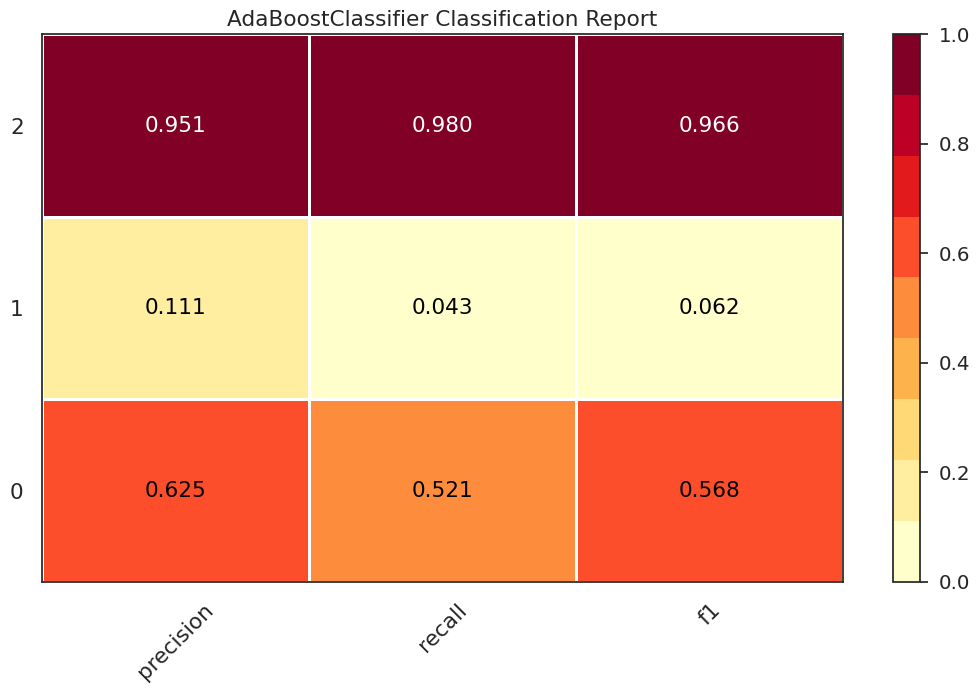

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


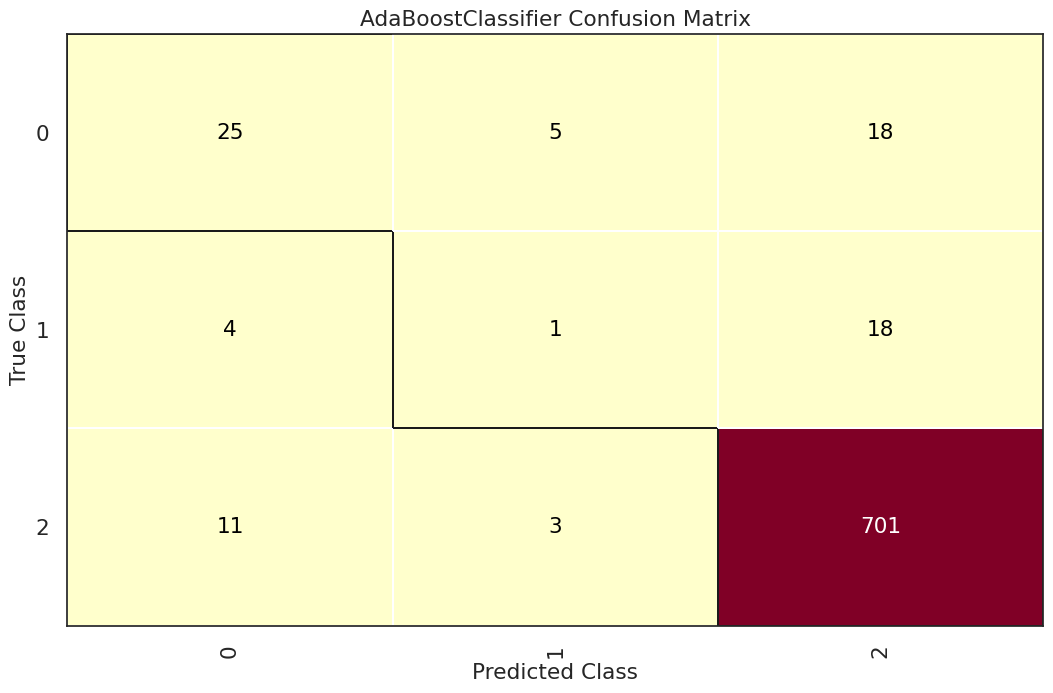

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


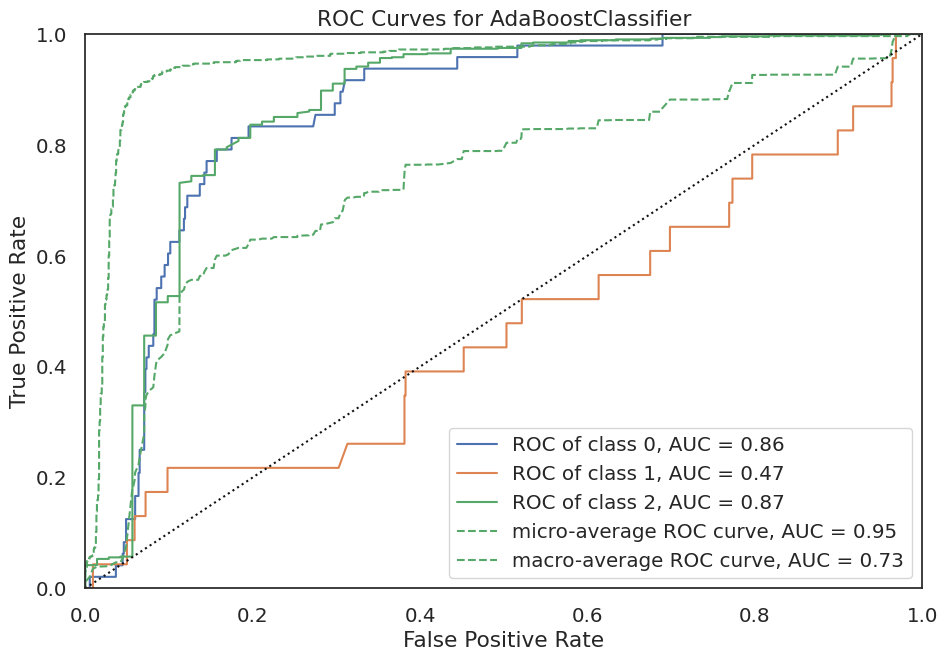

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


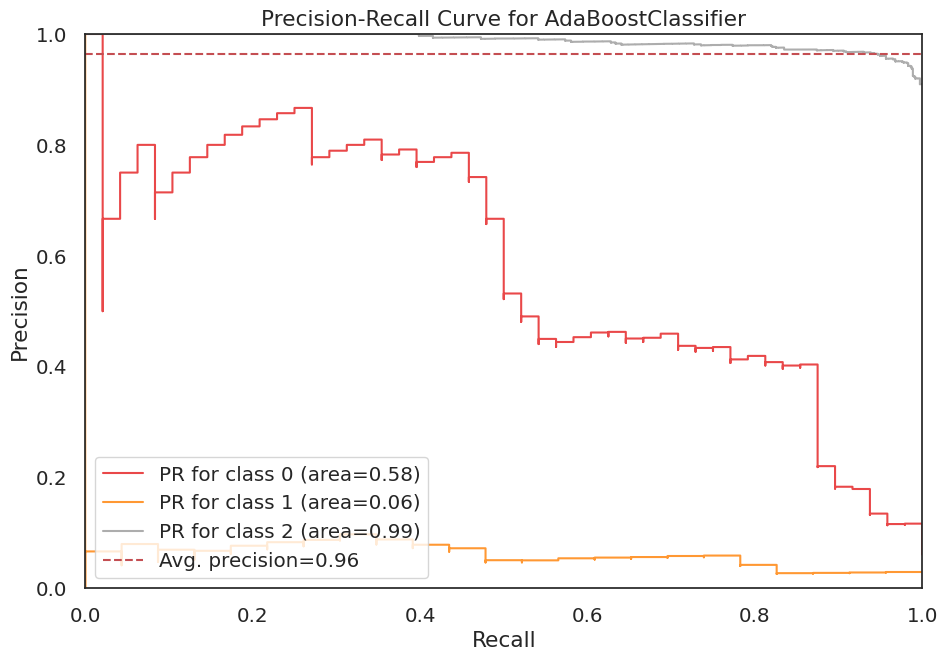

In [ ]:
display_precision_recall_curve(model)

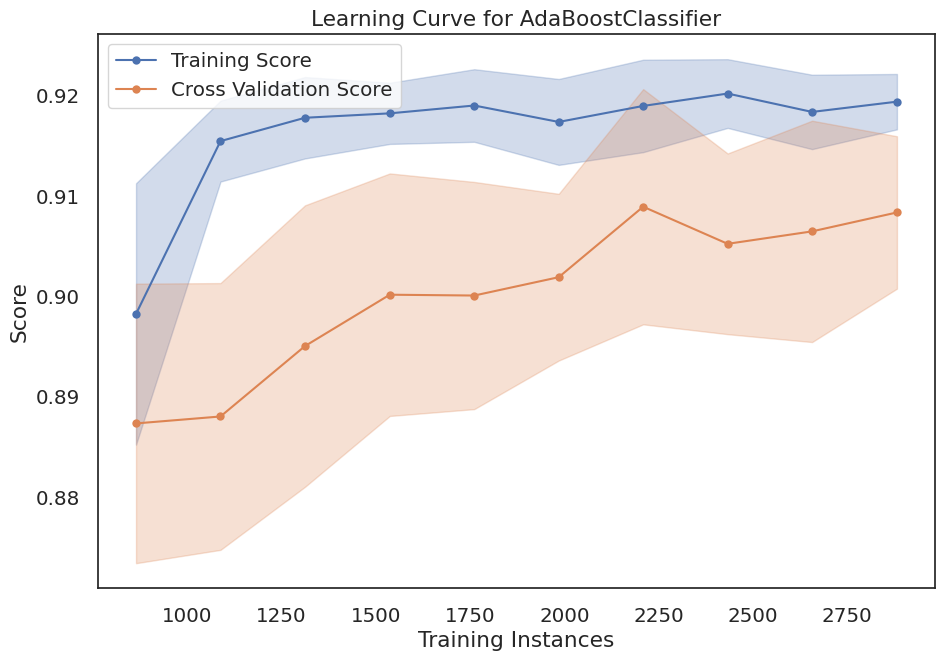

In [ ]:
display_learning_curve(model)

#### ExtraTrees Classifier

In [ ]:
model = et
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 0.8635127544403076
Test accuracy : 91.86%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


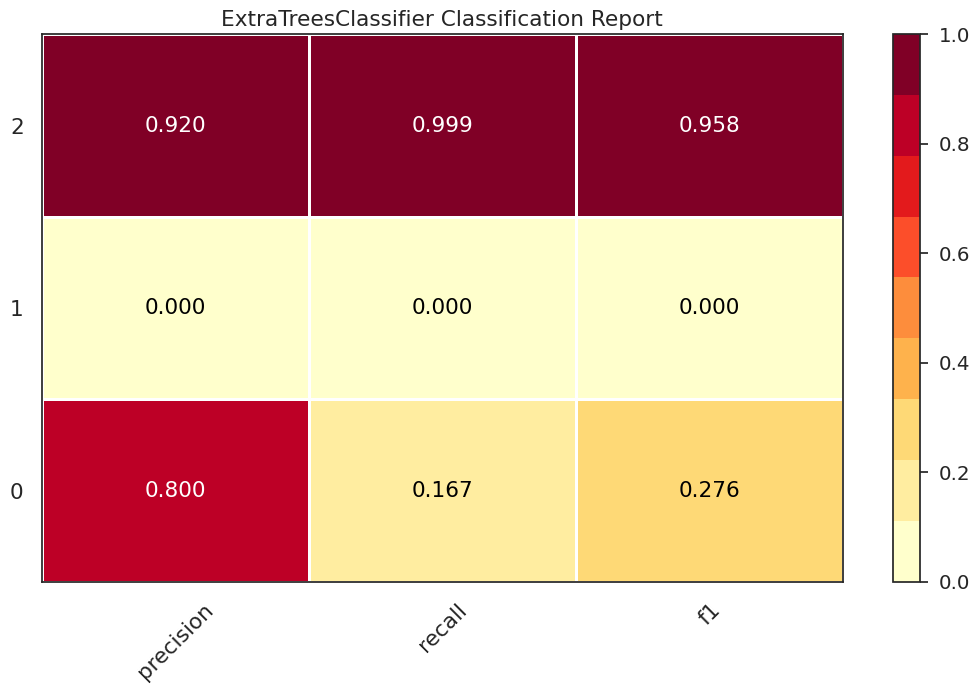

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


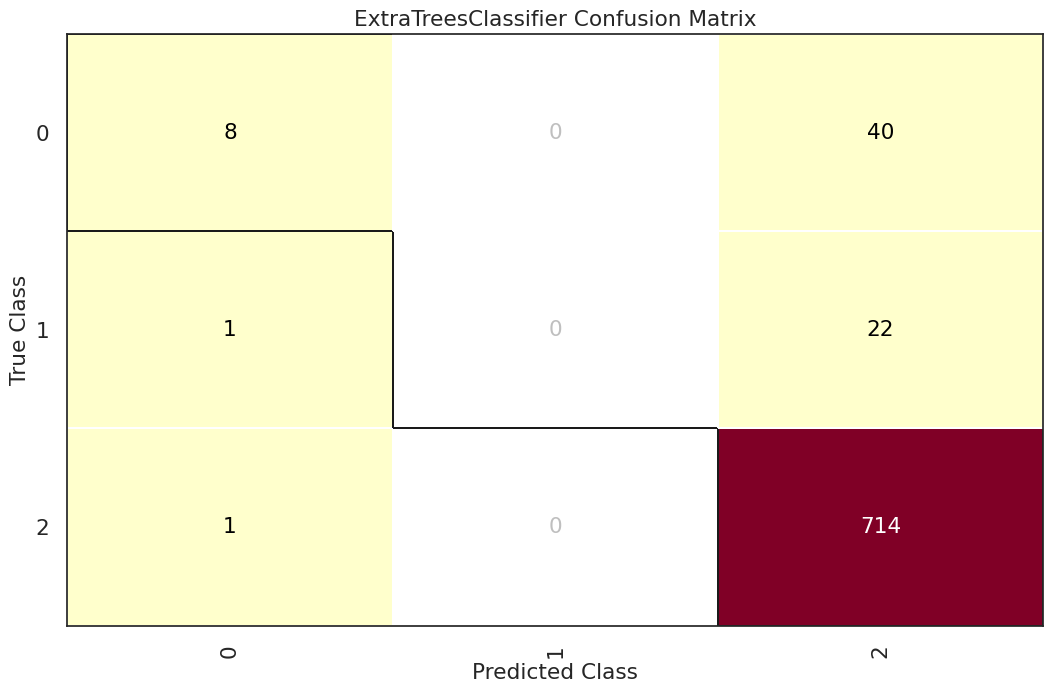

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


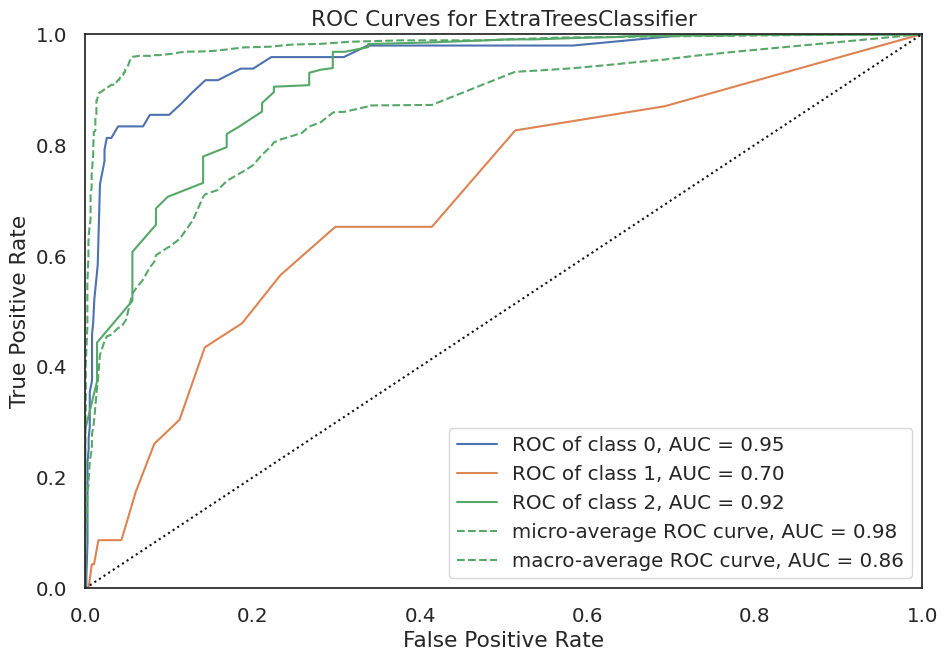

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


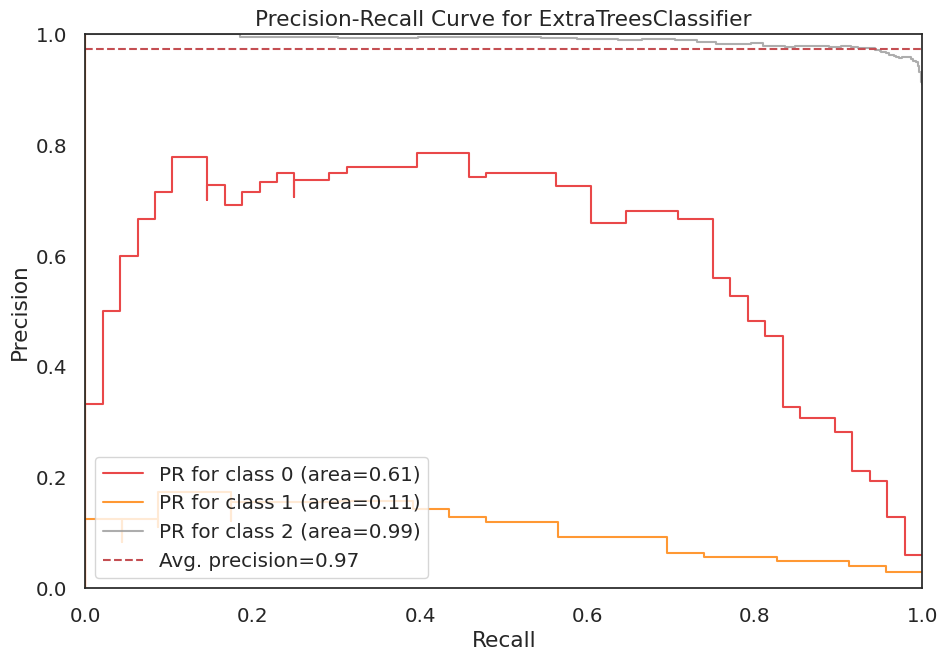

In [ ]:
display_precision_recall_curve(model)

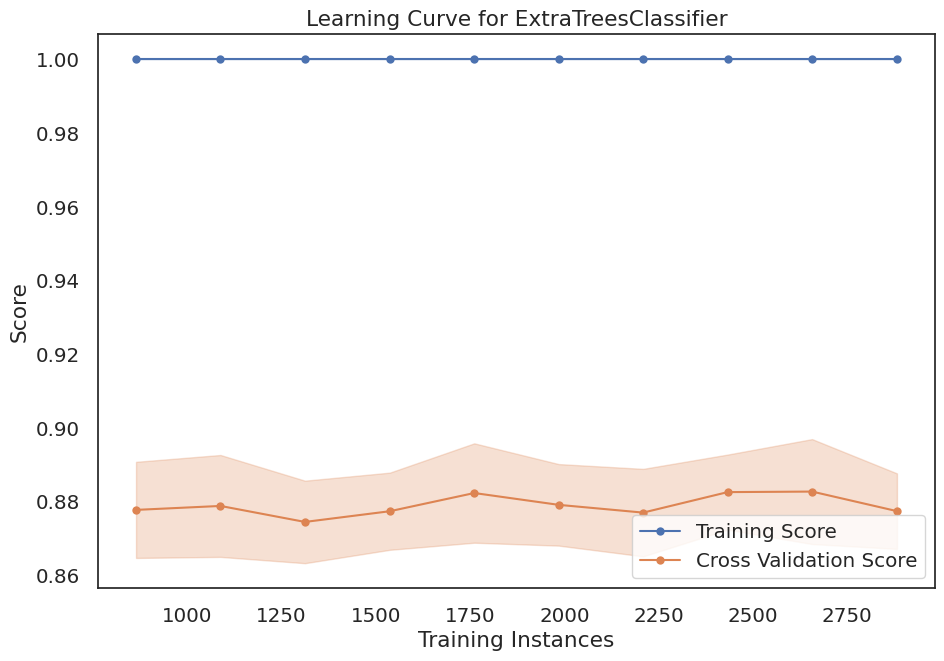

In [ ]:
display_learning_curve(model)

#### GradientBoosting Classifier

In [ ]:
model = gb
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 7.091034650802612
Test accuracy : 93.26%


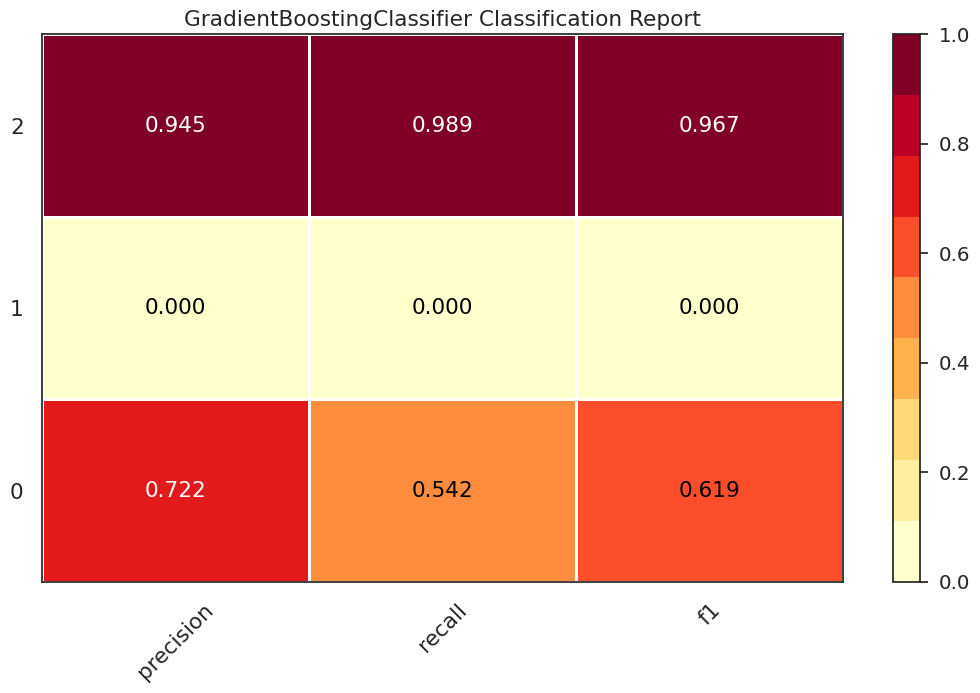

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


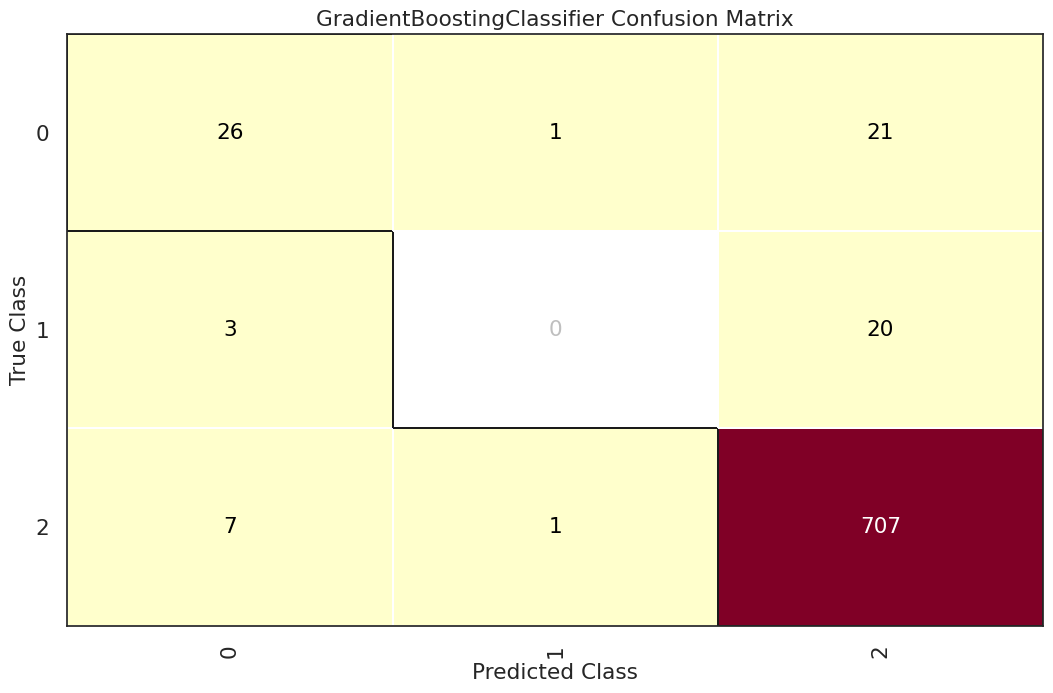

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


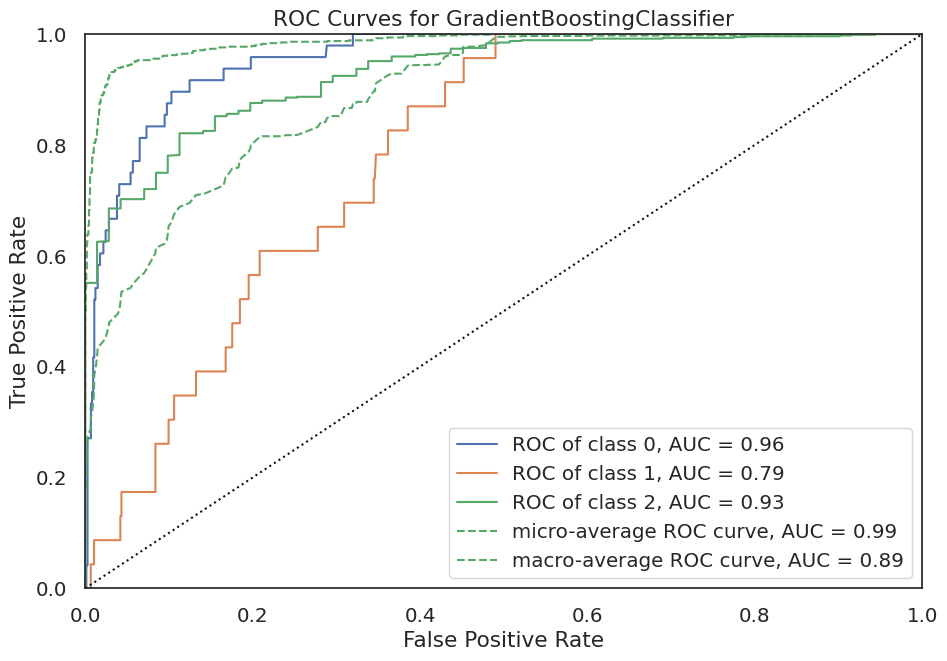

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


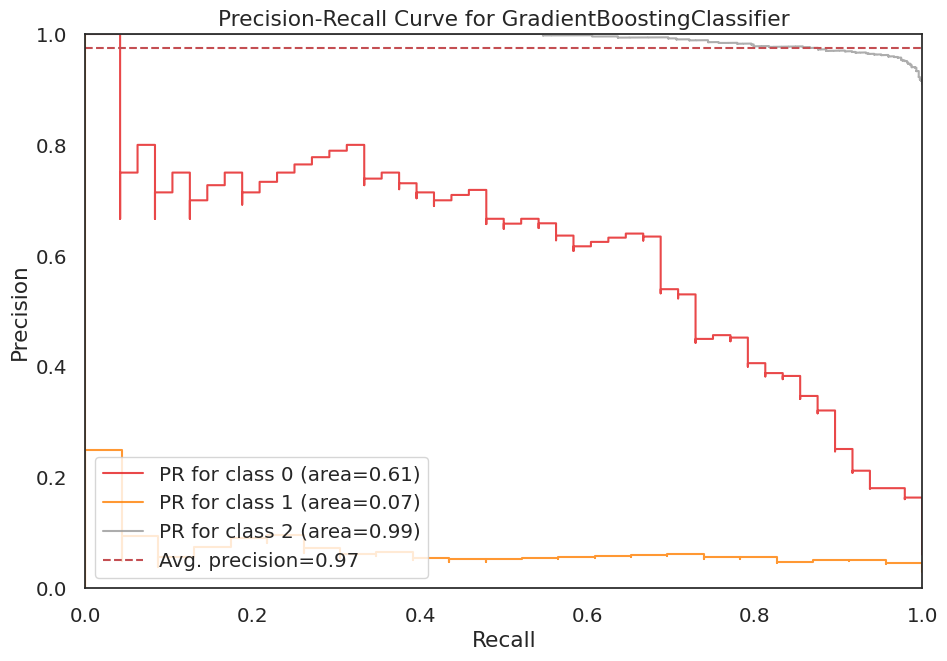

In [ ]:
display_precision_recall_curve(model)

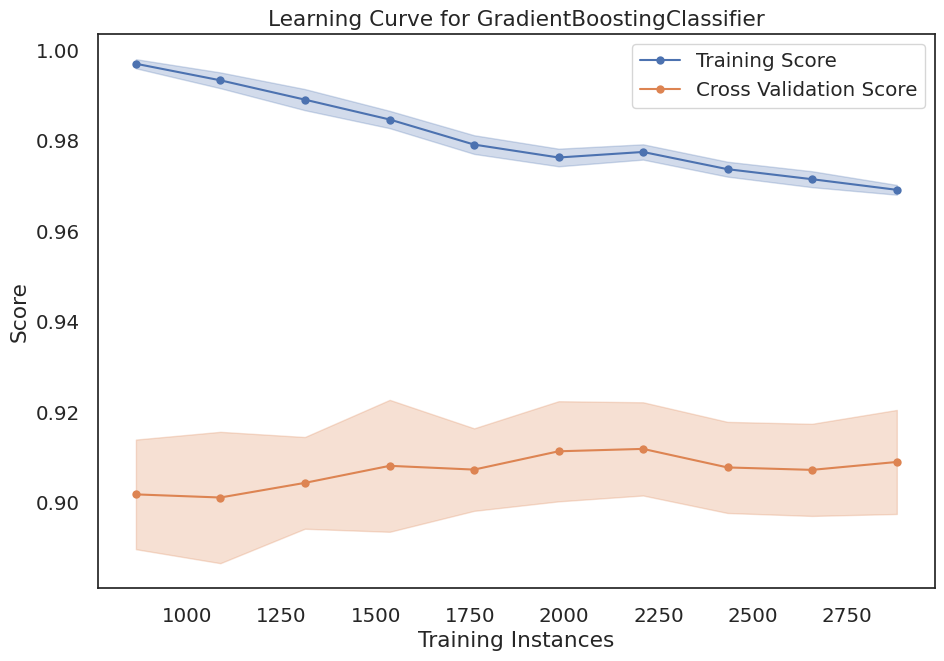

In [ ]:
display_learning_curve(model)

#### K-Nearest Neighbors Classifier

In [ ]:
model = knn
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 0.014699459075927734
Test accuracy : 88.93%


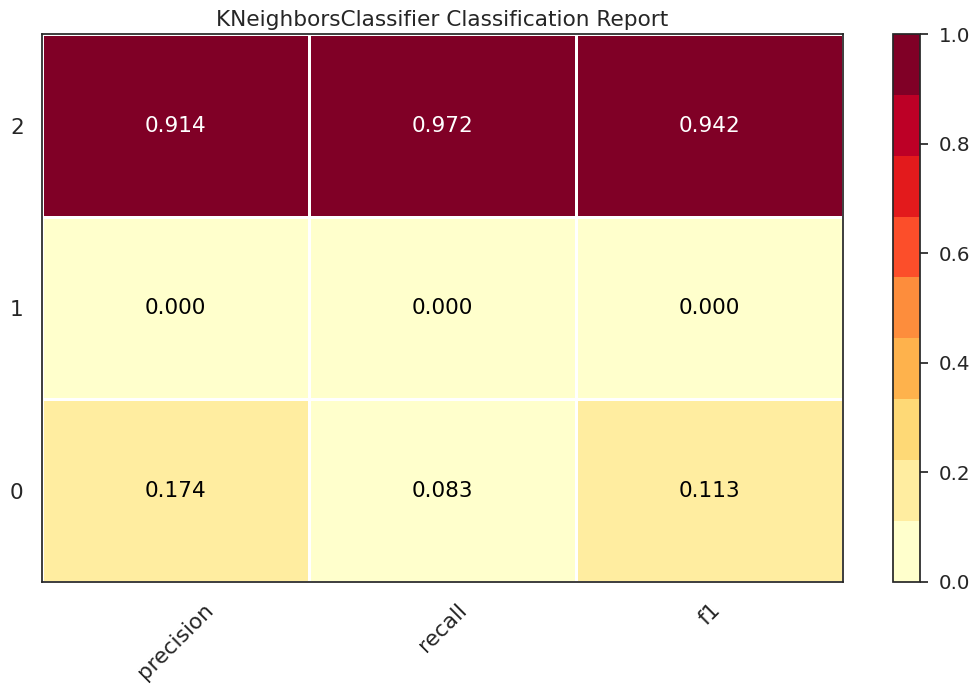

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


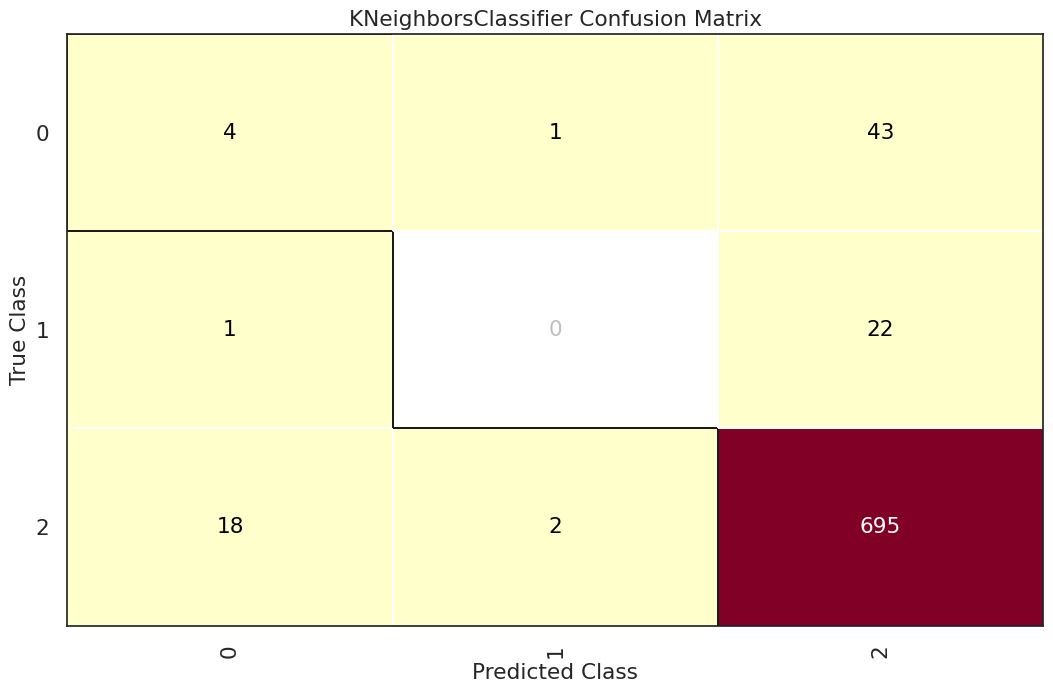

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


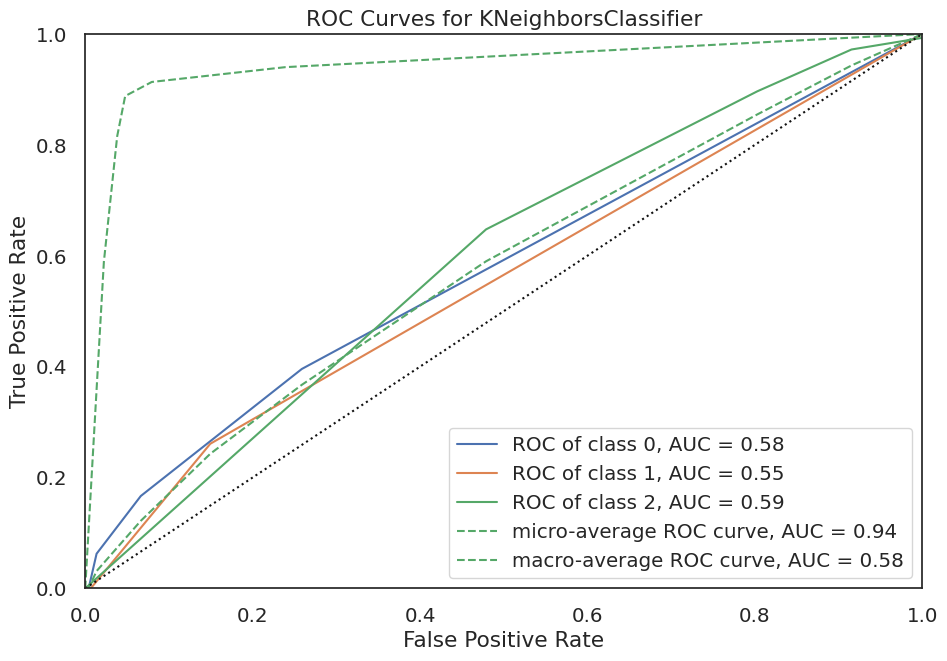

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


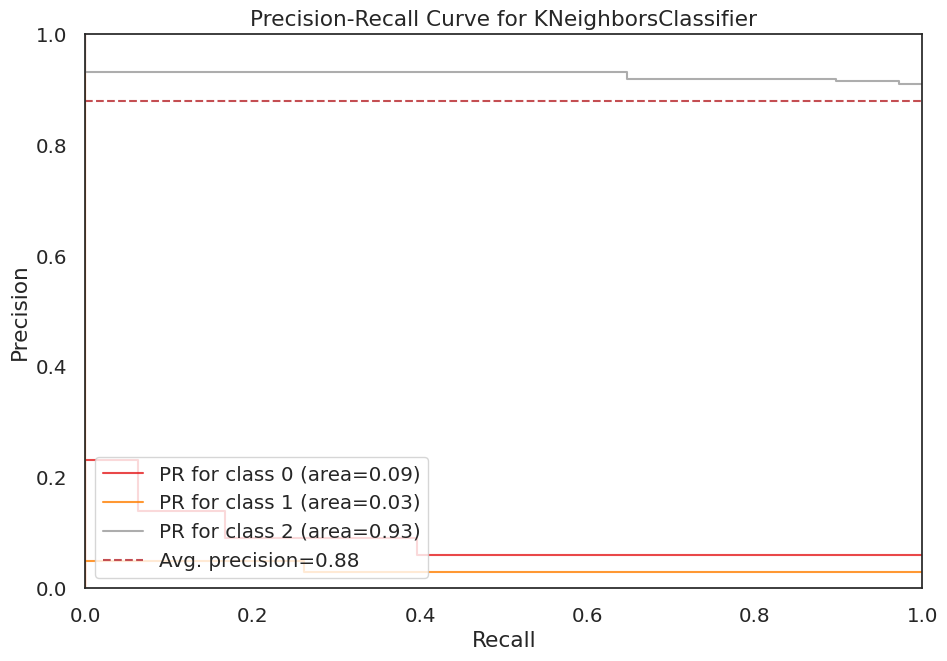

In [ ]:
display_precision_recall_curve(model)

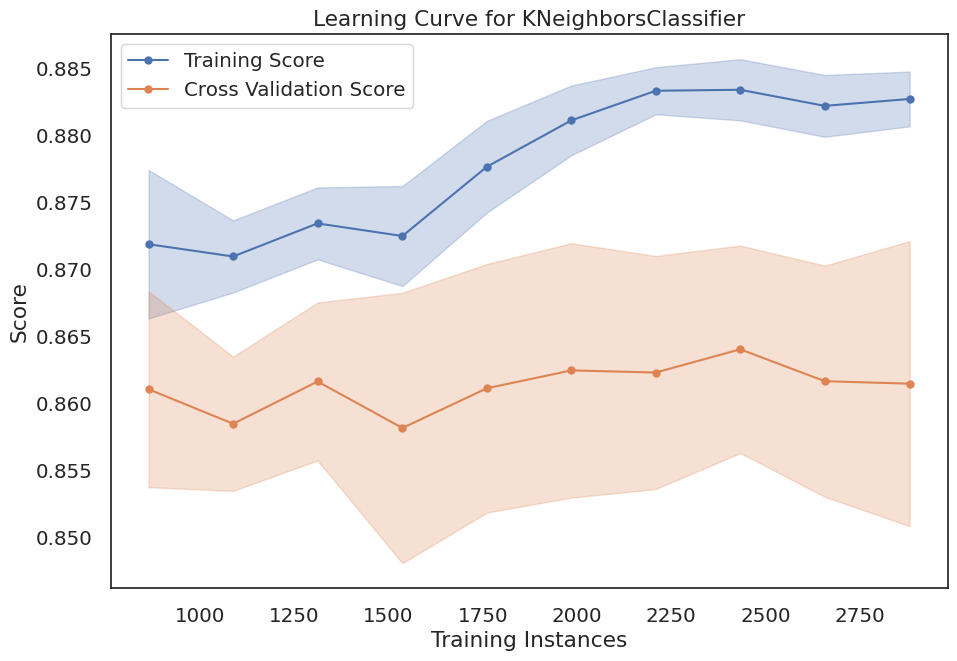

In [ ]:
display_learning_curve(model)

#### Logistic Regression Classifier

In [ ]:
model = lr
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 0.5846388339996338
Test accuracy : 91.22%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


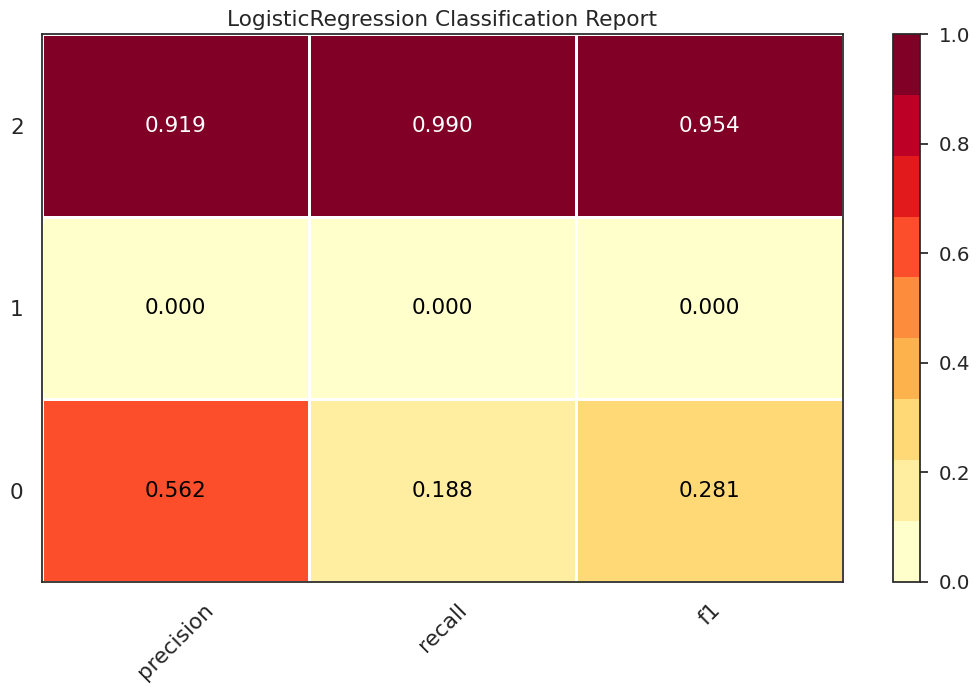

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


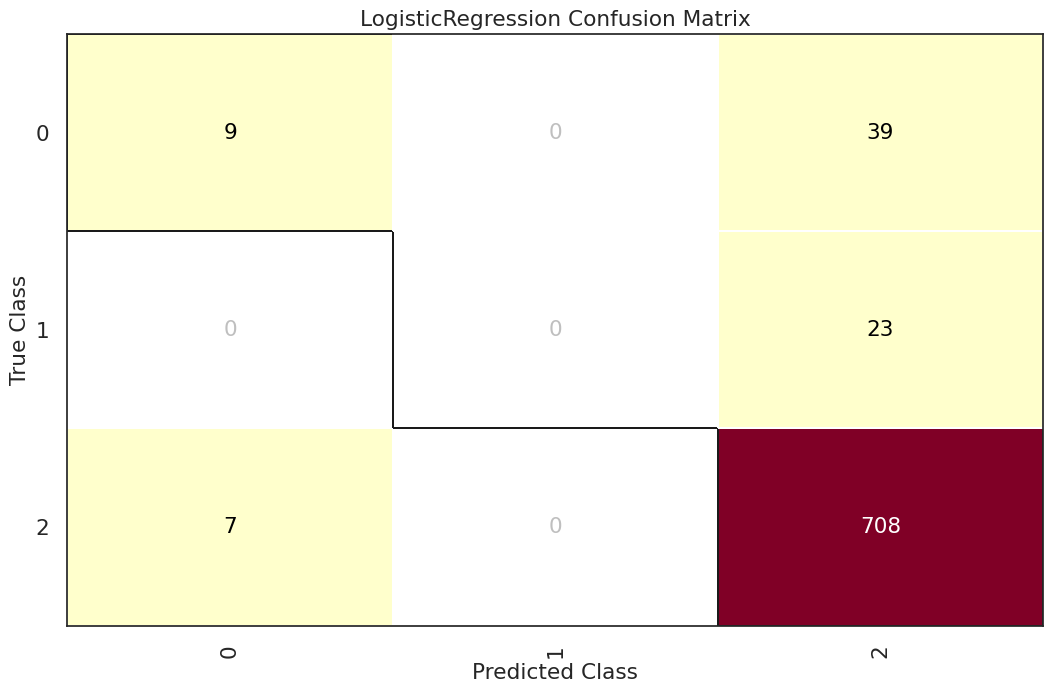

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


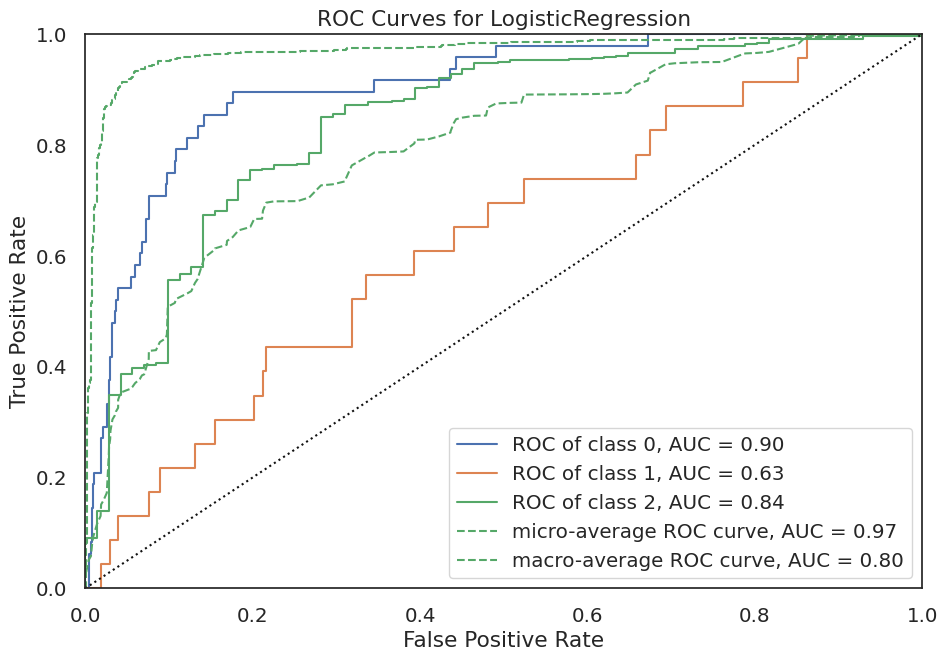

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org

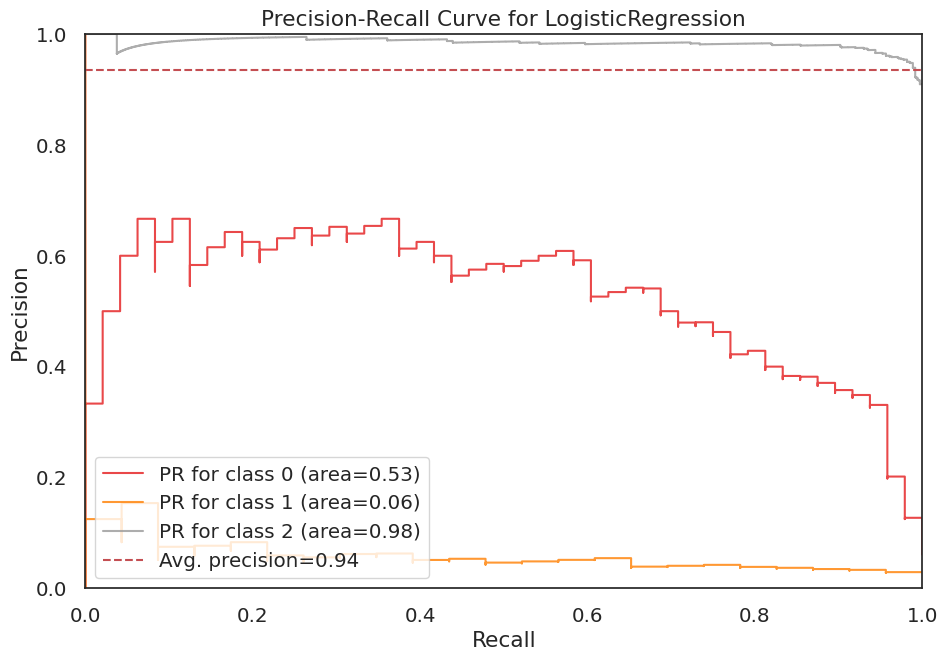

In [ ]:
display_precision_recall_curve(model)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

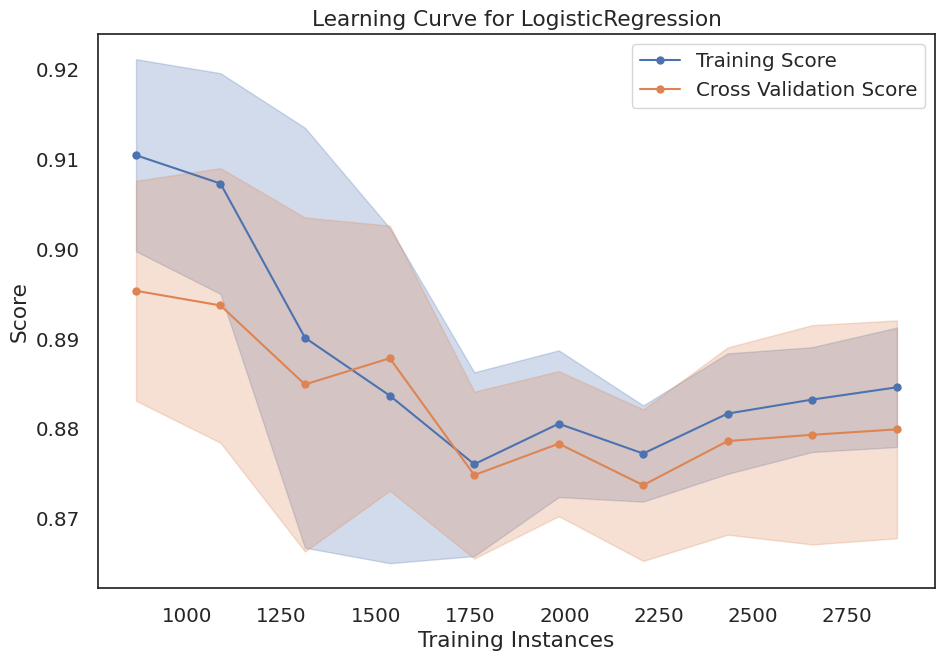

In [ ]:
display_learning_curve(model)

#### LinearSVC  Classifier

In [ ]:
model = svc
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 1.4531340599060059
Test accuracy : 90.20%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


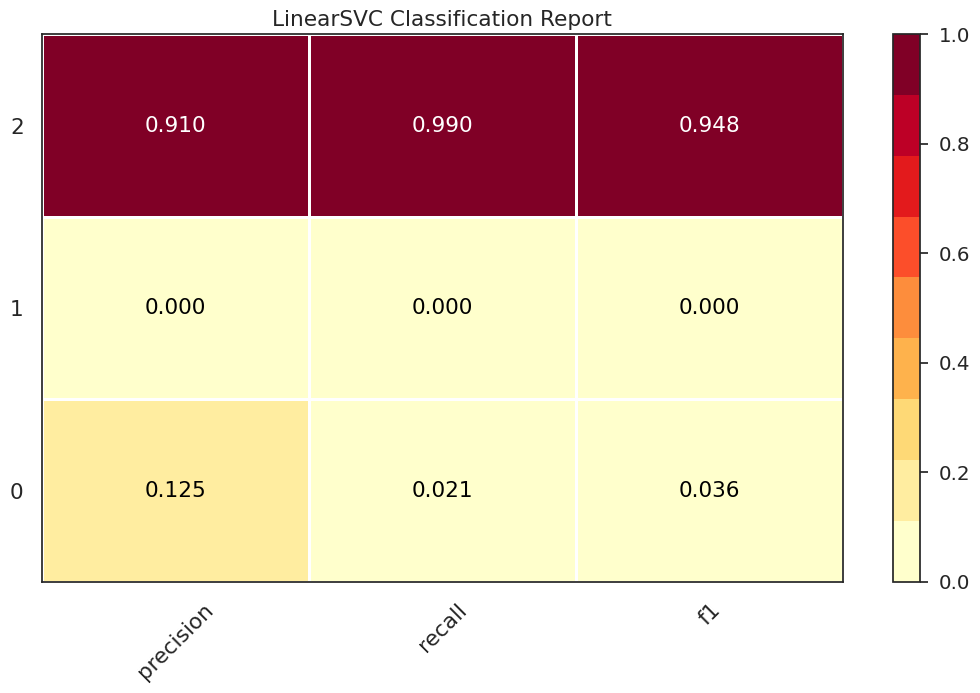

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


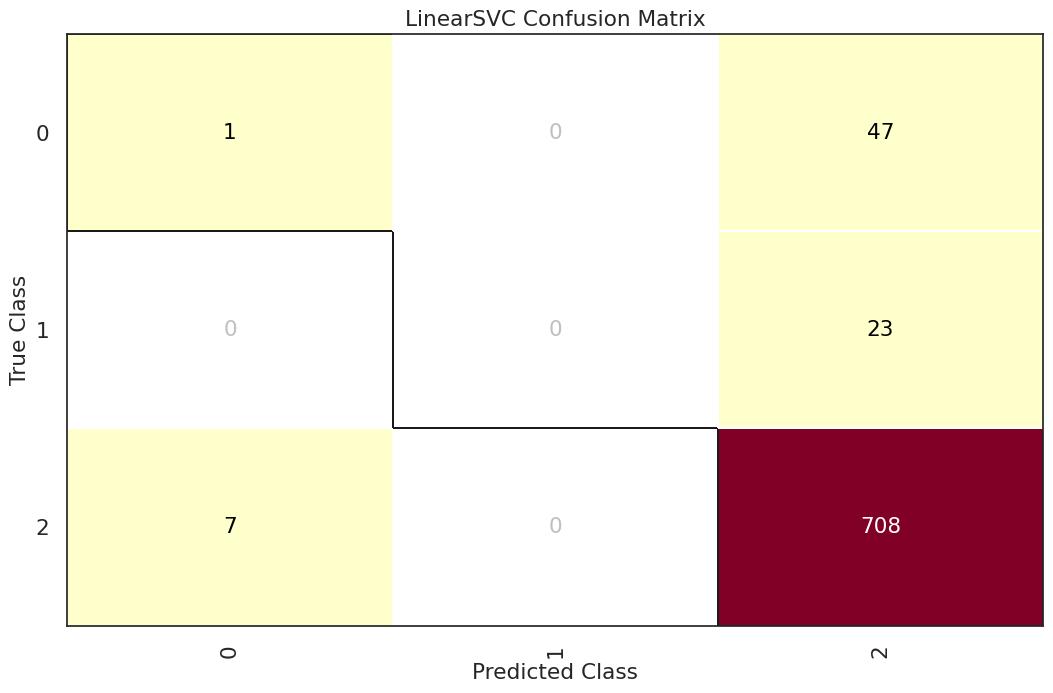

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


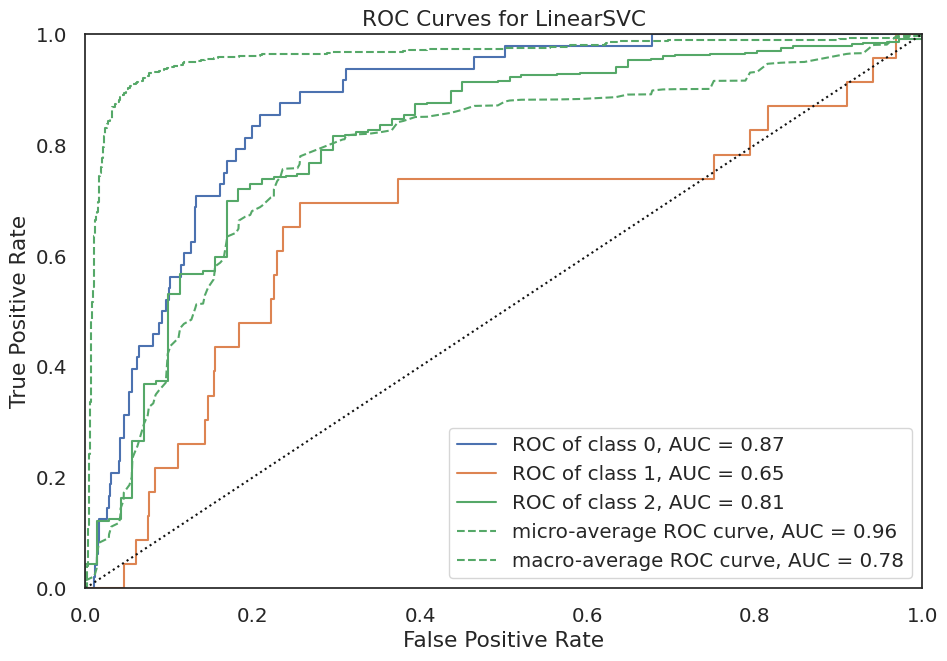

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


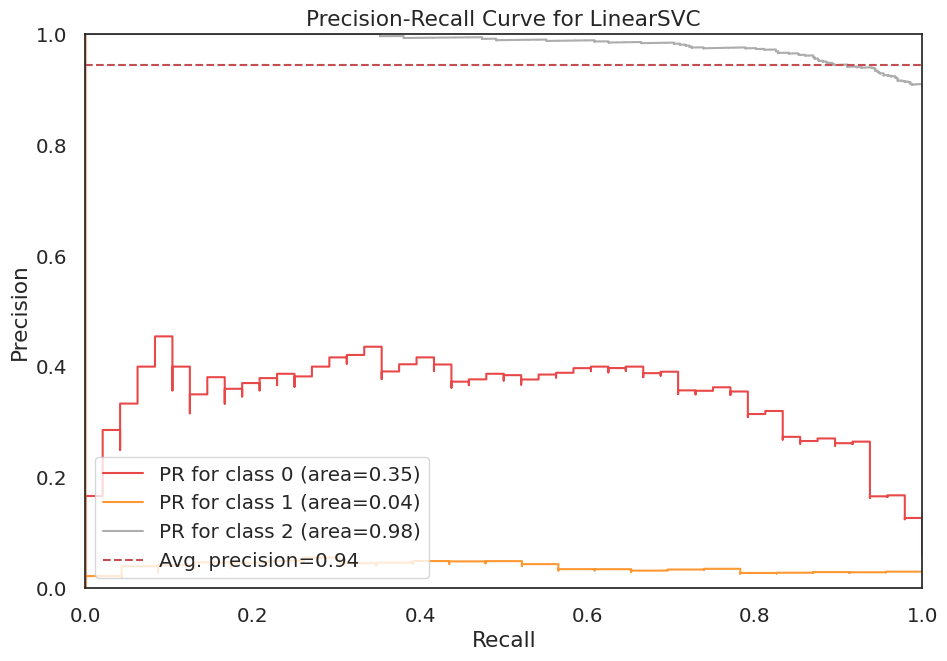

In [ ]:
display_precision_recall_curve(model)

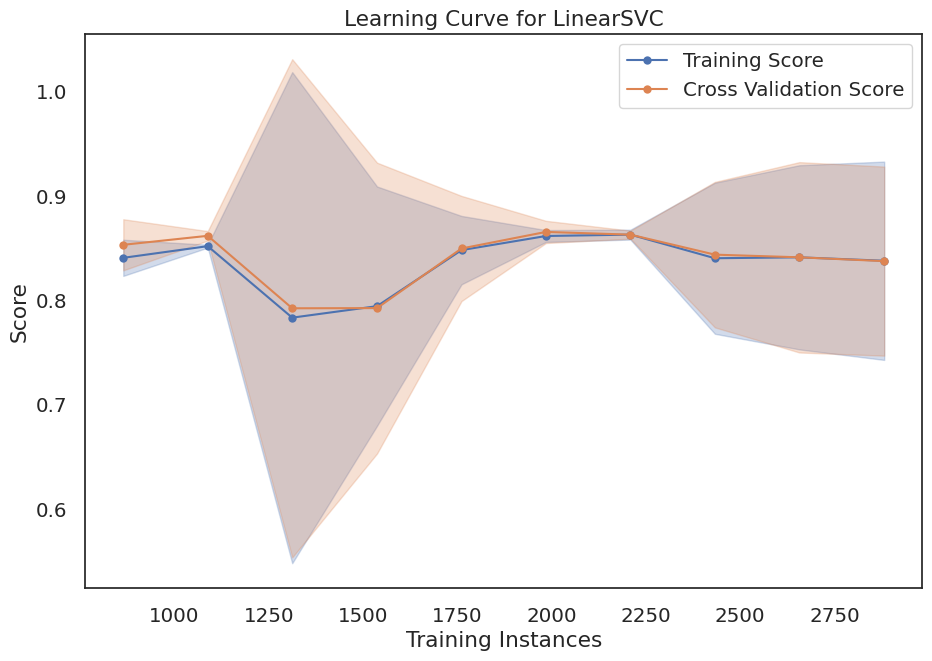

In [ ]:
display_learning_curve(model)

#### Random Forest Classifier

In [ ]:
model = rf
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 0.6859886646270752
Test accuracy : 91.98%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


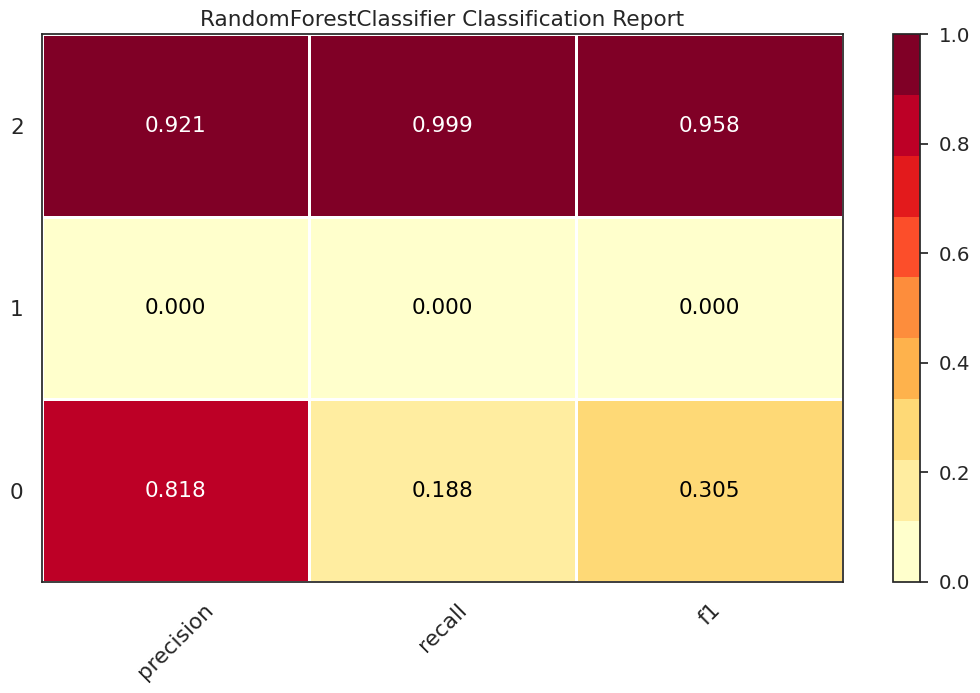

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


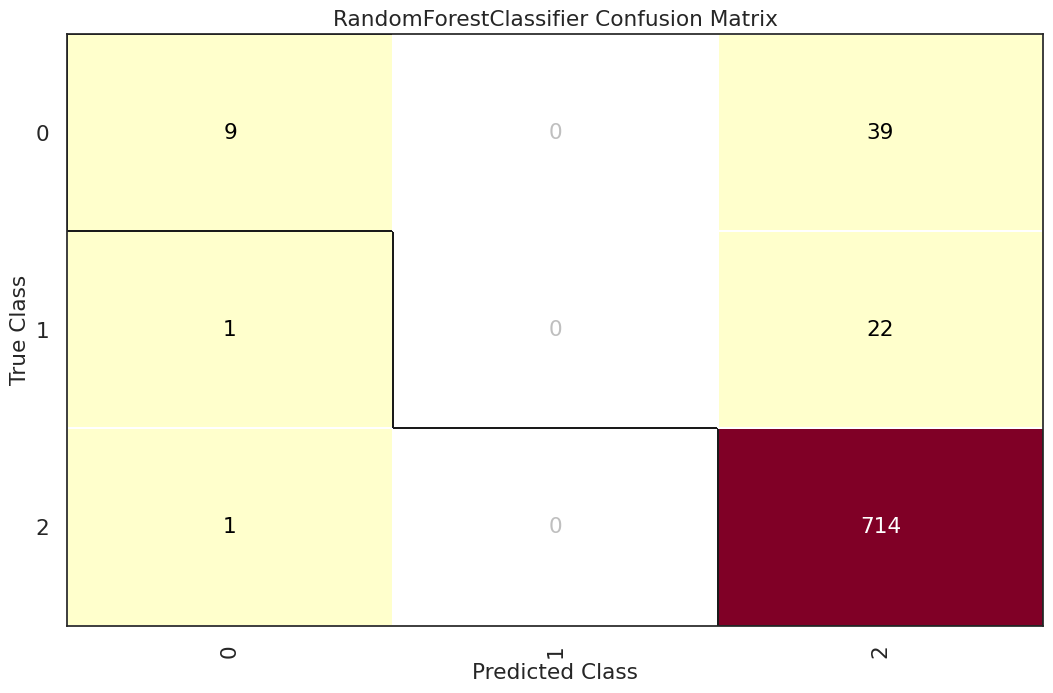

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


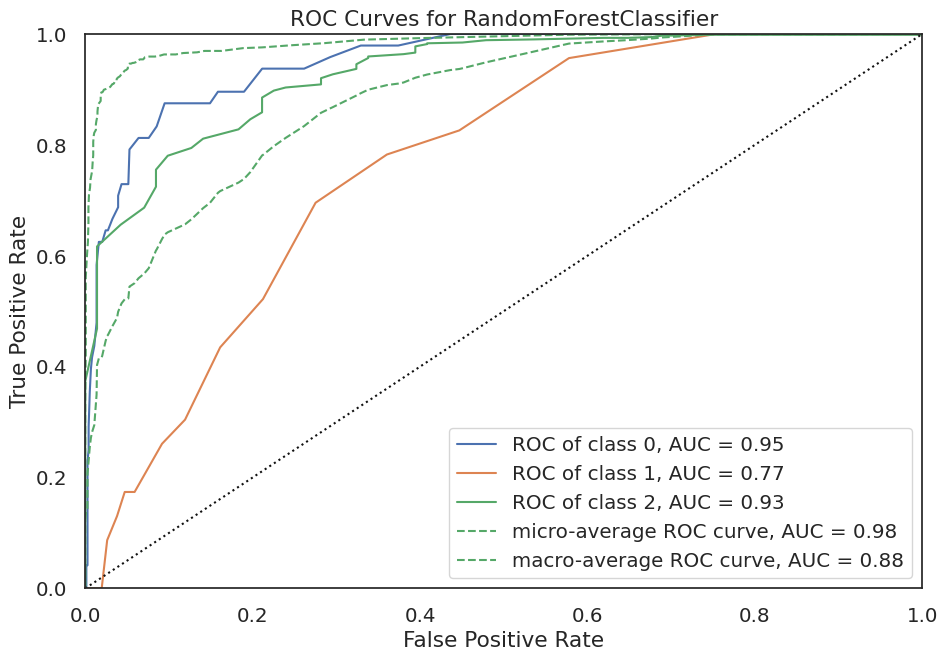

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


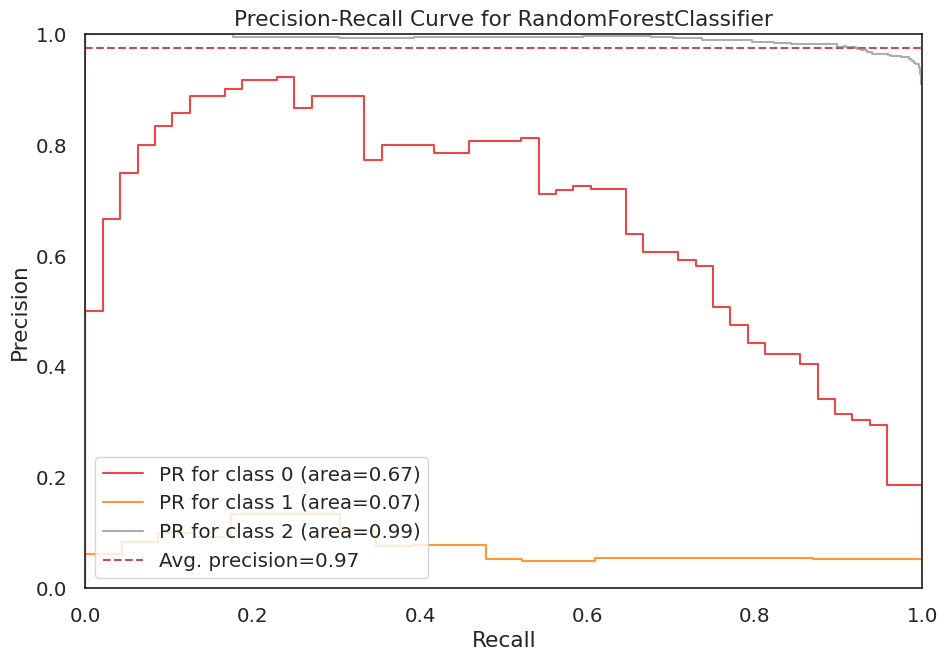

In [ ]:
display_precision_recall_curve(model)

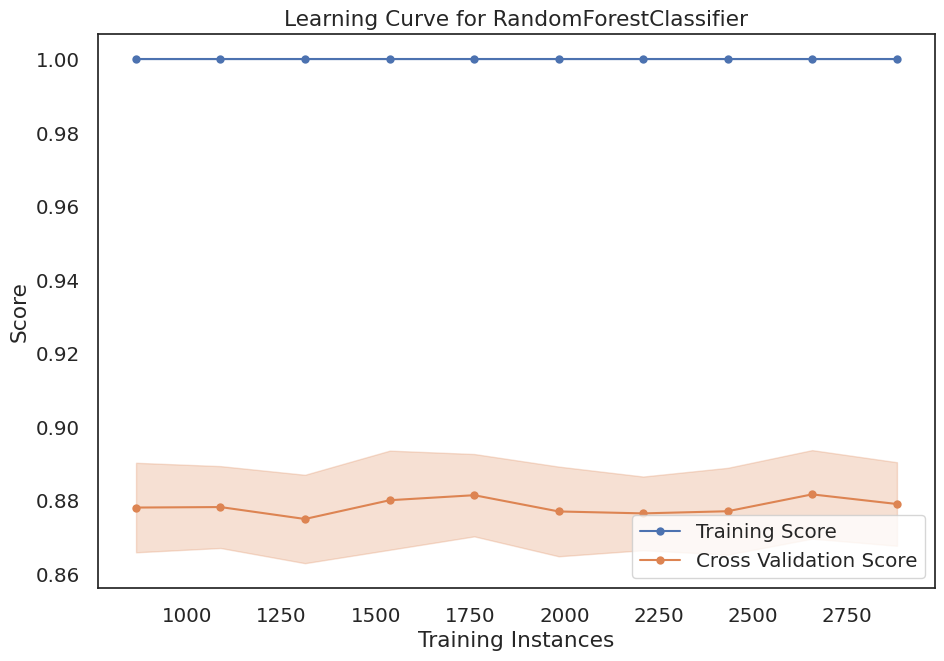

In [ ]:
display_learning_curve(model)

#### Ridge Regression Classifier

In [ ]:
model = rg
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 0.09015607833862305
Test accuracy : 78.37%


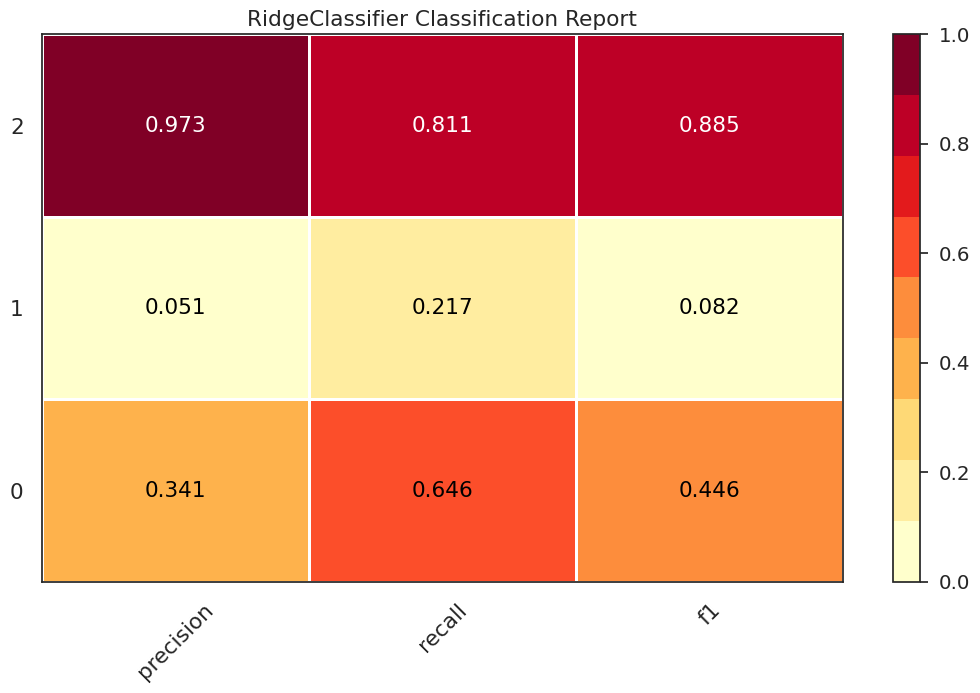

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RidgeClassifier was fitted with feature names
  warnings.warn(


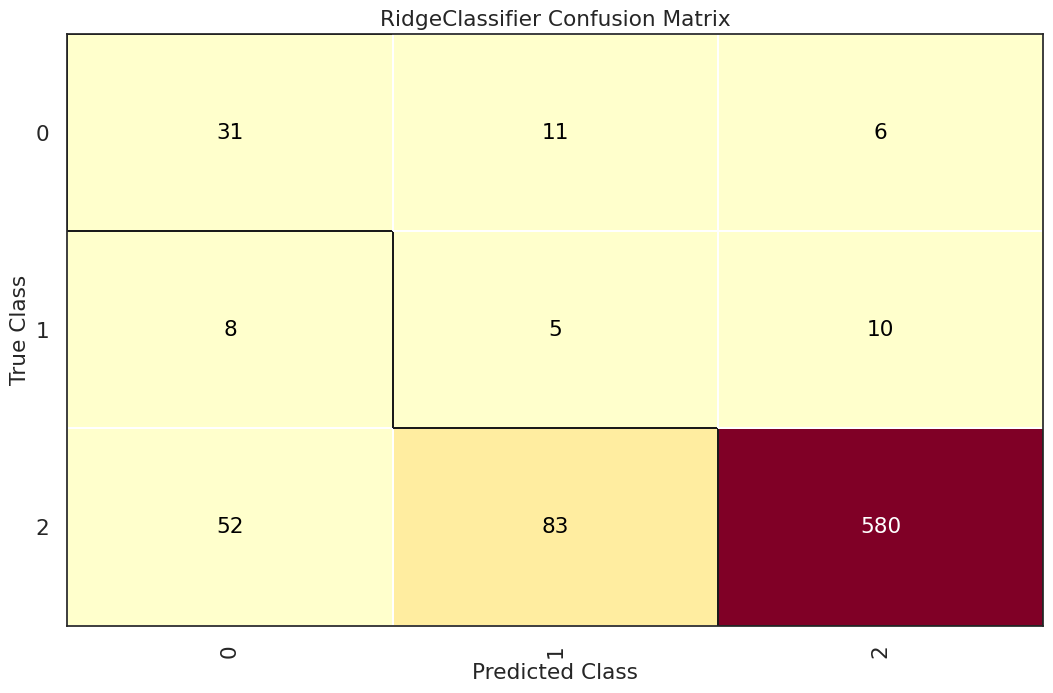

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RidgeClassifier was fitted with feature names
  warnings.warn(


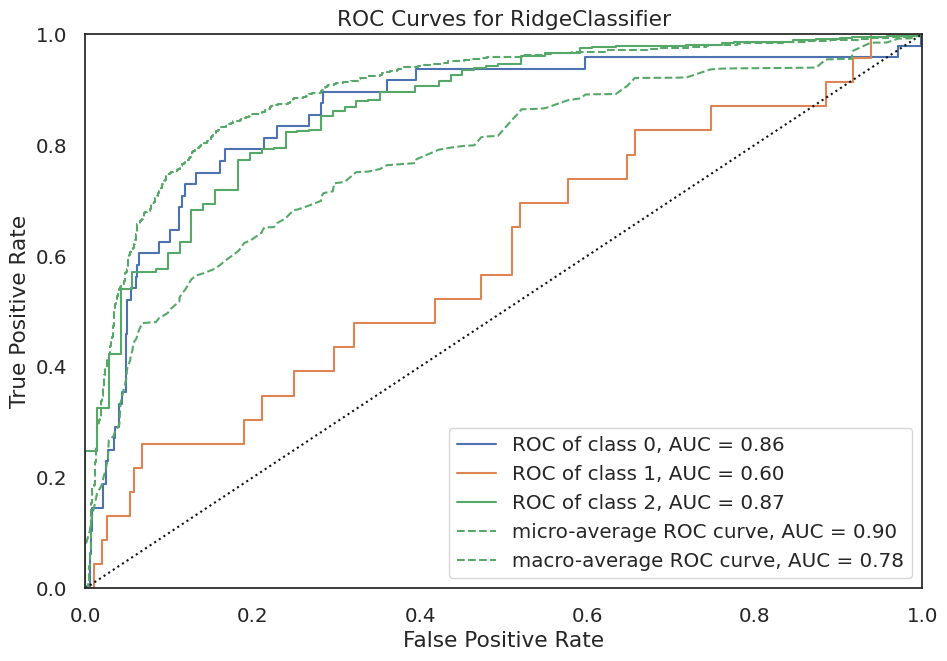

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


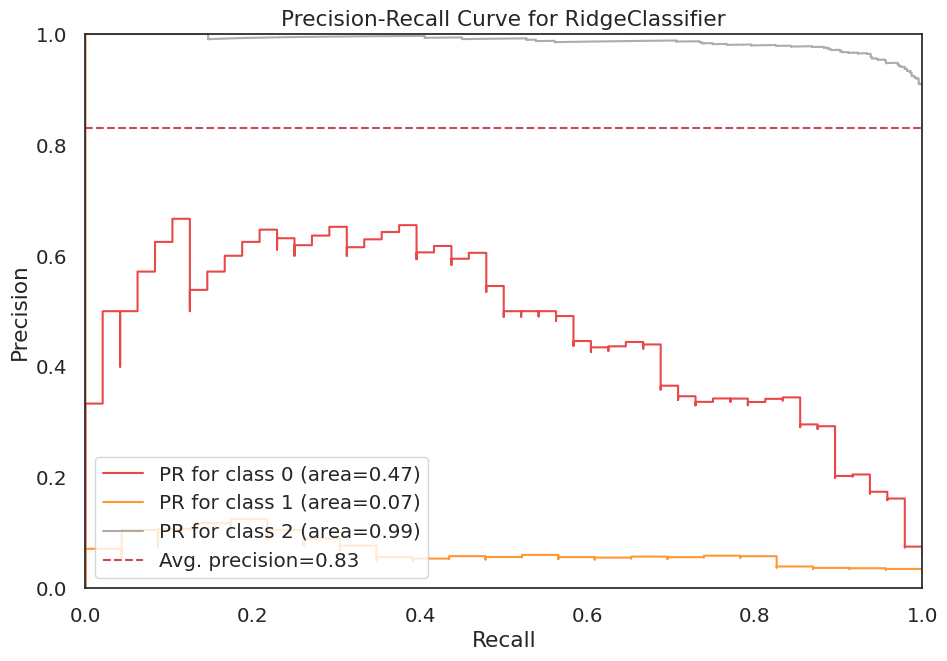

In [ ]:
display_precision_recall_curve(model)

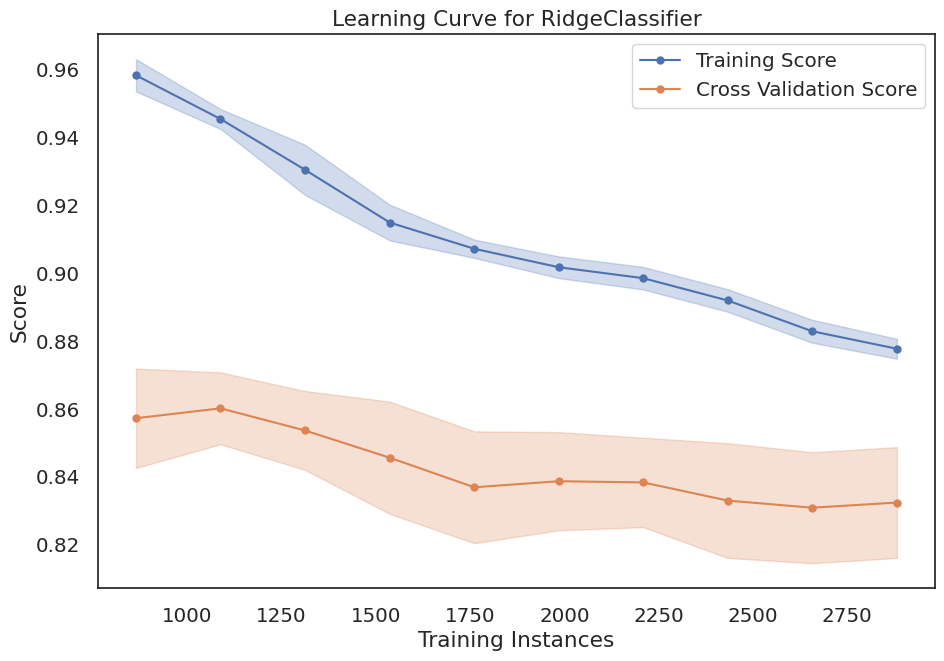

In [ ]:
display_learning_curve(model)

#### XGBoost Classifier

In [ ]:
model = xgb
model.class_counts_ = 3
model.enable_categorical = True

In [ ]:
display_accuracy(model)

Training time: 1.0700387954711914
Test accuracy : 94.15%


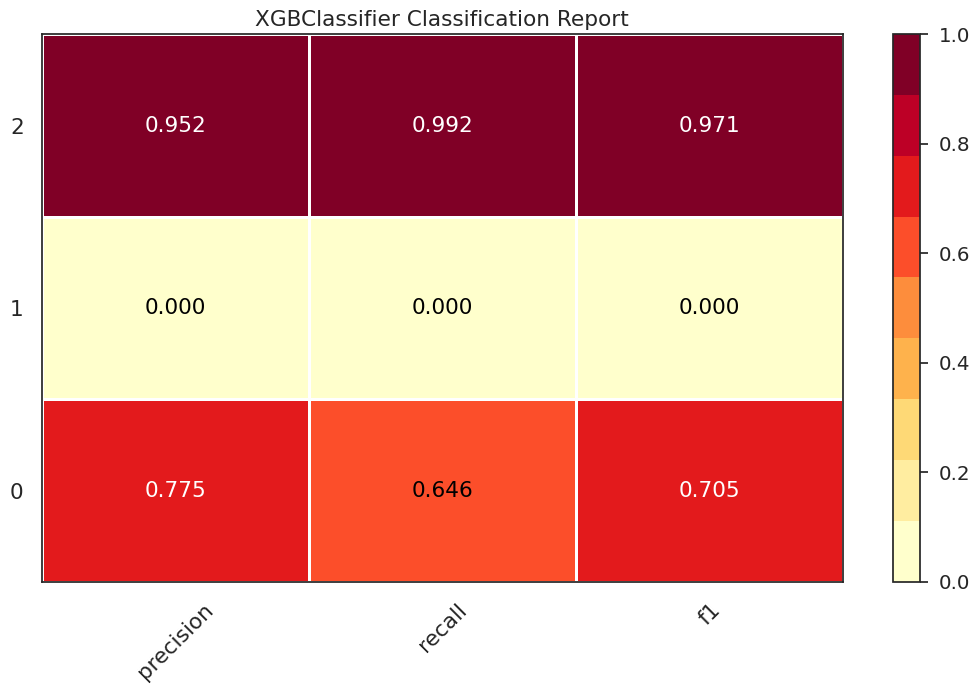

In [ ]:
display_classification_report(model)

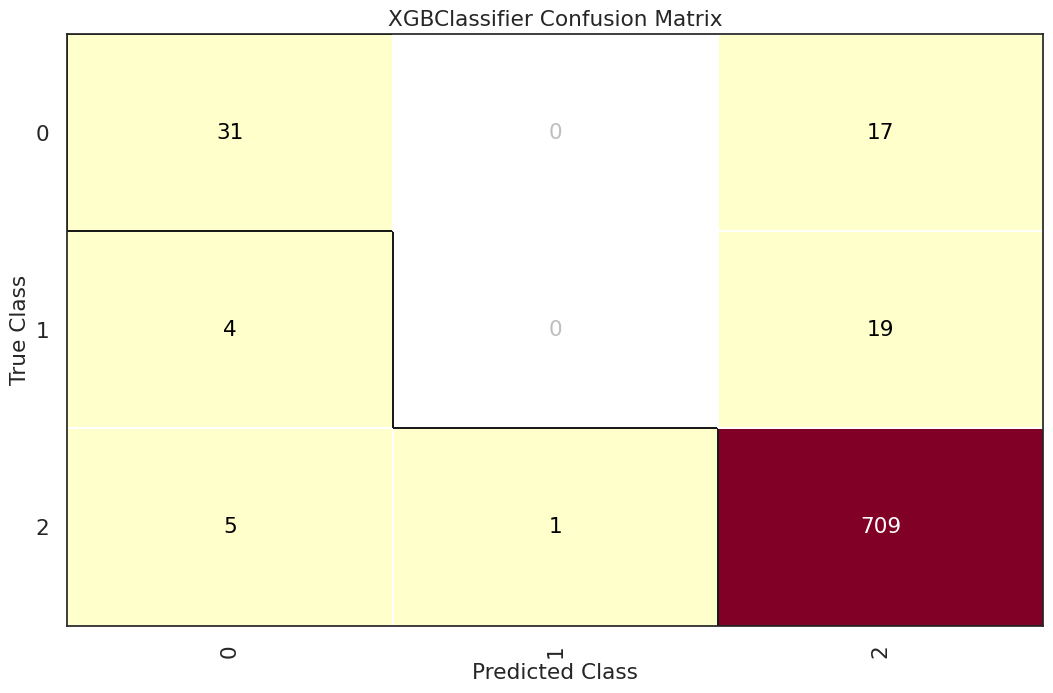

In [ ]:
display_confusion_matrix(model)

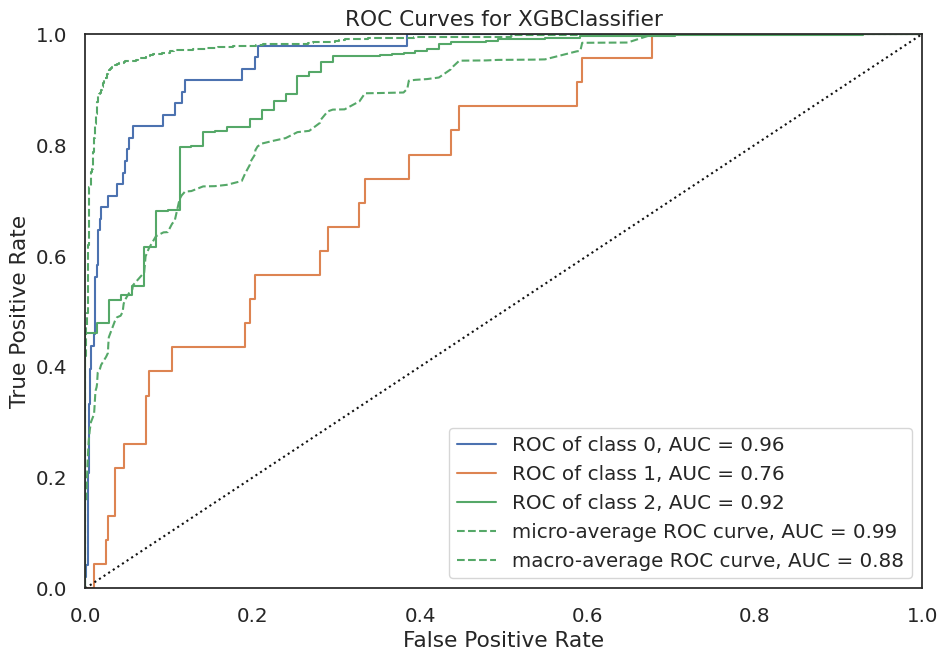

In [ ]:
display_roc_curve(model)

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


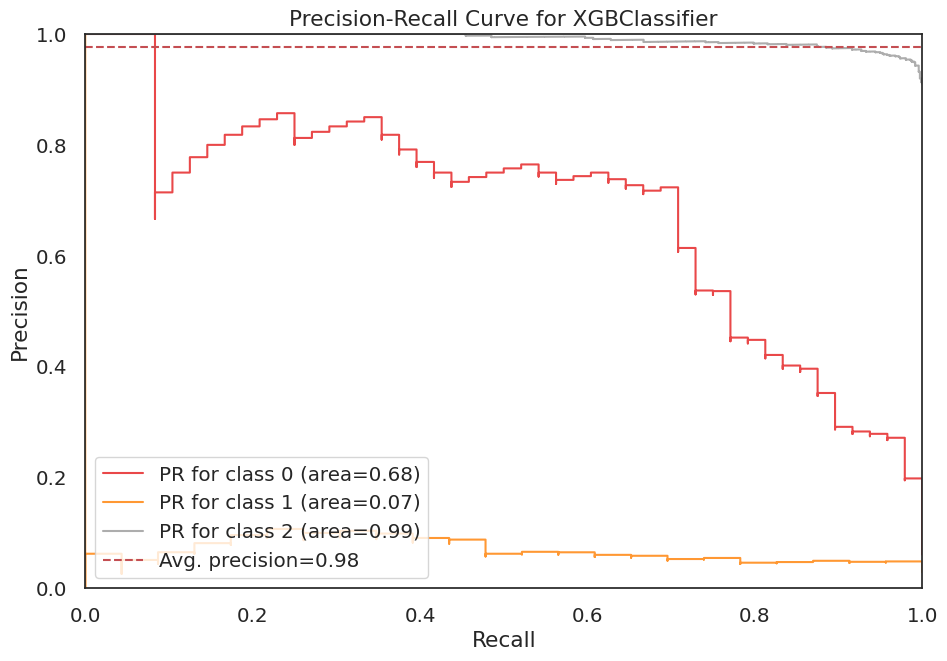

In [ ]:
display_precision_recall_curve(model)

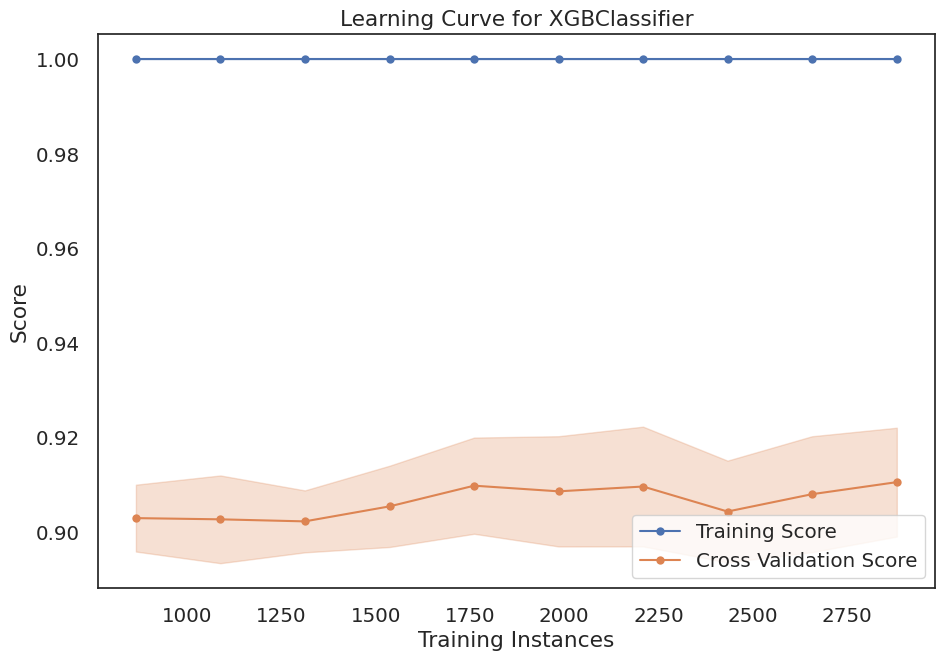

In [ ]:
display_learning_curve(model)

### Bagging

Bagging (stands for Bootstrap Aggregating) is a way to decrease the variance of your prediction by generating additional data for training from your original dataset using combinations with repetitions to produce multisets of the same cardinality/size as your original data. By increasing the size of your training set you can't improve the model predictive force, but just decrease the variance, narrowly tuning the prediction to expected outcome.

In [ ]:
# Define an array of classifiers.
clf_array = [rf, et, knn, svc, rg]

for clf in clf_array:
    # Perform cross-validation for the current classifier.
    # 'cross_val_score' computes the score of the model for each run of the cross-validation.
    # 'X' and 'y' are the feature set and target variable respectively.
    # 'cv = 10' sets 10-fold cross-validation.
    # 'n_jobs = -1' means using all processors for parallel computing.
    vanilla_scores = cross_val_score(clf, X, y, cv = 10, n_jobs = -1)

    # Apply Bagging to the current classifier.
    # 'BaggingClassifier' is an ensemble meta-estimator that fits base classifiers on random subsets of the original dataset.
    # 'max_samples = 0.4' means each base classifier is trained on 40% of the data.
    # 'max_features = 10' means each base classifier is trained on 10 features.
    # 'random_state' ensures reproducibility.
    bagging_clf = BaggingClassifier(clf, max_samples = 0.4, max_features = 10, random_state = random_state)

    # Perform cross-validation for the bagging classifier.
    bagging_scores = cross_val_score(bagging_clf, X, y, cv = 10, n_jobs = -1)

    # Print the mean and standard deviation of the vanilla (original) classifier's scores.
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__, vanilla_scores.mean(), vanilla_scores.std()))

    # Print the mean and standard deviation of the bagging classifier's scores.
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__, bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.912, std: (+/-) 0.005 [RandomForestClassifier]
Mean of: 0.907, std: (+/-) 0.004 [Bagging RandomForestClassifier]

Mean of: 0.914, std: (+/-) 0.005 [ExtraTreesClassifier]
Mean of: 0.888, std: (+/-) 0.011 [Bagging ExtraTreesClassifier]

Mean of: 0.893, std: (+/-) 0.007 [KNeighborsClassifier]
Mean of: 0.905, std: (+/-) 0.001 [Bagging KNeighborsClassifier]

Mean of: 0.868, std: (+/-) 0.078 [LinearSVC]
Mean of: 0.904, std: (+/-) 0.002 [Bagging LinearSVC]

Mean of: 0.779, std: (+/-) 0.014 [RidgeClassifier]
Mean of: 0.626, std: (+/-) 0.153 [Bagging RidgeClassifier]



#### Set up voting

In [ ]:
# Create an ensemble classifier using VotingClassifier.
# This classifier aggregates the predictions of each of the individual models (rf, et, knn, svc, rg) and predicts the class that gets the most votes.
# 'estimators' is a list of tuples where each tuple contains a name and a classifier object.
# 'voting='hard'' means that the predicted class label for each sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier.
eclf = VotingClassifier(estimators = [('Random Forest', rf),
                                      ('Extra Trees', et),
                                      ('KNeighbors', knn),
                                      ('SVC', svc),
                                      ('Ridge Classifier', rg)],
                         voting = 'hard')

# Iterate over the individual classifiers and the ensemble classifier.
for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
    # Perform cross-validation for each classifier.
    # 'cross_val_score' computes the score (accuracy in this case) of the model for each run of the cross-validation.
    # 'X' and 'y' are the feature set and target variable respectively.
    # 'cv = 10' sets 10-fold cross-validation.
    # 'scoring = 'accuracy'' sets the scoring metric to accuracy.
    scores = cross_val_score(clf, X, y, cv = 10, scoring = 'accuracy')

    # Print the mean and standard deviation of the accuracy scores for each classifier.
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.912, std: (+/-) 0.005 [Random Forest]
Mean: 0.914, std: (+/-) 0.005 [Extra Trees]
Mean: 0.893, std: (+/-) 0.007 [KNeighbors]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Mean: 0.868, std: (+/-) 0.078 [SVC]
Mean: 0.779, std: (+/-) 0.014 [Ridge Classifier]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Mean: 0.911, std: (+/-) 0.006 [Ensemble]


#### Set up ensemble voting for bagging

In [ ]:
# Initialize an empty list to store bagging classifiers.
ebclf_array = []

# Loop through each classifier in clf_array (assumed to be previously defined).
for clf in clf_array:
    # For each classifier, create a BaggingClassifier.
    # Bagging (Bootstrap Aggregating) involves taking multiple samples from the training dataset with replacement and training a model on each sample.
    # 'max_samples = 0.25' means each base estimator is trained on 25% of the training data.
    # 'max_features = 10' limits the number of features to be drawn from the total.
    # 'random_state' ensures reproducibility of the results.
    # The created BaggingClassifier is appended to the list ebclf_array.
    ebclf_array.append(BaggingClassifier(clf, max_samples = 0.25, max_features = 10, random_state = random_state))


# Create a VotingClassifier for the ensemble of bagging classifiers.
# This classifier aggregates the predictions from each individual bagging classifier and predicts the class that gets the most votes ('hard' voting).
# The estimators are individual bagging classifiers for each of the classifiers in clf_array.
v_eclf = VotingClassifier(estimators=[('Bagging Random Forest', BaggingClassifier(rf, max_samples = 0.25, max_features = 10, random_state = random_state)),
                                      ('Bagging Extra Trees', BaggingClassifier(et, max_samples = 0.25, max_features = 10, random_state = random_state)),
                                      ('Bagging KNeighbors', BaggingClassifier(knn, max_samples = 0.25, max_features = 10, random_state = random_state)),
                                      ('Bagging SVC', BaggingClassifier(svc, max_samples = 0.25, max_features = 10, random_state = random_state)),
                                      ('Bagging Ridge Classifier', BaggingClassifier(rg, max_samples = 0.25, max_features = 10, random_state = random_state))],
                         voting = 'hard')

# Add the ensemble voting classifier to the array of bagging classifiers.
ebclf_array.append(v_eclf)

# Evaluate each classifier in the ebclf_array.
for clf, label in zip(ebclf_array, ['Bagging Random Forest',
                                    'Bagging Extra Trees',
                                    'Bagging KNeighbors',
                                    'Bagging SVC',
                                    'BaggingRidge Classifier',
                                    'Bagging Ensemble']):
    # Perform cross-validation and compute the score (accuracy in this case) for each classifier.
    # 'cv = 10' sets 10-fold cross-validation.
    # 'scoring = 'accuracy'' specifies that the accuracy should be used as the scoring metric.
    scores = cross_val_score(clf, X, y, cv = 10, scoring = 'accuracy')

    # Print the mean and standard deviation of the accuracy scores for each classifier.
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))


Mean: 0.906, std: (+/-) 0.003 [Bagging Random Forest]
Mean: 0.896, std: (+/-) 0.010 [Bagging Extra Trees]
Mean: 0.905, std: (+/-) 0.001 [Bagging KNeighbors]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Mean: 0.905, std: (+/-) 0.002 [Bagging SVC]
Mean: 0.714, std: (+/-) 0.130 [BaggingRidge Classifier]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Mean: 0.906, std: (+/-) 0.002 [Bagging Ensemble]


In [ ]:
model = v_eclf
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Training time: 4.281878232955933
Test accuracy : 91.22%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


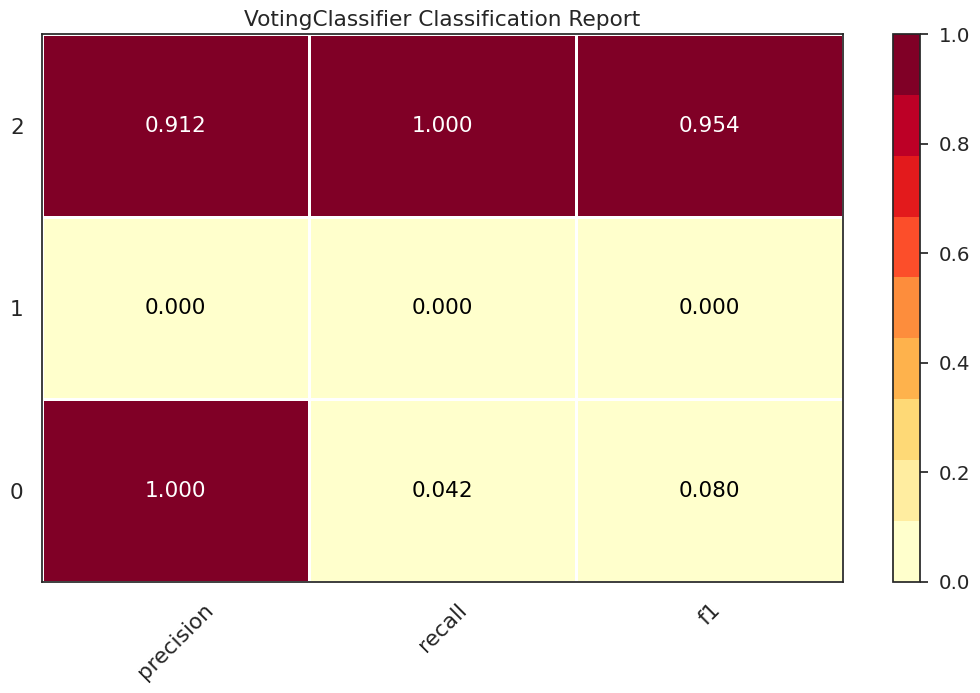

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


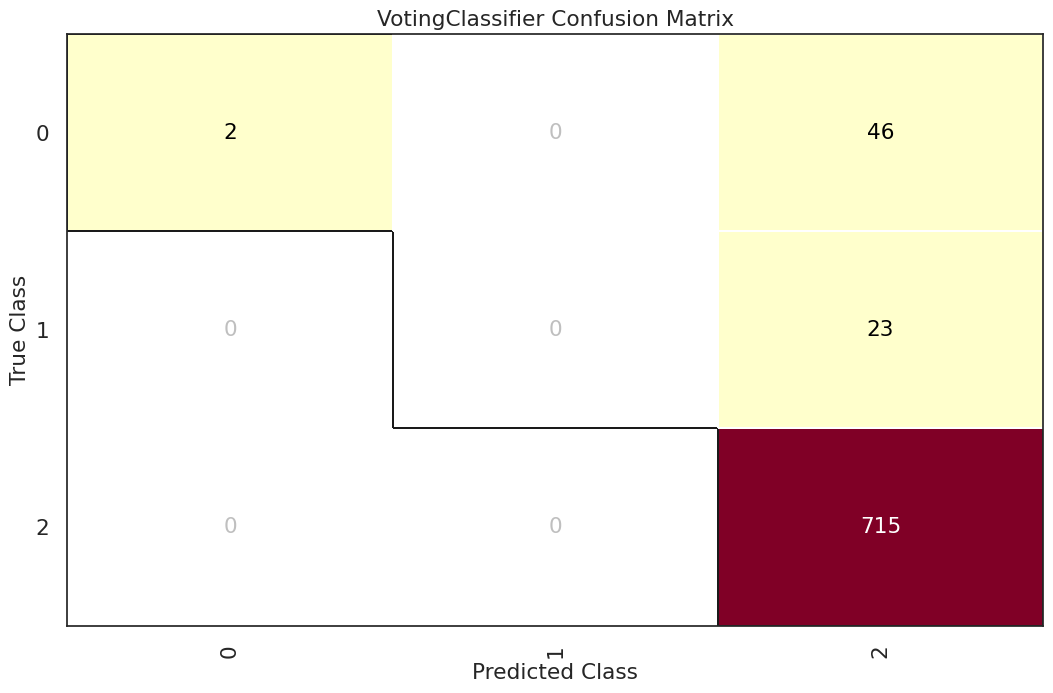

In [ ]:
display_confusion_matrix(model)

#### Boosting

Boosting is a two-step approach, where one first uses subsets of the original data to produce a series of averagely performing models and then "boosts" their performance by combining them together using a particular cost function (=majority vote). Unlike bagging, in the classical boosting the subset creation is not random and depends upon the performance of the previous models: every new subsets contains the elements that were (likely to be) misclassified by previous models.

In [ ]:
# Define an array of boosting classifiers.
# This array includes AdaBoost (ab), Gradient Boosting (gb), and XGBoost (xgb).
# These are different types of ensemble learning techniques where models are built sequentially to correct the errors of the previous models.
boost_array = [ab, gb, xgb]

# Create an EnsembleVoteClassifier.
# This classifier combines the predictions from each individual boosting classifier (ab, gb, xgb) and predicts the class based on majority voting ('hard' voting).
# 'clfs = [ab, gb, xgb]' defines the classifiers to be included in the ensemble.
# 'voting = 'hard'' signifies that the final class prediction is based on the majority vote of the individual classifiers.
eclf = EnsembleVoteClassifier(clfs = [ab, gb, xgb], voting = 'hard')

# Define labels for each of the classifiers for easy identification during output.
labels = ['AdaBoost', 'Gradient Boosting', 'XGBoost', 'Ensemble']

# Iterate over each classifier and its corresponding label.
for clf, label in zip([ab, gb, xgb, eclf], labels):
    # Perform cross-validation for each classifier.
    # 'cross_val_score' computes the score (accuracy in this case) of the model for each run of the cross-validation.
    # 'X' and 'y' are the feature set and target variable respectively.
    # 'cv = 10' sets 10-fold cross-validation.
    # 'scoring = 'accuracy'' specifies that accuracy should be used as the scoring metric.
    scores = cross_val_score(clf, X, y, cv = 10, scoring = 'accuracy')

    # Print the mean and standard deviation of the accuracy scores for each classifier.
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.921, std: (+/-) 0.005 [AdaBoost]
Mean: 0.926, std: (+/-) 0.004 [Gradient Boosting]
Mean: 0.929, std: (+/-) 0.010 [XGBoost]
Mean: 0.931, std: (+/-) 0.007 [Ensemble]


In [ ]:
model = eclf
model.class_counts_ = 3

In [ ]:
display_accuracy(model)

Training time: 11.64792275428772
Test accuracy : 94.15%


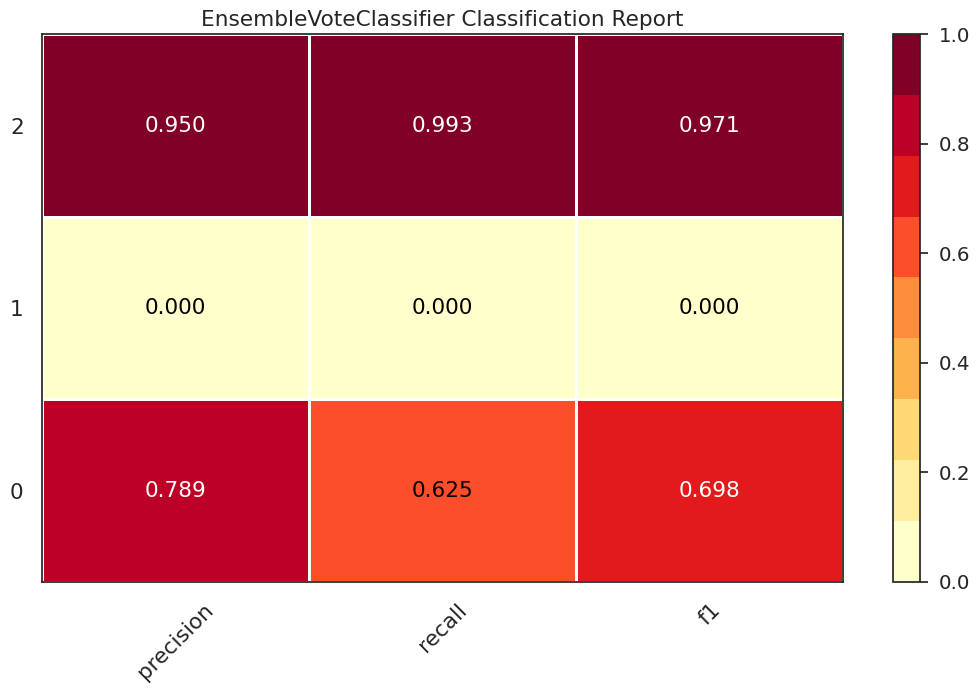

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


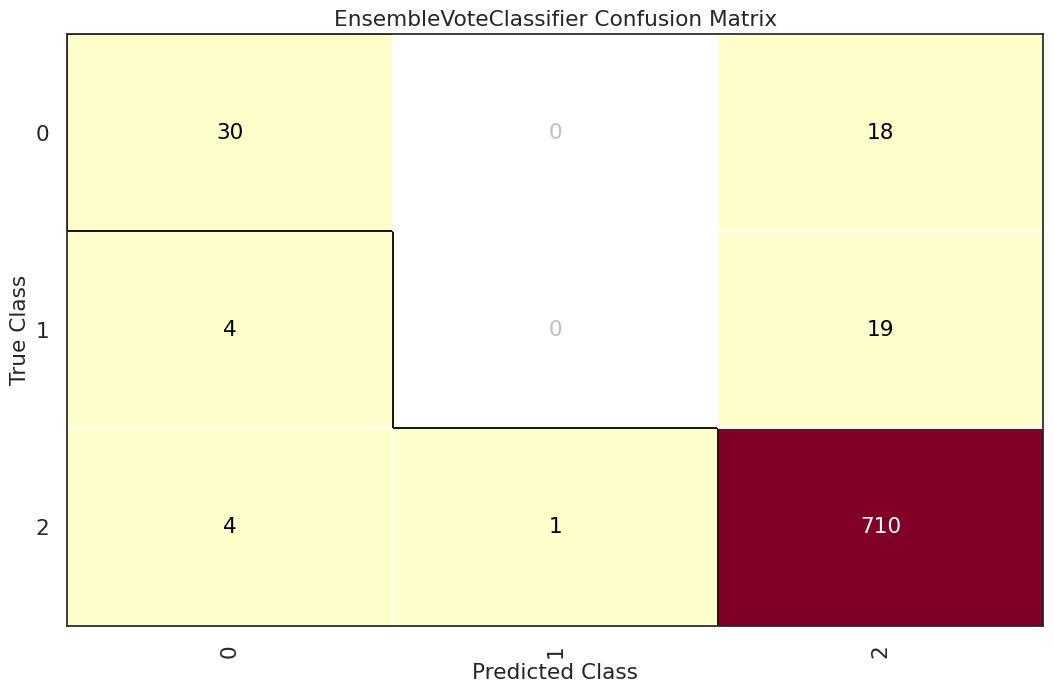

In [ ]:
display_confusion_matrix(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


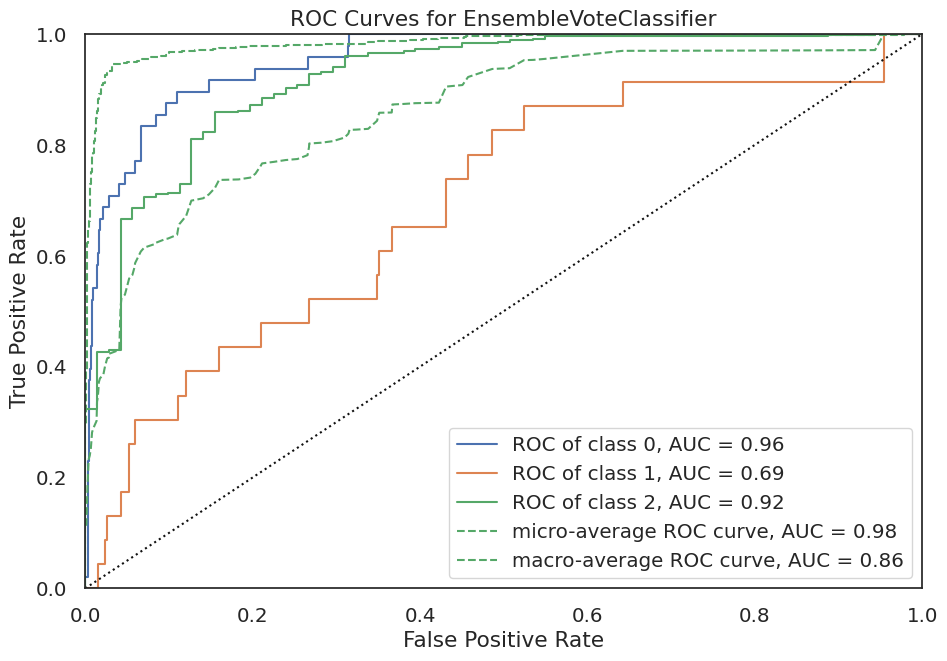

In [ ]:
display_roc_curve(model)

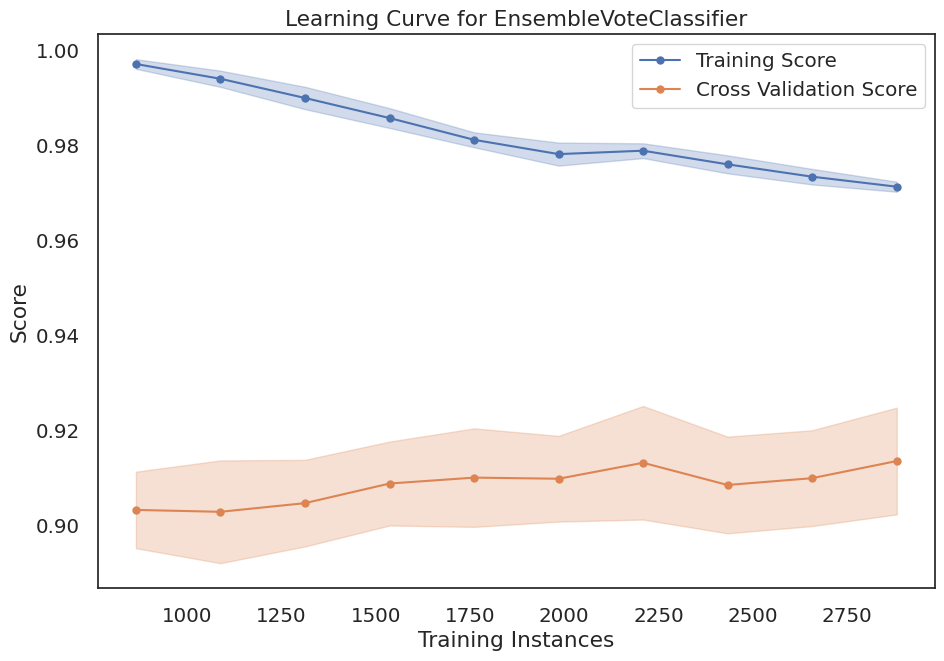

In [ ]:
display_learning_curve(model)

### Stacking

Stacking is a similar to boosting: you also apply several models to your original data. The difference here is, however, that you don't have just an empirical formula for your weight function, rather you introduce a meta-level and use another model/approach to estimate the input together with outputs of every model to estimate the weights or, in other words, to determine what models perform well and what badly given these input data.

In [ ]:
# Define a list of estimators for stacking.
# Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor.
# In this list, each tuple contains a name and a classifier object.
# 'lr' is a logistic regression classifier, 'gb' is a gradient boosting classifier, and 'svc' is a support vector classifier.
estimators = [
  ('lr', lr),
  ('gb', gb),
  ('svc', svc)
]

# Create a StackingClassifier.
# This classifier stacks the individual classifiers defined in the 'estimators' list and uses a final classifier to make the final decision.
# 'estimators=estimators' sets the base classifiers.
# 'final_estimator=lr' sets logistic regression as the final estimator, which makes predictions based on the combined features from the individual base classifiers.
s_eclf = StackingClassifier(
  estimators = estimators,
  final_estimator = lr
)

# Fit the stacking classifier to the training data.
# X_train contains the features for training, and y_train contains the corresponding labels.
# The stacking classifier first trains each of the base classifiers (lr, gb, svc) on the training data,
# and then the final_estimator (lr in this case) is trained on the outputs of these base classifiers.
s_eclf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

StackingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('svc',
                                LinearSVC(class_weight='balanced',
                                          random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [ ]:
model = s_eclf

In [ ]:
display_accuracy(model)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

Training time: 43.52939701080322
Test accuracy : 93.00%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


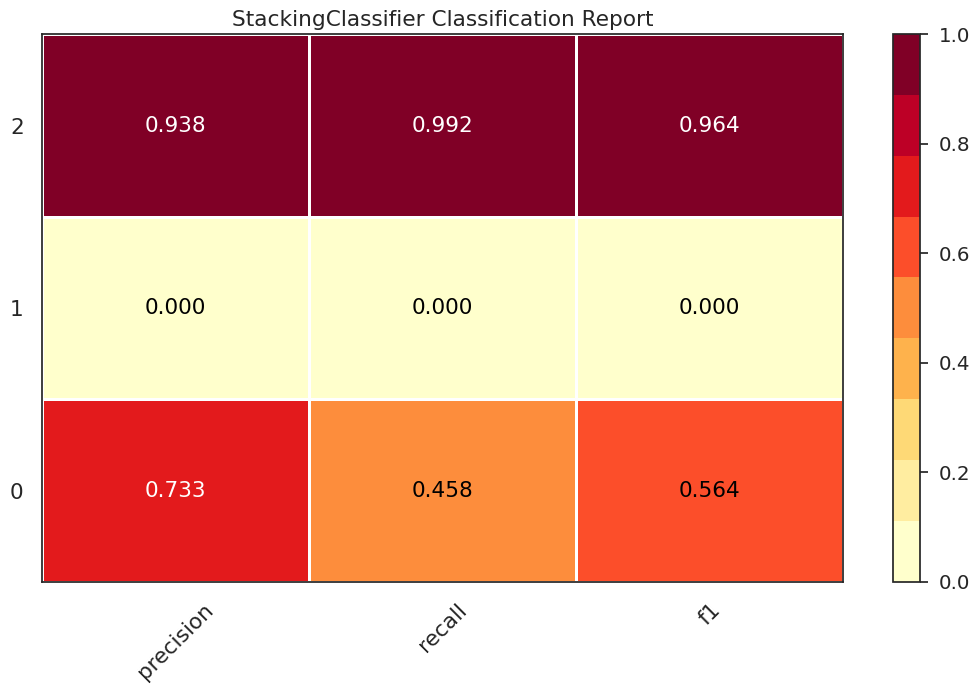

In [ ]:
display_classification_report(model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


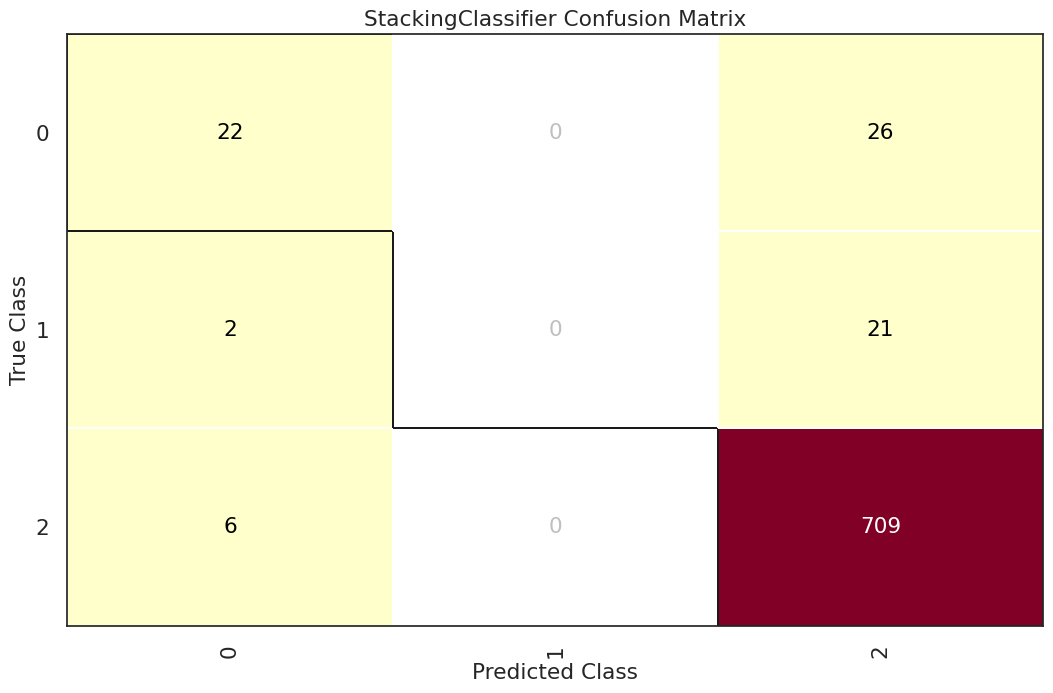

In [ ]:
display_confusion_matrix(model)

## Save Model

In [ ]:
# Save the model to file
filename = 'finalized_model.pkl'

with open(filename, 'wb') as file:
  pickle.dump(eclf, file)

## Load the Model

In [ ]:
with open(filename, 'rb') as file:
  loaded_model = pickle.load(file)

### Conclusions

The sentiment analysis experiment conducted on the "Amazon Reviews for Sentiment Analysis" dataset has yielded significant insights and demonstrated the effectiveness of ensemble methods in machine learning. Utilizing a diverse set of classifiers, including AdaBoost, ExtraTrees, GradientBoosting, K-Nearest Neighbors, Logistic Regression, LinearSVC, Random Forest, Ridge Regression, and XGBoost, the study explored various approaches to categorize Amazon product reviews into negative, neutral, or positive sentiments.

The employment of advanced ensemble techniques such as Bagging, Voting, Ensemble voting for bagging, Boosting, and Stacking further enhanced the model's ability to accurately classify sentiments. The culmination of these methods was the implementation of an Ensemble Voting strategy that synergistically combined AdaBoost, Gradient Boosting, and XGBoost with hard voting. This specific configuration achieved a test accuracy of 94.15%, underscoring the power of ensemble models in handling complex sentiment analysis tasks.

This high level of accuracy demonstrates the model's robustness and its potential applicability in real-world scenarios where understanding customer sentiments is crucial for business insights and decision-making. The success of the Ensemble Voting approach, in particular, highlights the value of integrating diverse machine learning techniques to improve predictive performance.

In conclusion, this sentiment analysis model demonstrates the effectiveness of machine learning techniques in extracting meaningful insights from vast datasets, particularly in the context of e-commerce where customer feedback is abundant and varied. The study not only achieved a significant accuracy in sentiment classification but also contributed valuable learnings to the field of machine learning and sentiment analysis.